Geo-columns to handle in the next notebook:
* Latitude
* Longitude
* O'Hare Noise 
* Floodplain
* Near Major Road


Other columns to handle:
* Age Squared
* everything after Age Squared

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from urllib.request import urlretrieve
from IPython.core.display import display, HTML

%matplotlib inline

In [2]:
import geopandas as gpd
from typing import Dict, List, Union, Optional
from textwrap import wrap
import missingno as msno
from shapely.geometry import Point
from scipy.spatial import cKDTree
import itertools
from operator import itemgetter

In [3]:
import psycopg2 as pg

In [4]:
pd.options.display.max_columns = None
# pd.set_option("display.max_columns", None)
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import utils, locations, property_characteristics

from postgisgeocoder.utils import (
    get_engine_from_credential_file,
    get_db_connection_from_credential_file,
    format_addresses_for_standardization,
    get_standardized_address_df,
    geocode_addr,
    execute_result_returning_query
)

In [6]:
conn = get_db_connection_from_credential_file(
    credential_path = os.path.join("..", "..", "postgis_geocoder", "credentials.yml")
)

In [7]:
# dir(utils)

https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Property-Charac/bcnq-qi2z

In [8]:
cc_res_prop_char_df = utils.clean_cc_residential_property_characteristics_data()

In [9]:
cc_res_prop_char_df.head(2)

PIN Property Class  Tax Year Neighborhood Code  Land Square Feet  \
0  1011000040000            212      2018               012             11055   
1  1011000050000            205      2018               012              6534   

  Town Code Type of Residence  Apartments Wall Material    Roof Material  \
0        10         two story           5          Wood   Tar and Gravel   
1        10         two story           0          Wood  Shingle/Asphalt   

   Rooms  Bedrooms Basement Basement Finish  Central Heating Other Heating  \
0      7         5  Partial      Unfinished         Warm air          none   
1      7         4     Full      Unfinished  Hot water steam          none   

   Central Air  Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
0        False           0       Full   Unfinished           1  Stock Plan   
1        False           1       Full   Unfinished           0  Stock Plan   

  Cathedral Ceiling Construction Quality Renovation     Site Desireability  \
0                No              Average        NaN  Not relevant to Value   
1                No              Average        NaN  Not relevant to Value   

  Garage 1 Size Garage 1 Material Garage 1 Attachment  \
0       1.5 car             Frame                  No   
1         2 car             Frame                  No   

                                   Garage 1 Area Garage 2 Size  \
0  No, garage area not included in building area          None   
1  No, garage area not included in building area          None   

           Garage 2 Material        Garage 2 Attachment  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

               Garage 2 Area  Porch  Building Square Feet Repair Condition  \
0  Car Port or Driveway Only      3                  1904          Average   
1  Car Port or Driveway Only      1                  1562          Average   

     Multi Code  Number of Commercial Units  \
0  One building                           1   
1  One building                           0   

   Prior Tax Year Market Value Estimate (Land)  \
0                                        52510   
1                                        31030   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           374930                      NaT   
1                                           173970                      NaT   

   Deed No.  Sale Price  Longitude   Latitude Census Tract  \
0      <NA>        <NA> -88.139621  42.153953       804201   
1      <NA>        <NA> -88.139379  42.153953       804201   

   Total Building Square Feet  Multi Property Indicator  \
0                        <NA>                     False   
1                        <NA>                     False   

           Property Address Modeling Group  Full Baths  Age  Use  \
0  213 W MAIN ST BARRINGTON             MF           5  135    2   
1  209 W MAIN ST BARRINGTON             SF           1  114    1   

   Number of Units  Percent Ownership Condo Class Factor  \
0             <NA>               <NA>                NaN   
1             <NA>               <NA>                NaN   

  Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
0                    Yes      False                                 NaN   
1                    NaN      False                                 NaN   

  Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
0       NaN         False       False             True            1   
1       NaN         False       False             True            1   

  Condo Strata  Location Factor  Garage indicator  \
0          NaN         2.084499              True   
1          NaN         2.079861              True   

   Residential share of building  Pure Market Sale Town and Neighborhood  \
0                           <NA>             False                 10012   
1                

In [10]:
null_lat_mask = cc_res_prop_char_df["Latitude"].isnull()
null_long_mask = cc_res_prop_char_df["Longitude"].isnull()

In [11]:
print(f"Records with a null 'Latitude' value:  {null_lat_mask.sum()}")
print(f"Records with a null 'Longitude' value: {null_long_mask.sum()}")
print(f"Records with null 'Latitude' OR 'Longitude' values: {(null_lat_mask | null_long_mask).sum()}")

Records with a null 'Latitude' value:  4023
Records with a null 'Longitude' value: 4023
Records with null 'Latitude' OR 'Longitude' values: 4023


In [12]:
cc_res_prop_char_df["Census Tract"].isnull().sum()

4023

In [13]:
cc_res_prop_char_df["Neighborhood Code"].isnull().sum()

0

In [14]:
cc_res_prop_char_df["Town Code"].isnull().sum()

0

### Idea: Check PINs 

I'm not sure about how Cook County Assessor's Office data was entered into this table, but if it was entered by assessors in the field and the entry forms allowed said assessor to enter incorrect townships, it could be possible for a property with multiple records in the database to have lat/longs for some records but not for others. A property's `PIN` should be constant through time, so I'll select the `PIN`s for records with null lat/long values, then select records with a `PIN` value in that set.

In [15]:
cc_res_prop_char_df["PIN"].nunique() / cc_res_prop_char_df.shape[0]

0.7900584830495392

In [16]:
pins_for_records_missing_latlongs = cc_res_prop_char_df.loc[
    (null_lat_mask | null_long_mask),
    "PIN"
].unique()

In [17]:
len(pins_for_records_missing_latlongs)

3989

In [18]:
pins_for_records_missing_latlongs[0:5]

<IntegerArray>
[10282010341140, 10282010341077, 10282010341030, 10282010341134,
 10282010341013]
Length: 5, dtype: Int64

In [19]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["PIN"].isin(pins_for_records_missing_latlongs))
].shape

(4023, 72)

That's not a good sign. That's exactly the same number of records with null lat/long values.

In [20]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["PIN"].isin(pins_for_records_missing_latlongs)), "Latitude"
].notnull().sum()

0

In [21]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["PIN"].isin(pins_for_records_missing_latlongs)), "Longitude"
].notnull().sum()

0

### Outcome: 

As of this most recent data pull, there are 4023 records with null lat/long values, and of those 4023 records, 3989 of them had unique `PIN` values, so (at most) only 34 distinct `PIN` values could have appeared multiple times in the data. And of those, none of them provided missing lat/long values, so I suspect the CCAO has a separate table that connects `PIN` values to lat/long values.

## Idea: Look for that table

I kind of wish I had just spent a bit more time looking for this earlier, as I explored geocoding as a solution first (and I'll return to that, as I made some very useful tools along the way), and there's a [Cook County Assessor's Property Locations table](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Property-Locations/c49d-89sn) on the data portal. I'll clean that and see if it has the same issues.

In [22]:
# from utils import get_df_of_data_portal_data
# def get_raw_cc_property_locations_data(
#     raw_file_path: Union[str, None] = None, force_repull: bool = False
# ) -> pd.DataFrame:
#     df = get_df_of_data_portal_data(
#         file_name="cc_property_locations.parquet.gzip",
#         url="https://datacatalog.cookcountyil.gov/api/views/c49d-89sn/rows.csv?accessType=DOWNLOAD",
#         raw_file_path=raw_file_path,
#         force_repull=force_repull,
#     )
#     return df

In [23]:
cc_prop_locs_df = locations.clean_cc_property_locations_data()

In [24]:
cc_prop_locs_df.shape

(1869232, 40)

In [25]:
cc_prop_locs_df.head(2)

pin    property_address property_apt_no property_city  \
0   9193010040000     100 E OAKTON ST            <NA>   DES PLAINES   
1  14174010781007  4208 N KENMORE AVE              2B       CHICAGO   

  property_zip      mailing_address mailing_state mailing_city  mailing_zip  \
0   60018-1956          PO BOX 2118            TN      MEMPHIS        38101   
1   60613-1395  1048 W BUENA     2B            IL      CHICAGO        60613   

   longitude   latitude township township_name nbhd  tract_geoid  tract_pop  \
0 -87.916749  42.024266       22         Maine  130  17031770601       3286   
1 -87.656564  41.958885       73     Lake View  050  17031830700       3693   

   tract_white_perc  tract_black_perc  tract_asian_perc  tract_his_perc  \
0          0.732502          0.012173          0.163725        0.076689   
1          0.417005          0.392635          0.082047        0.100731   

   tract_other_perc  tract_midincome  puma  municipality_fips municipality  \
0          0.029823            72946  3420              19642  Des Plaines   
1          0.011644            51950  3501              14000      Chicago   

  commissioner_dist reps_dist senate_dist ward ssa_name ssa_no tif_agencynum  \
0              17th        55          28  NaN      NaN    NaN           NaN   
1              10th        12           6   46   Uptown     34      30210900   

   ohare_noise  floodplain fs_flood_factor fs_flood_risk_direction  \
0        False       False               4              Increasing   
1        False       False               1              Stationary   

   withinmr100  withinmr101300     school_elem_district  \
0        False           False  SCHOOL DISTRICT C C  62   
1        False           False               BRENNEMANN   

                school_hs_district  
0  MAINE TOWNSHIP HIGH SCHOOL  207  
1                          SENN HS

In [26]:
cc_res_prop_char_df.head(2)

PIN Property Class  Tax Year Neighborhood Code  Land Square Feet  \
0  1011000040000            212      2018               012             11055   
1  1011000050000            205      2018               012              6534   

  Town Code Type of Residence  Apartments Wall Material    Roof Material  \
0        10         two story           5          Wood   Tar and Gravel   
1        10         two story           0          Wood  Shingle/Asphalt   

   Rooms  Bedrooms Basement Basement Finish  Central Heating Other Heating  \
0      7         5  Partial      Unfinished         Warm air          none   
1      7         4     Full      Unfinished  Hot water steam          none   

   Central Air  Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
0        False           0       Full   Unfinished           1  Stock Plan   
1        False           1       Full   Unfinished           0  Stock Plan   

  Cathedral Ceiling Construction Quality Renovation     Site Desireability  \
0                No              Average        NaN  Not relevant to Value   
1                No              Average        NaN  Not relevant to Value   

  Garage 1 Size Garage 1 Material Garage 1 Attachment  \
0       1.5 car             Frame                  No   
1         2 car             Frame                  No   

                                   Garage 1 Area Garage 2 Size  \
0  No, garage area not included in building area          None   
1  No, garage area not included in building area          None   

           Garage 2 Material        Garage 2 Attachment  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

               Garage 2 Area  Porch  Building Square Feet Repair Condition  \
0  Car Port or Driveway Only      3                  1904          Average   
1  Car Port or Driveway Only      1                  1562          Average   

     Multi Code  Number of Commercial Units  \
0  One building                           1   
1  One building                           0   

   Prior Tax Year Market Value Estimate (Land)  \
0                                        52510   
1                                        31030   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           374930                      NaT   
1                                           173970                      NaT   

   Deed No.  Sale Price  Longitude   Latitude Census Tract  \
0      <NA>        <NA> -88.139621  42.153953       804201   
1      <NA>        <NA> -88.139379  42.153953       804201   

   Total Building Square Feet  Multi Property Indicator  \
0                        <NA>                     False   
1                        <NA>                     False   

           Property Address Modeling Group  Full Baths  Age  Use  \
0  213 W MAIN ST BARRINGTON             MF           5  135    2   
1  209 W MAIN ST BARRINGTON             SF           1  114    1   

   Number of Units  Percent Ownership Condo Class Factor  \
0             <NA>               <NA>                NaN   
1             <NA>               <NA>                NaN   

  Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
0                    Yes      False                                 NaN   
1                    NaN      False                                 NaN   

  Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
0       NaN         False       False             True            1   
1       NaN         False       False             True            1   

  Condo Strata  Location Factor  Garage indicator  \
0          NaN         2.084499              True   
1          NaN         2.079861              True   

   Residential share of building  Pure Market Sale Town and Neighborhood  \
0                           <NA>             False                 10012   
1                

In [27]:
cc_res_prop_char_w_locs_df = pd.merge(
    left=cc_res_prop_char_df,
    right=cc_prop_locs_df,
    how="left",
    left_on="PIN",
    right_on="pin",
    suffixes=("_char", "_loc")
)

In [28]:
cc_res_prop_char_w_locs_df.shape

(1995108, 112)

In [29]:
cc_res_prop_char_df.shape

(1995108, 72)

In [30]:
cc_res_prop_char_w_locs_df.head(2)

PIN Property Class  Tax Year Neighborhood Code  Land Square Feet  \
0  1011000040000            212      2018               012             11055   
1  1011000050000            205      2018               012              6534   

  Town Code Type of Residence  Apartments Wall Material    Roof Material  \
0        10         two story           5          Wood   Tar and Gravel   
1        10         two story           0          Wood  Shingle/Asphalt   

   Rooms  Bedrooms Basement Basement Finish  Central Heating Other Heating  \
0      7         5  Partial      Unfinished         Warm air          none   
1      7         4     Full      Unfinished  Hot water steam          none   

   Central Air  Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
0        False           0       Full   Unfinished           1  Stock Plan   
1        False           1       Full   Unfinished           0  Stock Plan   

  Cathedral Ceiling Construction Quality Renovation     Site Desireability  \
0                No              Average        NaN  Not relevant to Value   
1                No              Average        NaN  Not relevant to Value   

  Garage 1 Size Garage 1 Material Garage 1 Attachment  \
0       1.5 car             Frame                  No   
1         2 car             Frame                  No   

                                   Garage 1 Area Garage 2 Size  \
0  No, garage area not included in building area          None   
1  No, garage area not included in building area          None   

           Garage 2 Material        Garage 2 Attachment  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

               Garage 2 Area  Porch  Building Square Feet Repair Condition  \
0  Car Port or Driveway Only      3                  1904          Average   
1  Car Port or Driveway Only      1                  1562          Average   

     Multi Code  Number of Commercial Units  \
0  One building                           1   
1  One building                           0   

   Prior Tax Year Market Value Estimate (Land)  \
0                                        52510   
1                                        31030   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           374930                      NaT   
1                                           173970                      NaT   

   Deed No.  Sale Price  Longitude   Latitude Census Tract  \
0      <NA>        <NA> -88.139621  42.153953       804201   
1      <NA>        <NA> -88.139379  42.153953       804201   

   Total Building Square Feet  Multi Property Indicator  \
0                        <NA>                     False   
1                        <NA>                     False   

           Property Address Modeling Group  Full Baths  Age  Use  \
0  213 W MAIN ST BARRINGTON             MF           5  135    2   
1  209 W MAIN ST BARRINGTON             SF           1  114    1   

   Number of Units  Percent Ownership Condo Class Factor  \
0             <NA>               <NA>                NaN   
1             <NA>               <NA>                NaN   

  Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
0                    Yes      False                                 NaN   
1                    NaN      False                                 NaN   

  Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
0       NaN         False       False             True            1   
1       NaN         False       False             True            1   

  Condo Strata  Location Factor  Garage indicator  \
0          NaN         2.084499              True   
1          NaN         2.079861              True   

   Residential share of building  Pure Market Sale Town and Neighborhood  \
0                           <NA>             False                 10012   
1                

In [31]:
cc_res_prop_char_w_locs_df.loc[
    (cc_res_prop_char_w_locs_df["latitude"].isnull()) & 
    (cc_res_prop_char_w_locs_df["Latitude"].isnull())
]

PIN Property Class  Tax Year Neighborhood Code  \
369149   17172140221052            299      2019               131   
369253   17172140221028            299      2019               131   
369491   17172140221030            299      2019               131   
369558   17172140221005            299      2019               131   
369632   17172140221070            299      2019               131   
...                 ...            ...       ...               ...   
1627828  22203000411031            299      2019               010   
1627829  22203000411020            299      2019               010   
1627830  22203000411008            299      2019               010   
1627831  22203000411072            299      2019               010   
1627832  22203000411029            299      2019               010   

         Land Square Feet Town Code Type of Residence  Apartments  \
369149              27649        77               NaN        <NA>   
369253              27649        77               NaN        <NA>   
369491              27649        77               NaN        <NA>   
369558              27649        77               NaN        <NA>   
369632              27649        77               NaN        <NA>   
...                   ...       ...               ...         ...   
1627828             31426        19               NaN        <NA>   
1627829             31426        19               NaN        <NA>   
1627830             31426        19               NaN        <NA>   
1627831             31426        19               NaN        <NA>   
1627832             31426        19               NaN        <NA>   

        Wall Material Roof Material  Rooms  Bedrooms Basement Basement Finish  \
369149            NaN           NaN   <NA>      <NA>      NaN             NaN   
369253            NaN           NaN   <NA>      <NA>      NaN             NaN   
369491            NaN           NaN   <NA>      <NA>      NaN             NaN   
369558            NaN           NaN   <NA>      <NA>      NaN             NaN   
369632            NaN           NaN   <NA>      <NA>      NaN             NaN   
...               ...           ...    ...       ...      ...             ...   
1627828           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627829           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627830           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627831           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627832           NaN           NaN   <NA>      <NA>      NaN             NaN   

        Central Heating Other Heating  Central Air  Fireplaces Attic Type  \
369149              NaN           NaN         <NA>        <NA>        NaN   
369253              NaN           NaN         <NA>        <NA>        NaN   
369491              NaN           NaN         <NA>        <NA>        NaN   
369558              NaN           NaN         <NA>        <NA>        NaN   
369632              NaN           NaN         <NA>        <NA>        NaN   
...                 ...           ...          ...         ...        ...   
1627828             NaN           NaN         <NA>        <NA>        NaN   
1627829             NaN           NaN         <NA>        <NA>        NaN   
1627830             NaN           NaN         <NA>        <NA>        NaN   
1627831             NaN           NaN         <NA>        <NA>        NaN   
1627832             NaN           NaN         <NA>        <NA>        NaN   

        Attic Finish  Half Baths Design Plan Cathedral Ceiling  \
369149      No Attic        <NA>         NaN               NaN   
369253      No Attic        <NA>         NaN               NaN   
369491      No Attic        <NA>         NaN               NaN   
369558      No Attic        <NA>         NaN               NaN   
369632      No Attic        <NA>         NaN               NaN   
...              ...         ...         ...            

In [32]:
cc_res_prop_char_w_locs_df.loc[
    (cc_res_prop_char_w_locs_df["longitude"].isnull()) & 
    (cc_res_prop_char_w_locs_df["Longitude"].isnull())
]

PIN Property Class  Tax Year Neighborhood Code  \
369149   17172140221052            299      2019               131   
369253   17172140221028            299      2019               131   
369491   17172140221030            299      2019               131   
369558   17172140221005            299      2019               131   
369632   17172140221070            299      2019               131   
...                 ...            ...       ...               ...   
1627828  22203000411031            299      2019               010   
1627829  22203000411020            299      2019               010   
1627830  22203000411008            299      2019               010   
1627831  22203000411072            299      2019               010   
1627832  22203000411029            299      2019               010   

         Land Square Feet Town Code Type of Residence  Apartments  \
369149              27649        77               NaN        <NA>   
369253              27649        77               NaN        <NA>   
369491              27649        77               NaN        <NA>   
369558              27649        77               NaN        <NA>   
369632              27649        77               NaN        <NA>   
...                   ...       ...               ...         ...   
1627828             31426        19               NaN        <NA>   
1627829             31426        19               NaN        <NA>   
1627830             31426        19               NaN        <NA>   
1627831             31426        19               NaN        <NA>   
1627832             31426        19               NaN        <NA>   

        Wall Material Roof Material  Rooms  Bedrooms Basement Basement Finish  \
369149            NaN           NaN   <NA>      <NA>      NaN             NaN   
369253            NaN           NaN   <NA>      <NA>      NaN             NaN   
369491            NaN           NaN   <NA>      <NA>      NaN             NaN   
369558            NaN           NaN   <NA>      <NA>      NaN             NaN   
369632            NaN           NaN   <NA>      <NA>      NaN             NaN   
...               ...           ...    ...       ...      ...             ...   
1627828           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627829           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627830           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627831           NaN           NaN   <NA>      <NA>      NaN             NaN   
1627832           NaN           NaN   <NA>      <NA>      NaN             NaN   

        Central Heating Other Heating  Central Air  Fireplaces Attic Type  \
369149              NaN           NaN         <NA>        <NA>        NaN   
369253              NaN           NaN         <NA>        <NA>        NaN   
369491              NaN           NaN         <NA>        <NA>        NaN   
369558              NaN           NaN         <NA>        <NA>        NaN   
369632              NaN           NaN         <NA>        <NA>        NaN   
...                 ...           ...          ...         ...        ...   
1627828             NaN           NaN         <NA>        <NA>        NaN   
1627829             NaN           NaN         <NA>        <NA>        NaN   
1627830             NaN           NaN         <NA>        <NA>        NaN   
1627831             NaN           NaN         <NA>        <NA>        NaN   
1627832             NaN           NaN         <NA>        <NA>        NaN   

        Attic Finish  Half Baths Design Plan Cathedral Ceiling  \
369149      No Attic        <NA>         NaN               NaN   
369253      No Attic        <NA>         NaN               NaN   
369491      No Attic        <NA>         NaN               NaN   
369558      No Attic        <NA>         NaN               NaN   
369632      No Attic        <NA>         NaN               NaN   
...              ...         ...         ...            

In [33]:
cc_res_prop_char_w_locs_df.loc[
    (cc_res_prop_char_w_locs_df["longitude"].isnull()) & 
    (cc_res_prop_char_w_locs_df["Longitude"].isnull()),
    "Property Address"
].notnull().sum()

0

In [34]:
cc_res_prop_char_w_locs_df.loc[
    (cc_res_prop_char_w_locs_df["longitude"].isnull()) & 
    (cc_res_prop_char_w_locs_df["Longitude"].isnull()) &
    (cc_res_prop_char_w_locs_df["latitude"].isnull()) & 
    (cc_res_prop_char_w_locs_df["Latitude"].isnull())
].shape

(2132, 112)

In [35]:
cc_res_prop_char_w_locs_df.loc[
    (cc_res_prop_char_w_locs_df["longitude"].isnull()) & 
    (cc_res_prop_char_w_locs_df["Longitude"].isnull()) &
    (cc_res_prop_char_w_locs_df["latitude"].isnull()) & 
    (cc_res_prop_char_w_locs_df["Latitude"].isnull()),
    "Sale Price"
].value_counts(dropna=False)

NaN        2124
1             2
485000        1
679900        1
1215000       1
450000        1
46000         1
169900        1
Name: Sale Price, dtype: Int64

# Conclusion 

We had 4023 records without latlongs before, and now we're down to 2132 after merging in the property data. And it looks like the Property Address is null for all of the remaining records with null latlong values. And without an address, geocoding isn't going to return useful information. Additionally, as only 8 of those 2132 records have a non-null sale price (and only 6 of those have a plausible sale price), I'm comfortable throwing that data away.

In [36]:
cc_res_prop_char_df = utils.clean_cc_residential_property_characteristics_data()
cc_prop_locs_df = locations.clean_cc_property_locations_data()
cc_res_prop_char_w_locs_df = pd.merge(
    left=cc_res_prop_char_df,
    right=cc_prop_locs_df,
    how="left",
    left_on="PIN",
    right_on="pin",
    suffixes=("_char", "_loc")
)

In [37]:
cc_res_prop_char_w_locs_df.shape

(1995108, 112)

In [38]:
cc_res_prop_char_w_locs_df.loc[
    (cc_res_prop_char_w_locs_df["longitude"].notnull()) & 
    (cc_res_prop_char_w_locs_df["Longitude"].notnull()) &
    (cc_res_prop_char_w_locs_df["latitude"].notnull()) & 
    (cc_res_prop_char_w_locs_df["Latitude"].notnull())
].shape

(1990668, 112)

In [39]:
lon_null_mask = cc_res_prop_char_w_locs_df["longitude"].isnull()
Lon_null_mask = cc_res_prop_char_w_locs_df["Longitude"].isnull()
lat_null_mask = cc_res_prop_char_w_locs_df["latitude"].isnull()
Lat_null_mask = cc_res_prop_char_w_locs_df["Latitude"].isnull()

In [40]:
view_cols = [
    "PIN", "Neighborhood Code", "nbhd", "Town Code", "township", 
    "township_name", "Longitude", "longitude", "Latitude", "latitude", 
    "Census Tract", "Property Address", "property_address", "property_city", 
    "O'Hare Noise", "ohare_noise", "Floodplain", "floodplain", 
    "fs_flood_factor", "fs_flood_risk_direction", "Near Major Road", 
    "withinmr100", "withinmr101300", "Sale Price"
]

In [41]:
cc_res_prop_char_w_locs_df.loc[
    (~lon_null_mask & Lon_null_mask),
    view_cols
]

PIN Neighborhood Code  nbhd Town Code township  \
183228   10282010341140               031   031        24       24   
183241   10282010341077               031   031        24       24   
183358   10282010341030               031   031        24       24   
183371   10282010341134               031   031        24       24   
183384   10282010341013               031   031        24       24   
...                 ...               ...   ...       ...      ...   
1954515  31233020230000               130  <NA>        32      NaN   
1964045  31363030360000               120  <NA>        32      NaN   
1972922  32101040060000               033  <NA>        12      NaN   
1972923  32101040070000               033  <NA>        12      NaN   
1977008  32183050310000               081  <NA>        12      NaN   

        township_name  Longitude  longitude  Latitude   latitude Census Tract  \
183228          Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183241          Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183358          Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183371          Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183384          Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
...               ...        ...        ...       ...        ...          ...   
1954515           NaN       <NA> -87.704612      <NA>  41.501737         <NA>   
1964045           NaN       <NA>  -87.68664      <NA>  41.474468         <NA>   
1972922           NaN       <NA> -87.612071      <NA>  41.535533         <NA>   
1972923           NaN       <NA> -87.612072      <NA>  41.535676         <NA>   
1977008           NaN       <NA> -87.672605      <NA>  41.513709         <NA>   

        Property Address property_address property_city  O'Hare Noise  \
183228   4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   
183241   5001  OAKTON ST  5001  OAKTON ST        SKOKIE          <NA>   
183358   4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   
183371   4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   
183384   4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   
...                  ...              ...           ...           ...   
1954515             <NA>             <NA>           NaN          <NA>   
1964045             <NA>             <NA>           NaN          <NA>   
1972922             <NA>             <NA>           NaN          <NA>   
1972923             <NA>             <NA>           NaN          <NA>   
1977008             <NA>             <NA>           NaN          <NA>   

         ohare_noise  Floodplain  floodplain fs_flood_factor  \
183228         False        <NA>       False               1   
183241         False        <NA>       False               1   
183358         False        <NA>       False               1   
183371         False        <NA>       False               1   
183384         False        <NA>       False               1   
...              ...         ...         ...             ...   
1954515        False        <NA>       False               1   
1964045        False        <NA>       False               1   
1972922        False        <NA>       False               1   
1972923        False        <NA>       False               1   
1977008        False        <NA>       False               1   

        fs_flood_risk_direction  Near Major Road  withinmr100  withinmr101300  \
183228               Stationary             <NA>        False           False   
183241               Stationary             <NA>        False           False   
183358               Stationary             <NA>        False           False   
183371               Stationary             <NA>        False           False   
183384               Stationary             <NA>        False           False   
...                         ...              ...          ...             

In [50]:
df = cc_res_prop_char_w_locs_df
mask = (~lon_null_mask & Lon_null_mask)
null_col = "Longitude"
fill_col = "longitude"

df.loc[mask, null_col] = df.loc[mask, fill_col].copy()

183228     <NA>
183241     <NA>
183358     <NA>
183371     <NA>
183384     <NA>
           ... 
1954515    <NA>
1964045    <NA>
1972922    <NA>
1972923    <NA>
1977008    <NA>
Name: Longitude, Length: 1891, dtype: Float64

In [42]:
def conditionally_fill_col_vals(
    df: pd.DataFrame, mask: pd.Series, null_col: str, fill_col: str
) -> pd.DataFrame:
    df = df.copy()
    df.loc[mask, null_col] = df.loc[mask, fill_col]
    return df

In [43]:
cc_res_prop_char_w_locs_df.loc[
    (~lon_null_mask & Lon_null_mask),
    view_cols
].head()

PIN Neighborhood Code nbhd Town Code township  \
183228  10282010341140               031  031        24       24   
183241  10282010341077               031  031        24       24   
183358  10282010341030               031  031        24       24   
183371  10282010341134               031  031        24       24   
183384  10282010341013               031  031        24       24   

       township_name  Longitude  longitude  Latitude   latitude Census Tract  \
183228         Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183241         Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183358         Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183371         Niles       <NA> -87.752366      <NA>  42.026038         <NA>   
183384         Niles       <NA> -87.752366      <NA>  42.026038         <NA>   

       Property Address property_address property_city  O'Hare Noise  \
183228  4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   
183241  5001  OAKTON ST  5001  OAKTON ST        SKOKIE          <NA>   
183358  4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   
183371  4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   
183384  4953  OAKTON ST  4953  OAKTON ST        SKOKIE          <NA>   

        ohare_noise  Floodplain  floodplain fs_flood_factor  \
183228        False        <NA>       False               1   
183241        False        <NA>       False               1   
183358        False        <NA>       False               1   
183371        False        <NA>       False               1   
183384        False        <NA>       False               1   

       fs_flood_risk_direction  Near Major Road  withinmr100  withinmr101300  \
183228              Stationary             <NA>        False           False   
183241              Stationary             <NA>        False           False   
183358              Stationary             <NA>        False           False   
183371              Stationary             <NA>        False           False   
183384              Stationary             <NA>        False           False   

        Sale Price  
183228        <NA>  
183241        <NA>  
183358        <NA>  
183371        <NA>  
183384        <NA>

In [44]:
cc_res_prop_char_w_locs_df = conditionally_fill_col_vals(
    df=cc_res_prop_char_w_locs_df, mask=(~lon_null_mask & Lon_null_mask),
    null_col="Longitude", fill_col="longitude"
)
cc_res_prop_char_w_locs_df = conditionally_fill_col_vals(
    df=cc_res_prop_char_w_locs_df, mask=(~lon_null_mask & Lon_null_mask),
    null_col="O'Hare Noise", fill_col="ohare_noise"
)
cc_res_prop_char_w_locs_df = conditionally_fill_col_vals(
    df=cc_res_prop_char_w_locs_df, mask=(~lon_null_mask & Lon_null_mask),
    null_col="Floodplain", fill_col="floodplain"
)
cc_res_prop_char_w_locs_df["withinmr300"] = cc_res_prop_char_w_locs_df[
    ["withinmr100", "withinmr101300"]
].any(axis=1)
cc_res_prop_char_w_locs_df = conditionally_fill_col_vals(
    df=cc_res_prop_char_w_locs_df, mask=(~lon_null_mask & Lon_null_mask),
    null_col="Near Major Road", fill_col="withinmr300"
)
cc_res_prop_char_w_locs_df = cc_res_prop_char_w_locs_df.drop(
    columns=["withinmr300"]
)
cc_res_prop_char_w_locs_df = conditionally_fill_col_vals(
    df=cc_res_prop_char_w_locs_df, mask=(~lat_null_mask & Lat_null_mask),
    null_col="Latitude", fill_col="latitude"
)

/tmp/ipykernel_45636/2630354839.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  cc_res_prop_char_w_locs_df["withinmr300"] = cc_res_prop_char_w_locs_df[


In [45]:
cc_res_prop_char_w_locs_df = cc_res_prop_char_w_locs_df.copy()

In [46]:
cc_res_prop_char_w_locs_df.loc[
    (~lon_null_mask & Lon_null_mask),
    view_cols
]

PIN Neighborhood Code  nbhd Town Code township  \
183228   10282010341140               031   031        24       24   
183241   10282010341077               031   031        24       24   
183358   10282010341030               031   031        24       24   
183371   10282010341134               031   031        24       24   
183384   10282010341013               031   031        24       24   
...                 ...               ...   ...       ...      ...   
1954515  31233020230000               130  <NA>        32      NaN   
1964045  31363030360000               120  <NA>        32      NaN   
1972922  32101040060000               033  <NA>        12      NaN   
1972923  32101040070000               033  <NA>        12      NaN   
1977008  32183050310000               081  <NA>        12      NaN   

        township_name  Longitude  longitude   Latitude   latitude  \
183228          Niles -87.752366 -87.752366  42.026038  42.026038   
183241          Niles -87.752366 -87.752366  42.026038  42.026038   
183358          Niles -87.752366 -87.752366  42.026038  42.026038   
183371          Niles -87.752366 -87.752366  42.026038  42.026038   
183384          Niles -87.752366 -87.752366  42.026038  42.026038   
...               ...        ...        ...        ...        ...   
1954515           NaN -87.704612 -87.704612  41.501737  41.501737   
1964045           NaN  -87.68664  -87.68664  41.474468  41.474468   
1972922           NaN -87.612071 -87.612071  41.535533  41.535533   
1972923           NaN -87.612072 -87.612072  41.535676  41.535676   
1977008           NaN -87.672605 -87.672605  41.513709  41.513709   

        Census Tract Property Address property_address property_city  \
183228          <NA>  4953  OAKTON ST  4953  OAKTON ST        SKOKIE   
183241          <NA>  5001  OAKTON ST  5001  OAKTON ST        SKOKIE   
183358          <NA>  4953  OAKTON ST  4953  OAKTON ST        SKOKIE   
183371          <NA>  4953  OAKTON ST  4953  OAKTON ST        SKOKIE   
183384          <NA>  4953  OAKTON ST  4953  OAKTON ST        SKOKIE   
...              ...              ...              ...           ...   
1954515         <NA>             <NA>             <NA>           NaN   
1964045         <NA>             <NA>             <NA>           NaN   
1972922         <NA>             <NA>             <NA>           NaN   
1972923         <NA>             <NA>             <NA>           NaN   
1977008         <NA>             <NA>             <NA>           NaN   

         O'Hare Noise  ohare_noise  Floodplain  floodplain fs_flood_factor  \
183228          False        False       False       False               1   
183241          False        False       False       False               1   
183358          False        False       False       False               1   
183371          False        False       False       False               1   
183384          False        False       False       False               1   
...               ...          ...         ...         ...             ...   
1954515         False        False       False       False               1   
1964045         False        False       False       False               1   
1972922         False        False       False       False               1   
1972923         False        False       False       False               1   
1977008         False        False       False       False               1   

        fs_flood_risk_direction  Near Major Road  withinmr100  withinmr101300  \
183228               Stationary            False        False           False   
183241               Stationary            False        False           False   
183358               Stationary            False        False           False   
183371               Stationary            False        False           False   
183384               Stationary            False        False           False   
...                         ...              ...          ... 

In [ ]:
cc_res_prop_char_w_locs_df

In [58]:
cc_res_prop_char_w_locs_df["withinmr300"] = cc_res_prop_char_w_locs_df[
    ["withinmr100", "withinmr101300"]
].any(axis=1)

209108

In [60]:
cc_res_prop_char_w_locs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995108 entries, 0 to 1995107
Columns: 112 entries, PIN to school_hs_district
dtypes: Float64(12), Int16(1), Int32(1), Int64(21), Int8(7), boolean(9), category(53), datetime64[ns](1), string(7)
memory usage: 892.5 MB


In [63]:
cc_res_prop_char_w_locs_df["O'Hare Noise"].value_counts(dropna=False)

0      1955862
1        35223
NaN       4023
Name: O'Hare Noise, dtype: Int64

In [68]:
def clean_cc_residential_prop_chars_ohare_noise_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Indicator for the property under O'Hare approach flight path,
    within 1/4 mile."""
    df["O'Hare Noise"] = df["O'Hare Noise"].astype("boolean")
    return df

In [69]:
cc_res_prop_char_w_locs_df = clean_cc_residential_prop_chars_ohare_noise_col(cc_res_prop_char_w_locs_df)

In [67]:
cc_res_prop_char_w_locs_df["O'Hare Noise"].value_counts(dropna=False)

False    1955862
True       35223
NaN         4023
Name: O'Hare Noise, dtype: Int64

In [71]:
cc_res_prop_char_w_locs_df["Floodplain"].value_counts(dropna=False)

0      1895251
1        95834
NaN       4023
Name: Floodplain, dtype: Int64

In [72]:
def clean_cc_residential_prop_chars_floodplain_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Indicator for properties on a floodplain, defined as a FEMA Special
    Flood Hazard Area."""
    df["Floodplain"] = df["Floodplain"].astype("boolean")
    return df

In [73]:
cc_res_prop_char_w_locs_df = clean_cc_residential_prop_chars_floodplain_col(cc_res_prop_char_w_locs_df)

In [74]:
cc_res_prop_char_w_locs_df["Floodplain"].value_counts(dropna=False)

False    1895251
True       95834
NaN         4023
Name: Floodplain, dtype: Int64

In [71]:
cc_res_prop_char_w_locs_df["Near Major Road"].value_counts(dropna=False)

0      1895251
1        95834
NaN       4023
Name: Floodplain, dtype: Int64

In [75]:
def clean_cc_residential_prop_chars_near_major_road_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Indicates whether the property is within 300 ft of a major road."""
    df["Near Major Road"] = df["Near Major Road"].astype("boolean")
    return df

In [76]:
cc_res_prop_char_w_locs_df = clean_cc_residential_prop_chars_near_major_road_col(cc_res_prop_char_w_locs_df)

In [77]:
cc_res_prop_char_w_locs_df["Near Major Road"].value_counts(dropna=False)

False    1586234
True      404851
NaN         4023
Name: Near Major Road, dtype: Int64

In [62]:
cc_res_prop_char_w_locs_df["O'Hare Noise"].astype("boolean")

35223

In [22]:
# cc_prop_locs_df = locations.get_raw_cc_property_locations_data()

In [23]:
cc_prop_locs_df.shape

(1869232, 42)

In [24]:
cc_prop_locs_df.head(2)

pin    property_address property_apt_no property_city  \
0   9193010040000     100 E OAKTON ST            None   DES PLAINES   
1  14174010781007  4208 N KENMORE AVE              2B       CHICAGO   

  property_zip      mailing_address mailing_state mailing_city  mailing_zip  \
0   60018-1956          PO BOX 2118            TN      MEMPHIS      38101.0   
1   60613-1395  1048 W BUENA     2B            IL      CHICAGO      60613.0   

   longitude   latitude  township township_name   nbhd   tract_geoid  \
0 -87.916749  42.024266      22.0         Maine  130.0  1.703177e+10   
1 -87.656564  41.958885      73.0     Lake View   50.0  1.703183e+10   

   tract_pop  tract_white_perc  tract_black_perc  tract_asian_perc  \
0     3286.0          0.732502          0.012173          0.163725   
1     3693.0          0.417005          0.392635          0.082047   

   tract_his_perc  tract_other_perc  tract_midincome    puma  \
0        0.076689          0.029823          72946.0  3420.0   
1        0.100731          0.011644          51950.0  3501.0   

   municipality_fips municipality commissioner_dist  reps_dist  senate_dist  \
0            19642.0  Des Plaines              17th       55.0         28.0   
1            14000.0      Chicago              10th       12.0          6.0   

   ward ssa_name ssa_no  tif_agencynum  ohare_noise  floodplain  \
0   NaN     None   None            NaN          0.0         0.0   
1  46.0   Uptown     34     30210900.0          0.0         0.0   

   fs_flood_factor  fs_flood_risk_direction  withinmr100  withinmr101300  \
0              4.0                      1.0          0.0             0.0   
1              1.0                      0.0          0.0             0.0   

      school_elem_district               school_hs_district  \
0  SCHOOL DISTRICT C C  62  MAINE TOWNSHIP HIGH SCHOOL  207   
1               BRENNEMANN                          SENN HS   

   indicator_has_address  indicator_has_latlon  
0                      1                     1  
1                      1                     1

In [25]:
cc_prop_locs_df["pin"].nunique() / cc_prop_locs_df.shape[0]

1.0

In [26]:
cc_prop_locs_df["latitude"].isnull().sum()

5031

In [27]:
cc_prop_locs_df["longitude"].isnull().sum()

5031

Well, it looks like some geocoding might still be necessary.

In [28]:
prop_loc_col_details = utils.get_df_column_details(cc_prop_locs_df)

In [113]:
cc_prop_locs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869232 entries, 0 to 1869231
Data columns (total 42 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   pin                      int64  
 1   property_address         object 
 2   property_apt_no          object 
 3   property_city            object 
 4   property_zip             object 
 5   mailing_address          object 
 6   mailing_state            object 
 7   mailing_city             object 
 8   mailing_zip              float64
 9   longitude                float64
 10  latitude                 float64
 11  township                 float64
 12  township_name            object 
 13  nbhd                     float64
 14  tract_geoid              float64
 15  tract_pop                float64
 16  tract_white_perc         float64
 17  tract_black_perc         float64
 18  tract_asian_perc         float64
 19  tract_his_perc           float64
 20  tract_other_perc         float64
 21  tract_mi

In [146]:
cc_prop_locs_df.loc[
    (cc_prop_locs_df["property_city"].str.contains(" GR ")),
    "property_city"
].value_counts(dropna=False)

ELK GR VILL    1
Name: property_city, dtype: Int64

In [145]:
cc_prop_locs_df.loc[
    (cc_prop_locs_df["property_city"].str.contains("EVERGREEN")),
    "property_city"
].value_counts(dropna=False)

EVERGREEN PARK    8939
EVERGREEN PK         1
Name: property_city, dtype: Int64

In [187]:
cc_prop_locs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869232 entries, 0 to 1869231
Data columns (total 42 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   pin                      Int64   
 1   property_address         string  
 2   property_apt_no          string  
 3   property_city            category
 4   property_zip             string  
 5   mailing_address          string  
 6   mailing_state            string  
 7   mailing_city             string  
 8   mailing_zip              Int64   
 9   longitude                Float64 
 10  latitude                 Float64 
 11  township                 Int64   
 12  township_name            string  
 13  nbhd                     Int64   
 14  tract_geoid              Int64   
 15  tract_pop                Int64   
 16  tract_white_perc         Float64 
 17  tract_black_perc         Float64 
 18  tract_asian_perc         Float64 
 19  tract_his_perc           Float64 
 20  tract_other_perc        

#### fs_flood_risk_direction
* The property's flood risk direction represented in a numeric value based on the change in risk for the location from 2020 to 2050 for the climate model realization of the RCP 4.5 mid emissions scenario. -1 = descreasing, 0 = stationary, 1 = increasing. Data provided by First Street and academics at UPenn.

In [188]:
cc_prop_locs_df["fs_flood_risk_direction"].value_counts(dropna=False)

0      1571056
1       283765
-1        9380
NaN       5031
Name: fs_flood_risk_direction, dtype: Int64

In [192]:
def clean_cc_property_locations_fs_flood_risk_direction_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    flood_risk_map = {
        -1: "Descreasing",
        0: "Stationary",
        1: "Increasing",
    }
    if "Stationary" not in df["fs_flood_risk_direction"].unique():
        df["fs_flood_risk_direction"] = df["fs_flood_risk_direction"].map(
            flood_risk_map
        )
    df["fs_flood_risk_direction"] = df["fs_flood_risk_direction"].astype("category")
    return df

In [190]:
cc_prop_locs_df = clean_cc_property_locations_fs_flood_risk_direction_col(cc_prop_locs_df)

In [191]:
cc_prop_locs_df["fs_flood_risk_direction"].value_counts(dropna=False)

Stationary     1571056
increasing      283765
Descreasing       9380
NaN               5031
Name: fs_flood_risk_direction, dtype: int64

#### fs_flood_factor
* The property's First Street Flood Factor, a numeric integer from 1-10 (where 1 = minimal and 10 = extreme) based on flooding risk to the building footprint. Flood risk is defined as a combination of cumulative risk over 30 years and flood depth. Flood depth is calculated at the lowest elevation of the building footprint (large

In [193]:
cc_prop_locs_df["fs_flood_factor"].value_counts(dropna=False)

1      1415050
6       162563
3        94299
4        93778
5        37928
7        20229
2        19326
9        11501
10        5866
NaN       5031
8         3661
Name: fs_flood_factor, dtype: Int64

In [194]:
from pandas.api.types import CategoricalDtype
def clean_cc_property_locations_fs_flood_factor_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """The property's First Street Flood Factor, a numeric integer from 1-10
    (where 1 = minimal and 10 = extreme) based on flooding risk to the
    building footprint. Flood risk is defined as a combination of cumulative
    risk over 30 years and flood depth. Flood depth is calculated at the
    lowest elevation of the building footprint (large"""
    flood_factor_risk_map = CategoricalDtype(
        categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ordered=True
    )
    df["fs_flood_factor"] = df["fs_flood_factor"].astype(flood_factor_risk_map)
    return df

In [195]:
cc_prop_locs_df = clean_cc_property_locations_fs_flood_factor_col(cc_prop_locs_df)

In [196]:
cc_prop_locs_df["fs_flood_factor"].value_counts(dropna=False)

1      1415050
6       162563
3        94299
4        93778
5        37928
7        20229
2        19326
9        11501
10        5866
NaN       5031
8         3661
Name: fs_flood_factor, dtype: int64

#### commissioner_dist
* Cook County Commissioner district

In [198]:
cc_prop_locs_df["commissioner_dist"].value_counts(dropna=False)

17th    138471
2nd     138176
5th     131582
6th     123836
14th    121820
9th     120479
15th    118919
3rd     116672
13th    115050
11th    113147
12th    112008
4th     108222
10th    106901
1st      87633
16th     87068
8th      67230
7th      56987
NaN       5031
Name: commissioner_dist, dtype: Int64

In [199]:
def clean_cc_property_locations_commissioner_dist_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Cook County Commissioner district"""
    df["commissioner_dist"] = df["commissioner_dist"].astype("category")
    return df

In [208]:
cc_prop_locs_df = clean_cc_property_locations_township_name_col(cc_prop_locs_df)

In [209]:
cc_prop_locs_df["township_name"].value_counts(dropna=False)

Lake             191741
Jefferson        156100
West Chicago     149280
Hyde Park        108871
Lake View        101532
Thornton          78877
North Chicago     78626
South Chicago     72898
Worth             64946
Wheeling          60309
Proviso           56697
Maine             53086
Bremen            52501
Schaumburg        47314
Niles             46402
Lyons             44597
Palatine          43399
Bloom             41060
Orland            40794
Northfield        36043
Hanover           34414
Leyden            34195
Elk Grove         33208
Rich              29806
Evanston          24949
Rogers Park       23600
New Trier         23183
Palos             23055
Oak Park          19042
Cicero            17299
Berwyn            15607
Stickney          15262
Norwood Park       9857
Lemont             9838
Barrington         7993
Calumet            7176
Riverside          6473
NaN                4655
River Forest       4547
Name: township_name, dtype: int64

#### township
* Township number

In [210]:
cc_prop_locs_df["township"].value_counts(dropna=False)

72     191741
71     156100
77     149280
70     108871
73     101532
37      78877
74      78626
76      72898
39      64946
38      60309
31      56697
22      53086
13      52501
35      47314
24      46402
21      44597
29      43399
12      41060
28      40794
25      36043
18      34414
20      34195
16      33208
32      29806
17      24949
75      23600
23      23183
30      23055
27      19042
15      17299
11      15607
36      15262
26       9857
19       9838
10       7993
14       7176
34       6473
NaN      4655
33       4547
Name: township, dtype: Int64

In [211]:
def clean_cc_property_locations_township_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Township number"""
    df["township"] = df["township"].astype("category")
    return df

In [212]:
cc_prop_locs_df = clean_cc_property_locations_township_col(cc_prop_locs_df)

In [213]:
cc_prop_locs_df["township"].value_counts(dropna=False)

72     191741
71     156100
77     149280
70     108871
73     101532
37      78877
74      78626
76      72898
39      64946
38      60309
31      56697
22      53086
13      52501
35      47314
24      46402
21      44597
29      43399
12      41060
28      40794
25      36043
18      34414
20      34195
16      33208
32      29806
17      24949
75      23600
23      23183
30      23055
27      19042
15      17299
11      15607
36      15262
26       9857
19       9838
10       7993
14       7176
34       6473
NaN      4655
33       4547
Name: township, dtype: int64

#### puma
* 	
PUMA (Public Use Microdata Area) code of the PUMA containing the property, 2018 defitition

In [214]:
cc_prop_locs_df["puma"].value_counts(dropna=False)

3525    109481
3413     78873
3410     73808
3420     73448
3524     72475
3411     72135
3421     71516
3414     70934
3407     67733
3502     63467
3409     60058
3416     59362
3412     52509
3408     51968
3401     51137
3532     50889
3530     49453
3415     48502
3529     48053
3422     47451
3528     46478
3501     46359
3523     46028
3419     45248
3531     44906
3526     44650
3527     42988
3417     41668
3521     41435
3503     41091
3520     40219
3418     40164
3504     36359
3522     33318
NaN       5031
3310        22
3205        10
3204         3
3108         2
3207         1
Name: puma, dtype: Int64

In [215]:
def clean_cc_property_locations_puma_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """PUMA (Public Use Microdata Area) code of the PUMA containing the
    property, 2018 defitition"""
    df["puma"] = df["puma"].astype("category")
    return df

In [216]:
cc_prop_locs_df = clean_cc_property_locations_puma_col(cc_prop_locs_df)

In [217]:
cc_prop_locs_df["puma"].value_counts(dropna=False)

3525    109481
3413     78873
3410     73808
3420     73448
3524     72475
3411     72135
3421     71516
3414     70934
3407     67733
3502     63467
3409     60058
3416     59362
3412     52509
3408     51968
3401     51137
3532     50889
3530     49453
3415     48502
3529     48053
3422     47451
3528     46478
3501     46359
3523     46028
3419     45248
3531     44906
3526     44650
3527     42988
3417     41668
3521     41435
3503     41091
3520     40219
3418     40164
3504     36359
3522     33318
NaN       5031
3310        22
3205        10
3204         3
3108         2
3207         1
Name: puma, dtype: int64

#### ward

In [218]:
cc_prop_locs_df["ward"].value_counts(dropna=False)

NaN    987968
42      56398
3       34115
2       29217
27      25778
43      23895
34      22307
32      22188
41      21807
10      20417
19      20385
25      20136
46      19931
44      19321
11      19212
45      18589
38      18498
47      18486
9       18432
4       18413
28      18217
18      18050
48      17616
8       17489
1       17112
21      16769
39      16660
13      16106
16      15888
23      15821
20      15673
6       15367
40      15052
50      14117
7       14041
17      13543
29      13541
14      13211
33      12644
49      12606
5       12546
24      12457
36      12435
37      12076
30      11538
26      11506
12      11402
15      10306
31      10129
22      10028
35       9793
Name: ward, dtype: Int64

In [219]:
def clean_cc_property_locations_ward_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """City of Chicago ward number"""
    df["ward"] = df["ward"].astype("category")
    return df

In [220]:
cc_prop_locs_df = clean_cc_property_locations_ward_col(cc_prop_locs_df)

In [221]:
cc_prop_locs_df["ward"].value_counts(dropna=False)

NaN    987968
42      56398
3       34115
2       29217
27      25778
43      23895
34      22307
32      22188
41      21807
10      20417
19      20385
25      20136
46      19931
44      19321
11      19212
45      18589
38      18498
47      18486
9       18432
4       18413
28      18217
18      18050
48      17616
8       17489
1       17112
21      16769
39      16660
13      16106
16      15888
23      15821
20      15673
6       15367
40      15052
50      14117
7       14041
17      13543
29      13541
14      13211
33      12644
49      12606
5       12546
24      12457
36      12435
37      12076
30      11538
26      11506
12      11402
15      10306
31      10129
22      10028
35       9793
Name: ward, dtype: int64

#### ssa_no
* City of Chicago Special Service Area name

In [222]:
cc_prop_locs_df["ssa_no"].value_counts(dropna=False)

NaN        1829438
33            3634
34            3412
27            2626
31            2295
17            1693
23            1499
38            1486
29            1403
26            1333
3             1308
48            1275
60            1089
8             1010
21-2016        965
1-2015         947
51             939
13             922
25             812
50             792
45             761
71             642
35-2015        609
39             608
42             600
24             587
18             496
59             478
32             444
20             438
10             422
69             420
47             409
43             393
5              306
22             298
63             262
72             252
2              250
28             238
55             227
19             222
73             172
4              150
54             127
16             120
61             116
56             101
7               66
52              48
62              33
64              31
44          

In [223]:
def clean_cc_property_locations_ssa_no_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """City of Chicago Special Service Area name"""
    df["ssa_no"] = df["ssa_no"].astype("category")
    return df

In [224]:
cc_prop_locs_df = clean_cc_property_locations_ssa_no_col(cc_prop_locs_df)

In [225]:
cc_prop_locs_df["ssa_no"].value_counts(dropna=False)

NaN        1829438
33            3634
34            3412
27            2626
31            2295
17            1693
23            1499
38            1486
29            1403
26            1333
3             1308
48            1275
60            1089
8             1010
21-2016        965
1-2015         947
51             939
13             922
25             812
50             792
45             761
71             642
35-2015        609
39             608
42             600
24             587
18             496
59             478
32             444
20             438
10             422
69             420
47             409
43             393
5              306
22             298
63             262
72             252
2              250
28             238
55             227
19             222
73             172
4              150
54             127
16             120
61             116
56             101
7               66
52              48
62              33
64              31
44          

#### ssa_name
* City of Chicago Special Service Area name

In [226]:
cc_prop_locs_df["ssa_name"].value_counts(dropna=False)

NaN                          1829438
Wicker Park                     3634
Uptown                          3412
West Lakeview                   2626
Greater Ravenswood              2295
Central Lakeview                1693
Lincoln Park/Clark St           1499
Northcenter                     1486
West Town-2014                  1403
Edgewater                       1333
63rd Street SSA                 1308
Old Town                        1275
Albany Park                     1089
Lake View East                  1010
Lincoln Square                   965
State Street                     947
Chatham                          939
Stockyards                       922
Little Village                   812
Calumet Hts/Avalon               792
103rd/Halsted                    761
Roseland                         642
Lincoln Avenue                   609
Brighton/Archer                  608
71st - Stony Island              600
Clark St (Rogers Park)           587
North Halsted                    496
5

In [227]:
def clean_cc_property_locations_ssa_name_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """City of Chicago Special Service Area name"""
    df["ssa_name"] = df["ssa_name"].astype("category")
    return df

In [228]:
cc_prop_locs_df = clean_cc_property_locations_ssa_name_col(cc_prop_locs_df)

In [229]:
cc_prop_locs_df["ssa_name"].value_counts(dropna=False)

NaN                          1829438
Wicker Park                     3634
Uptown                          3412
West Lakeview                   2626
Greater Ravenswood              2295
Central Lakeview                1693
Lincoln Park/Clark St           1499
Northcenter                     1486
West Town-2014                  1403
Edgewater                       1333
63rd Street SSA                 1308
Old Town                        1275
Albany Park                     1089
Lake View East                  1010
Lincoln Square                   965
State Street                     947
Chatham                          939
Stockyards                       922
Little Village                   812
Calumet Hts/Avalon               792
103rd/Halsted                    761
Roseland                         642
Lincoln Avenue                   609
Brighton/Archer                  608
71st - Stony Island              600
Clark St (Rogers Park)           587
North Halsted                    496
5

#### reps_dist
* 

In [226]:
cc_prop_locs_df["reps_dist"].value_counts(dropna=False)

NaN                          1829438
Wicker Park                     3634
Uptown                          3412
West Lakeview                   2626
Greater Ravenswood              2295
Central Lakeview                1693
Lincoln Park/Clark St           1499
Northcenter                     1486
West Town-2014                  1403
Edgewater                       1333
63rd Street SSA                 1308
Old Town                        1275
Albany Park                     1089
Lake View East                  1010
Lincoln Square                   965
State Street                     947
Chatham                          939
Stockyards                       922
Little Village                   812
Calumet Hts/Avalon               792
103rd/Halsted                    761
Roseland                         642
Lincoln Avenue                   609
Brighton/Archer                  608
71st - Stony Island              600
Clark St (Rogers Park)           587
North Halsted                    496
5

In [230]:
def clean_cc_property_locations_reps_dist_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Illinois state representative district"""
    df["reps_dist"] = df["reps_dist"].astype("category")
    return df

In [231]:
cc_prop_locs_df = clean_cc_property_locations_reps_dist_col(cc_prop_locs_df)

In [232]:
cc_prop_locs_df["reps_dist"].value_counts(dropna=False)

5      63934
30     55060
6      51166
12     50128
26     49947
9      48873
28     47762
36     47441
17     44709
55     44532
54     44463
27     44429
35     44341
7      43973
20     43421
33     43007
53     42765
10     41491
18     41206
31     39403
11     39269
38     39269
57     37779
15     37310
44     36963
19     36815
78     36757
16     36205
29     36129
32     33331
34     32543
22     32375
56     31985
23     31130
8      29659
13     29643
14     29228
25     29009
80     28032
2      27948
4      27775
24     26538
1      25696
21     25174
3      24618
40     24207
39     23659
82     19955
77     18519
37     10398
52      7598
43      7513
59      6347
NaN     5031
58      3799
45      3329
47      2832
49      2534
51       280
Name: reps_dist, dtype: int64

#### mailing_state
* 

In [233]:
cc_prop_locs_df["mailing_state"].value_counts(dropna=False)

IL     1704713
NaN     100760
CA        8364
FL        6082
TX        5985
        ...   
AE          10
ST           2
IK           1
IM           1
AA           1
Name: mailing_state, Length: 61, dtype: Int64

In [238]:
counts = cc_prop_locs_df["mailing_state"].value_counts(dropna=False)
invalid_states = list(counts[counts < 30].index)
invalid_states

['GU', 'ND', 'PR', 'AP', 'AE', 'ST', 'IK', 'IM', 'AA']

I guess I don't really care about this feature enough to dig into it, but I don't dislike it enough to get rid of it yet. 

In [239]:
cc_prop_locs_df.loc[cc_prop_locs_df["mailing_state"].isin(invalid_states)]

pin    property_address property_apt_no  \
34397    20101110351005      4824 S KING DR              GS   
51678    21304040441013    7635 S COLES AVE             3EE   
65026    20101090351001  4810 S PRAIRIE AVE              1N   
66079    20251300351012      1942 E 74TH ST              2C   
72462    17164190071150   801 S PLYMOUTH CT             818   
...                 ...                 ...             ...   
1808580  17172260171143   321 S SANGAMON ST            P-72   
1832927  20251300351001      1938 E 74TH ST               1   
1839360  17172150241020      125 S GREEN ST            403A   
1842413  16132350460000   2709  CONGRESS ST            <NA>   
1849837  28274090610000  17137  COVENTRY LN            <NA>   

              property_city property_zip         mailing_address  \
34397               CHICAGO   60615-1343            PO BOX 12374   
51678               CHICAGO   60649-4525        UNIT 4280 BOX 37   
65026               CHICAGO   60615-1204            PO BOX 12374   
66079               CHICAGO   60649-3175            PO BOX 12374   
72462               CHICAGO   60605-2079      UNIT 7000 BOX 0124   
...                     ...          ...                     ...   
1808580             CHICAGO   60607-3586  1511 AVE PONCE DE LEON   
1832927             CHICAGO   60649-3141            PO BOX 12374   
1839360             CHICAGO   60607-3197    1413PONCE DE LEON #4   
1842413             CHICAGO   60612-3459        PSC 827 BOX 410A   
1849837  COUNTRY CLUB HILLS   60478-4630         PSC 276 BOX 513   

        mailing_state mailing_city  mailing_zip  longitude   latitude  \
34397              GU     TAMUNING        96931 -87.617135  41.806758   
51678              AP          DPO        96507 -87.555479   41.75745   
65026              GU     TAMUNING        96931 -87.620015  41.807061   
66079              GU     TAMUNING        96931 -87.576921  41.760949   
72462              AE          DPO         9823 -87.628117  41.871629   
...               ...          ...          ...        ...        ...   
1808580            PR     SAN JUAN          909 -87.650367  41.877055   
1832927            GU     TAMUNING        96931 -87.576921  41.760949   
1839360            PR     SAN JUAN         <NA> -87.648119  41.879906   
1842413            AE          FPO         9617  -87.69414  41.874599   
1849837            AP          APO        96548  -87.71441  41.578041   

        township  township_name  nbhd  tract_geoid  tract_pop  \
34397         70      Hyde Park    10  17031381400       1586   
51678         70      Hyde Park    80  17031431400       6979   
65026         70      Hyde Park    10  17031381400       1586   
66079         70      Hyde Park    80  17031430900       1572   
72462         76  South Chicago    11  17031839000       8789   
...          ...            ...   ...          ...        ...   
1808580       77   West Chicago   131  17031833100       7250   
1832927       70      Hyde Park    80  17031430900       1572   
1839360       77   West Chicago   131  17031833100       7250   
1842413       77   West Chicago   103  17031837400       2460   
1849837       13         Bremen   260  17031825501       5257   

         tract_white_perc  tract_black_perc  tract_asian_perc  tract_his_perc  \
34397            0.004414          0.955864          0.039723             0.0   
51678            0.070784          0.885657          0.003009         0.01132   
65026            0.004414          0.955864          0.039723             0.0   
66079            0.000636          0.991094          0.000636             0.0   
72462             0.61759          0.128342           0.13278        0.080328   
...                   ...               ...               ...             ...   
1808580          0.606207          0.121793          0.176552        0.068828   
1832927          0.000636          0.991094          0.000636             0.0   
1839360          0.606207          0.121793          0.1765

In [243]:
def clean_cc_property_locations_mailing_state_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Mailing state of property owner"""
    df["mailing_state"] = df["mailing_state"].astype("category")
    return df

In [244]:
cc_prop_locs_df = clean_cc_property_locations_mailing_state_col(cc_prop_locs_df)

In [245]:
cc_prop_locs_df["mailing_state"].value_counts(dropna=False)

IL     1704713
NaN     100760
CA        8364
FL        6082
TX        5985
        ...   
AE          10
ST           2
IM           1
IK           1
AA           1
Name: mailing_state, Length: 61, dtype: int64

#### school_hs_district
* Name of the high school district the property falls within, including CPS catchment zones

In [246]:
cc_prop_locs_df["school_hs_district"].value_counts(dropna=False)

WELLS HS                               98548
ARLINGTON HTS TWNSHP H S 214           96265
PALATINE TOWNSHIP HIGH SCHOOL  211     86681
CONSOLIDATED HIGH SCHOOL  230          65663
PHILLIPS HS                            64044
                                       ...  
NORTH-GRAND HS                          2451
HANCOCK HS                              1620
HINSDALE TOWNSHIP HIGH SCHOOL  86       1297
SCHOOL DISTRICT UNIT  300                270
COMMUNITY UNIT SCHOOL DISTRICT #205        9
Name: school_hs_district, Length: 81, dtype: Int64

In [247]:
def clean_cc_property_locations_school_hs_district_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Name of the high school district the property falls within, including
    CPS catchment zones."""
    df["school_hs_district"] = df["school_hs_district"].astype("category")
    return df

In [268]:
cc_prop_locs_df["tif_agencynum"].value_counts(dropna=False)

NaN         1594133
30210900      54953
30210570      14868
30210548       6857
30210534       6316
             ...   
30570501          1
30210662          1
30210672          1
30380506          1
30200504          1
Name: tif_agencynum, Length: 442, dtype: Int64

In [269]:
def clean_cc_property_locations_tif_agencynum_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Tax Increment Financing (TIF) district."""
    df["tif_agencynum"] = df["tif_agencynum"].astype("category")
    return df

In [270]:
cc_prop_locs_df = clean_cc_property_locations_tif_agencynum_col(cc_prop_locs_df)

In [271]:
cc_prop_locs_df["tif_agencynum"].value_counts(dropna=False)

NaN         1594133
30210900      54953
30210570      14868
30210548       6857
30210534       6316
             ...   
30210662          1
30200504          1
30380506          1
30210672          1
31020501          1
Name: tif_agencynum, Length: 442, dtype: int64

In [267]:
cc_prop_locs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869232 entries, 0 to 1869231
Data columns (total 42 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   pin                      Int64   
 1   property_address         string  
 2   property_apt_no          string  
 3   property_city            category
 4   property_zip             string  
 5   mailing_address          string  
 6   mailing_state            category
 7   mailing_city             string  
 8   mailing_zip              Int64   
 9   longitude                Float64 
 10  latitude                 Float64 
 11  township                 category
 12  township_name            category
 13  nbhd                     category
 14  tract_geoid              Int64   
 15  tract_pop                Int64   
 16  tract_white_perc         Float64 
 17  tract_black_perc         Float64 
 18  tract_asian_perc         Float64 
 19  tract_his_perc           Float64 
 20  tract_other_perc        

In [112]:
prop_loc_col_details

feature  unique_vals  pct_unique  null_vals  pct_null
0      indicator_has_latlon            2      0.0001          0    0.0000
1     indicator_has_address            2      0.0001          0    0.0000
2               ohare_noise            2      0.0001       5031    0.2691
3                floodplain            2      0.0001       5031    0.2691
4            withinmr101300            2      0.0001       5031    0.2691
5               withinmr100            2      0.0001       5031    0.2691
6   fs_flood_risk_direction            3      0.0002       5031    0.2691
7           fs_flood_factor           10      0.0005       5031    0.2691
8         commissioner_dist           17      0.0009       5031    0.2691
9               senate_dist           32      0.0017       5031    0.2691
10            township_name           38      0.0020       4655    0.2490
11                 township           38      0.0020       4655    0.2490
12                     puma           39      0.0021       5031    0.2691
13                     ward           50      0.0027     987968   52.8542
14                   ssa_no           52      0.0028    1829438   97.8711
15                 ssa_name           52      0.0028    1829438   97.8711
16                reps_dist           58      0.0031       5031    0.2691
17            mailing_state           60      0.0032     100760    5.3904
18       school_hs_district           80      0.0043       5031    0.2691
19             municipality          135      0.0072      45429    2.4304
20        municipality_fips          135      0.0072      45429    2.4304
21            property_city          158      0.0085       4774    0.2554
22                     nbhd          201      0.0108       4655    0.2490
23            tif_agencynum          441      0.0236    1594133   85.2828
24     school_elem_district          478      0.0256       5031    0.2691
25         tract_asian_perc         1045      0.0559       5031    0.2691
26         tract_other_perc         1132      0.0606       5031    0.2691
27                tract_pop         1193      0.0638       5031    0.2691
28         tract_black_perc         1271      0.0680       5031    0.2691
29           tract_his_perc         1278      0.0684       5031    0.2691
30         tract_white_perc         1281      0.0685       5031    0.2691
31          tract_midincome         1287      0.0689       5031    0.2691
32              tract_geoid         1318      0.0705       5031    0.2691
33             mailing_city         5116      0.2737     100761    5.3905
34              mailing_zip         8072      0.4318     109935    5.8813
35          property_apt_no        38390      2.0538    1380165   73.8359
36             property_zip       259639     13.8901       4655    0.2490
37         property_address      1348592     72.1468       4655    0.2490
38          mailing_address      1381777     73.9222     100761    5.3905
39                longitude      1415630     75.7332       5031    0.2691
40                 latitude      1415680     75.7359       5031    0.2691
41                      pin      1869232    100.0000          0    0.0000

### Idea: Geocoding

The next option is to geocode the records without lat/long values, but this will only work for records with a (non-null and fairly accurate) address. It looks like the bulk of these records are missing an address.

In [11]:
cc_res_prop_char_df.loc[
    (null_lat_mask | null_long_mask),
    "Property Address"
].isnull().sum()

3192

In [97]:
cc_res_prop_char_df["Property Address"].isnull().sum()

3192

In [99]:
cc_res_prop_char_df.loc[cc_res_prop_char_df["Property Address"].isnull()].head()

PIN Property Class  Tax Year Neighborhood Code  \
369149  17172140221052            299      2019               131   
369253  17172140221028            299      2019               131   
369491  17172140221030            299      2019               131   
369558  17172140221005            299      2019               131   
369632  17172140221070            299      2019               131   

        Land Square Feet Town Code Type of Residence  Apartments  \
369149             27649        77               NaN        <NA>   
369253             27649        77               NaN        <NA>   
369491             27649        77               NaN        <NA>   
369558             27649        77               NaN        <NA>   
369632             27649        77               NaN        <NA>   

       Wall Material Roof Material  Rooms  Bedrooms Basement Basement Finish  \
369149           NaN           NaN   <NA>      <NA>      NaN             NaN   
369253           NaN           NaN   <NA>      <NA>      NaN             NaN   
369491           NaN           NaN   <NA>      <NA>      NaN             NaN   
369558           NaN           NaN   <NA>      <NA>      NaN             NaN   
369632           NaN           NaN   <NA>      <NA>      NaN             NaN   

       Central Heating Other Heating  Central Air  Fireplaces Attic Type  \
369149             NaN           NaN         <NA>        <NA>        NaN   
369253             NaN           NaN         <NA>        <NA>        NaN   
369491             NaN           NaN         <NA>        <NA>        NaN   
369558             NaN           NaN         <NA>        <NA>        NaN   
369632             NaN           NaN         <NA>        <NA>        NaN   

       Attic Finish  Half Baths Design Plan Cathedral Ceiling  \
369149     No Attic        <NA>         NaN               NaN   
369253     No Attic        <NA>         NaN               NaN   
369491     No Attic        <NA>         NaN               NaN   
369558     No Attic        <NA>         NaN               NaN   
369632     No Attic        <NA>         NaN               NaN   

       Construction Quality Renovation Site Desireability Garage 1 Size  \
369149                  NaN        NaN                NaN           NaN   
369253                  NaN        NaN                NaN           NaN   
369491                  NaN        NaN                NaN           NaN   
369558                  NaN        NaN                NaN           NaN   
369632                  NaN        NaN                NaN           NaN   

       Garage 1 Material Garage 1 Attachment Garage 1 Area Garage 2 Size  \
369149               NaN                 NaN           NaN           NaN   
369253               NaN                 NaN           NaN           NaN   
369491               NaN                 NaN           NaN           NaN   
369558               NaN                 NaN           NaN           NaN   
369632               NaN                 NaN           NaN           NaN   

       Garage 2 Material Garage 2 Attachment Garage 2 Area  Porch  \
369149               NaN                 NaN           NaN      3   
369253               NaN                 NaN           NaN      3   
369491               NaN                 NaN           NaN      3   
369558               NaN                 NaN           NaN      3   
369632               NaN                 NaN           NaN      3   

        Building Square Feet Repair Condition Multi Code  \
369149                  <NA>              NaN        NaN   
369253                  <NA>              NaN        NaN   
369491                  <NA>              NaN        NaN   
369558                  <NA>              NaN        NaN   
369632                  <NA>              NaN        NaN   

        Number of Commercial Units  \
369149                        <NA>   
369253                        <NA>   
369491                        <NA>   
369558                        

In [12]:
cc_res_prop_char_no_latlong_df = cc_res_prop_char_df.loc[
    (null_lat_mask | null_long_mask) &
    (cc_res_prop_char_df["Property Address"].notnull())
].copy()
cc_res_prop_char_no_latlong_df.shape

(831, 72)

In [13]:
cc_res_prop_char_no_latlong_df.head(2)

PIN Property Class  Tax Year Neighborhood Code  \
183228  10282010341140            299      2019               031   
183241  10282010341077            299      2019               031   

        Land Square Feet Town Code Type of Residence  Apartments  \
183228             28443        24               NaN        <NA>   
183241             28443        24               NaN        <NA>   

       Wall Material Roof Material  Rooms  Bedrooms Basement Basement Finish  \
183228           NaN           NaN   <NA>      <NA>      NaN             NaN   
183241           NaN           NaN   <NA>      <NA>      NaN             NaN   

       Central Heating Other Heating  Central Air  Fireplaces Attic Type  \
183228             NaN           NaN         <NA>        <NA>        NaN   
183241             NaN           NaN         <NA>        <NA>        NaN   

       Attic Finish  Half Baths Design Plan Cathedral Ceiling  \
183228     No Attic        <NA>         NaN               NaN   
183241     No Attic        <NA>         NaN               NaN   

       Construction Quality Renovation Site Desireability Garage 1 Size  \
183228                  NaN        NaN                NaN           NaN   
183241                  NaN        NaN                NaN           NaN   

       Garage 1 Material Garage 1 Attachment Garage 1 Area Garage 2 Size  \
183228               NaN                 NaN           NaN           NaN   
183241               NaN                 NaN           NaN           NaN   

       Garage 2 Material Garage 2 Attachment Garage 2 Area  Porch  \
183228               NaN                 NaN           NaN      3   
183241               NaN                 NaN           NaN      3   

        Building Square Feet Repair Condition Multi Code  \
183228                  <NA>              NaN        NaN   
183241                  <NA>              NaN        NaN   

        Number of Commercial Units  \
183228                        <NA>   
183241                        <NA>   

        Prior Tax Year Market Value Estimate (Land)  \
183228                                         2800   
183241                                          130   

        Prior Tax Year Market Value Estimate (Building)  \
183228                                           155250   
183241                                             7630   

       Date of Most Recent Sale  Deed No.  Sale Price  Longitude  Latitude  \
183228                      NaT      <NA>        <NA>       <NA>      <NA>   
183241                      NaT      <NA>        <NA>       <NA>      <NA>   

       Census Tract  Total Building Square Feet  Multi Property Indicator  \
183228         <NA>                        <NA>                     False   
183241         <NA>                        <NA>                     False   

       Property Address Modeling Group  Full Baths  Age  Use  Number of Units  \
183228  4953  OAKTON ST         NCHARS        <NA>   13    1              153   
183241  5001  OAKTON ST         NCHARS        <NA>   13    1              153   

        Percent Ownership       Condo Class Factor Multi-Family Indicator  \
183228               0.01  residential_condominium                    NaN   
183241                0.0  residential_condominium                    NaN   

        Large Lot Condition, Desirability and Utility Deed Type  O'Hare Noise  \
183228       <NA>                                 NaN       NaN          <NA>   
183241       <NA>                                 NaN       NaN          <NA>   

        Floodplain  Near Major Road  Total Units Condo Strata  \
183228        <NA>             <NA>          153            9   
183241        <NA>             <NA>          153            9   

        Location Factor  Garage indicator  Residential share of building  \
183228             <NA>              <NA>                            1.0   
183241             <NA>              <NA>                            1.0   

        Pure Market Sale 

In [14]:
cc_neighborhood_gdf = utils.get_clean_cc_residential_neighborhood_geodata()
cc_neighborhood_gdf = cc_neighborhood_gdf.drop_duplicates(ignore_index=True)
cc_neighborhood_gdf["township_n"] = cc_neighborhood_gdf["township_n"].str.upper()
cc_neighborhood_gdf.shape

(846, 7)

In [15]:
cc_neighborhood_gdf.head(2)

nbhd town_nbhd township_c township_n triad_code triad_name  \
0  060     29060         29   PALATINE          2      North   
1  120     32120         32       RICH          3      South   

                                            geometry  
0  POLYGON ((-88.00465 42.09562, -88.00467 42.093...  
1  POLYGON ((-87.67426 41.49161, -87.67426 41.491...

In [16]:
cc_neighborhood_gdf = cc_neighborhood_gdf[
    ["nbhd", "town_nbhd", "township_c", "township_n"]
].copy()

In [17]:
cc_no_latlong_w_town_names_df = pd.merge(
    left=cc_res_prop_char_no_latlong_df,
    right=cc_neighborhood_gdf,
    how="left",
    left_on=["Neighborhood Code", "Town Code"],
    right_on=["nbhd", "township_c"]
)
cc_no_latlong_w_town_names_df.shape

(831, 76)

In [18]:
cc_no_latlong_w_town_names_df.head(2)

PIN Property Class  Tax Year Neighborhood Code  \
0  10282010341140            299      2019               031   
1  10282010341077            299      2019               031   

   Land Square Feet Town Code Type of Residence  Apartments Wall Material  \
0             28443        24               NaN        <NA>           NaN   
1             28443        24               NaN        <NA>           NaN   

  Roof Material  Rooms  Bedrooms Basement Basement Finish Central Heating  \
0           NaN   <NA>      <NA>      NaN             NaN             NaN   
1           NaN   <NA>      <NA>      NaN             NaN             NaN   

  Other Heating  Central Air  Fireplaces Attic Type Attic Finish  Half Baths  \
0           NaN         <NA>        <NA>        NaN     No Attic        <NA>   
1           NaN         <NA>        <NA>        NaN     No Attic        <NA>   

  Design Plan Cathedral Ceiling Construction Quality Renovation  \
0         NaN               NaN                  NaN        NaN   
1         NaN               NaN                  NaN        NaN   

  Site Desireability Garage 1 Size Garage 1 Material Garage 1 Attachment  \
0                NaN           NaN               NaN                 NaN   
1                NaN           NaN               NaN                 NaN   

  Garage 1 Area Garage 2 Size Garage 2 Material Garage 2 Attachment  \
0           NaN           NaN               NaN                 NaN   
1           NaN           NaN               NaN                 NaN   

  Garage 2 Area  Porch  Building Square Feet Repair Condition Multi Code  \
0           NaN      3                  <NA>              NaN        NaN   
1           NaN      3                  <NA>              NaN        NaN   

   Number of Commercial Units  Prior Tax Year Market Value Estimate (Land)  \
0                        <NA>                                         2800   
1                        <NA>                                          130   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           155250                      NaT   
1                                             7630                      NaT   

   Deed No.  Sale Price  Longitude  Latitude Census Tract  \
0      <NA>        <NA>       <NA>      <NA>         <NA>   
1      <NA>        <NA>       <NA>      <NA>         <NA>   

   Total Building Square Feet  Multi Property Indicator Property Address  \
0                        <NA>                     False  4953  OAKTON ST   
1                        <NA>                     False  5001  OAKTON ST   

  Modeling Group  Full Baths  Age  Use  Number of Units  Percent Ownership  \
0         NCHARS        <NA>   13    1              153               0.01   
1         NCHARS        <NA>   13    1              153                0.0   

        Condo Class Factor Multi-Family Indicator  Large Lot  \
0  residential_condominium                    NaN       <NA>   
1  residential_condominium                    NaN       <NA>   

  Condition, Desirability and Utility Deed Type  O'Hare Noise  Floodplain  \
0                                 NaN       NaN          <NA>        <NA>   
1                                 NaN       NaN          <NA>        <NA>   

   Near Major Road  Total Units Condo Strata  Location Factor  \
0             <NA>          153            9             <NA>   
1             <NA>          153            9             <NA>   

   Garage indicator  Residential share of building  Pure Market Sale  \
0              <NA>                            1.0             False   
1              <NA>                            1.0             False   

  Town and Neighborhood     Property Class Descr nbhd town_nbhd township_c  \
0                 24031  residential_condominium  031     24031         24   
1                 24031  residential_condominium  031     24031         24   

  township_n  
0      NILES  
1      NILES

In [23]:
cc_no_latlong_w_town_names_df["Property Address"].isnull().sum()

0

In [21]:
# # temp_df = cc_no_latlong_w_town_names_df.loc[
# #     (cc_no_latlong_w_town_names_df["Property Address"].notnull()),
# #     ["Property Address", "township_n"]
# # ].copy()
# # temp_df["town_name_in_addr"] = [x[0] in x[1] for x in zip(temp_df["township_n"], temp_df["Property Address"])]
# cc_no_latlong_w_town_names_df["full_address"] = (
#     cc_no_latlong_w_town_names_df["Property Address"] + ", " + 
#     cc_no_latlong_w_town_names_df["township_n"] + ", IL"
# )

# cc_no_latlong_w_town_names_df = temp_df.drop_duplicates(ignore_index=True)

In [20]:
addrs_without_latlongs_df = cc_no_latlong_w_town_names_df.loc[
    (cc_no_latlong_w_town_names_df["Property Address"].notnull()),
    ["Property Address", "township_n"]
].copy()
# temp_df["town_name_in_addr"] = [x[0] in x[1] for x in zip(temp_df["township_n"], temp_df["Property Address"])]
addrs_without_latlongs_df["full_address"] = (
    addrs_without_latlongs_df["Property Address"] + ", " + 
    addrs_without_latlongs_df["township_n"] + ", IL"
)

addrs_without_latlongs_df = addrs_without_latlongs_df.drop_duplicates(ignore_index=True)

In [21]:
addrs_without_latlongs_df.shape

(97, 3)

In [22]:
addrs_without_latlongs_df.head(2)

Property Address township_n                full_address
0  4953  OAKTON ST      NILES  4953  OAKTON ST, NILES, IL
1  5001  OAKTON ST      NILES  5001  OAKTON ST, NILES, IL

In [23]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [24]:
formatted_addrs = format_addresses_for_standardization(
    df=addrs_without_latlongs_df, addr_col="full_address"
)
standardized_formatted_addrs = get_standardized_address_df(
    conn=conn, formatted_addrs=formatted_addrs
)

In [25]:
standardized_formatted_addrs.head(2)

house_num predir    name suftype sufdir   city state
0      4953   None  OAKTON      ST   None  NILES    IL
1      5001   None  OAKTON      ST   None  NILES    IL

In [26]:
standardized_formatted_addrs = standardized_formatted_addrs.astype("string")
standardized_formatted_addrs["proper_address"] = (
    standardized_formatted_addrs["house_num"] + " " +
    standardized_formatted_addrs["name"] + " " +
    standardized_formatted_addrs["suftype"] + ", " +
    standardized_formatted_addrs["city"] + ", " +
    standardized_formatted_addrs["state"]
).str.replace("  ", " ")

In [27]:
standardized_formatted_addrs.head(2)

house_num predir    name suftype sufdir   city state  \
0      4953   <NA>  OAKTON      ST   <NA>  NILES    IL   
1      5001   <NA>  OAKTON      ST   <NA>  NILES    IL   

              proper_address  
0  4953 OAKTON ST, NILES, IL  
1  5001 OAKTON ST, NILES, IL

In [28]:
addrs_to_geocode = standardized_formatted_addrs["proper_address"].values

In [29]:
??geocode_addr

Signature:
geocode_addr(
    conn: psycopg2.extensions.connection,
    addr_to_geocode: str,
    top_n: Optional[int] = None,
) -> pandas.core.frame.DataFrame
Docstring: <no docstring>
Source:   
def geocode_addr(
    conn: pg.extensions.connection,
    addr_to_geocode: str,
    top_n: Union[int, None] = None,
) -> pd.DataFrame:
    if top_n is None:
        top_n_label = f""
    else:
        top_n_label = f", {top_n}"

    query = f"""
    SELECT
        g.rating AS rating,
        ST_Y(g.geomout)::numeric(10,6) AS latitude,
        ST_X(g.geomout)::numeric(10,6) AS longitude,
        pprint_addy(addy) AS geocoded_address,
        (addy).address AS street_num,
        (addy).predirabbrev AS street_dir,
        (addy).streetname AS street_name,
        (addy).streettypeabbrev AS street_type,
        (addy).location AS city,
        (addy).stateabbrev AS st,
        (addy).zip AS zip
    FROM geocode(
        '{addr_to_geocode}'{top_n_label}
    ) As g;
    """
    geocode_results_df =

In [31]:
addrs_to_geocode[0:5]

<StringArray>
[          '4953 OAKTON ST, NILES, IL',           '5001 OAKTON ST, NILES, IL',
     '6444 BELMONT AVE, JEFFERSON, IL',     '4444 BELMONT AVE, JEFFERSON, IL',
 '2025 INDIANA AVE, SOUTH CHICAGO, IL']
Length: 5, dtype: string

In [32]:
addr_to_geocode = addrs_to_geocode[0]
addr_to_geocode

'4953 OAKTON ST, NILES, IL'

In [34]:
top_n = 2

if top_n is None:
    top_n_label = f""
else:
    top_n_label = f", max_results := {top_n}"
    
query = f"""
    SELECT
        g.rating AS rating,
        ST_Y(g.geomout)::numeric(10,6) AS latitude,
        ST_X(g.geomout)::numeric(10,6) AS longitude,
        pprint_addy(addy) AS geocoded_address,
        (addy).address AS street_num,
        (addy).predirabbrev AS street_dir,
        (addy).streetname AS street_name,
        (addy).streettypeabbrev AS street_type,
        (addy).location AS city,
        (addy).stateabbrev AS st,
        (addy).zip AS zip
    FROM geocode(
        '{addr_to_geocode}'{top_n_label}
    ) As g;
"""
geocode_results_df = execute_result_returning_query(query, conn)
geocode_results_df["raw_address"] = addr_to_geocode
geocode_results_df

rating   latitude   longitude                      geocoded_address  \
0       7  42.026203  -87.751976      4953 Oakton St, Skokie, IL 60077   
1      18  42.024917  -87.854611  2299 Oakton St, Park Ridge, IL 60068   

   street_num street_dir street_name street_type        city  st    zip  \
0        4953       None      Oakton          St      Skokie  IL  60077   
1        2299       None      Oakton          St  Park Ridge  IL  60068   

                 raw_address  
0  4953 OAKTON ST, NILES, IL  
1  4953 OAKTON ST, NILES, IL

In [39]:
top_n = 2

# if top_n is None:
#     top_n_label = f""
# else:
#     top_n_label = f", max_results := {top_n}"
    
query = f"""
    SELECT
        g.rating AS rating,
        ST_Y(g.geomout)::numeric(10,6) AS latitude,
        ST_X(g.geomout)::numeric(10,6) AS longitude,
        pprint_addy(addy) AS geocoded_address,
        (addy).address AS street_num,
        (addy).predirabbrev AS street_dir,
        (addy).streetname AS street_name,
        (addy).streettypeabbrev AS street_type,
        (addy).location AS city,
        (addy).stateabbrev AS st,
        (addy).zip AS zip
    FROM geocode(
        '{addr_to_geocode}', max_results := {top_n}, restrict_geom := (
            SELECT c.the_geom
            FROM tiger.county c
            WHERE c.statefp = '17' AND c.countyfp = '031'
        )
    ) As g;
"""
geocode_results_df = execute_result_returning_query(query, conn)
geocode_results_df["raw_address"] = addr_to_geocode
geocode_results_df

rating   latitude   longitude                   geocoded_address  \
0       8  42.026303  -87.762754  Oakton St, Morton Grove, IL 60053   
1       9  42.026527  -87.769731  Oakton St, Morton Grove, IL 60077   

  street_num street_dir street_name street_type          city  st    zip  \
0       None       None      Oakton          St  Morton Grove  IL  60053   
1       None       None      Oakton          St  Morton Grove  IL  60077   

                 raw_address  
0  4953 OAKTON ST, NILES, IL  
1  4953 OAKTON ST, NILES, IL

In [63]:
def geocode_addr(
    conn: pg.extensions.connection,
    addr_to_geocode: str,
    top_n: Union[int, None] = None,
    restrict_geom_query: Union[str, None] = None,
) -> pd.DataFrame:
    if top_n is None:
        top_n = ""
    else:
        top_n = f", max_results := {top_n}"
    if restrict_geom_query is None:
        restrict_geom_query = ""
    else:
        restrict_geom_query = f", restrict_geom := ({restrict_geom_query})"

    query = f"""
    SELECT
        g.rating AS rating,
        ST_Y(g.geomout)::numeric(10,6) AS latitude,
        ST_X(g.geomout)::numeric(10,6) AS longitude,
        pprint_addy(addy) AS geocoded_address,
        (addy).address AS street_num,
        (addy).predirabbrev AS street_dir,
        (addy).streetname AS street_name,
        (addy).streettypeabbrev AS street_type,
        (addy).location AS city,
        (addy).stateabbrev AS st,
        (addy).zip AS zip
    FROM geocode(
        '{addr_to_geocode}'{top_n}{restrict_geom_query}
    ) As g;
    """
    geocode_results_df = execute_result_returning_query(query, conn)
    geocode_results_df["raw_address"] = addr_to_geocode
    return geocode_results_df

In [43]:
??geocode_addr

Signature:
geocode_addr(
    conn: psycopg2.extensions.connection,
    addr_to_geocode: str,
    top_n: Optional[int] = None,
    restrict_geom_query: Optional[str] = None,
) -> pandas.core.frame.DataFrame
Docstring: <no docstring>
Source:   
def geocode_addr(
    conn: pg.extensions.connection,
    addr_to_geocode: str,
    top_n: Union[int, None] = None,
    restrict_geom_query: Union[str, None] = None,
) -> pd.DataFrame:
    if top_n is None:
        top_n = 1
    if restrict_geom_query is None:
        restrict_geom_query = ""
    else:
        restrict_geom_query = f", restrict_geom := ({restrict_geom_query})"

    query = f"""
    SELECT
        g.rating AS rating,
        ST_Y(g.geomout)::numeric(10,6) AS latitude,
        ST_X(g.geomout)::numeric(10,6) AS longitude,
        pprint_addy(addy) AS geocoded_address,
        (addy).address AS street_num,
        (addy).predirabbrev AS street_dir,
        (addy).streetname AS street_name,
        (addy).streettypeabbrev AS street_typ

In [51]:
import time
import functools

In [46]:
dir(time)

['CLOCK_MONOTONIC',
 'CLOCK_MONOTONIC_RAW',
 'CLOCK_PROCESS_CPUTIME_ID',
 'CLOCK_REALTIME',
 'CLOCK_THREAD_CPUTIME_ID',
 '_STRUCT_TM_ITEMS',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'altzone',
 'asctime',
 'clock_getres',
 'clock_gettime',
 'clock_gettime_ns',
 'clock_settime',
 'clock_settime_ns',
 'ctime',
 'daylight',
 'get_clock_info',
 'gmtime',
 'localtime',
 'mktime',
 'monotonic',
 'monotonic_ns',
 'perf_counter',
 'perf_counter_ns',
 'process_time',
 'process_time_ns',
 'pthread_getcpuclockid',
 'sleep',
 'strftime',
 'strptime',
 'struct_time',
 'thread_time',
 'thread_time_ns',
 'time',
 'time_ns',
 'timezone',
 'tzname',
 'tzset']

In [50]:
??time.perf_counter

Docstring:
perf_counter() -> float

Performance counter for benchmarking.
Type:      builtin_function_or_method


In [52]:
def func_timer(func):
    @functools.wraps(func)
    def wrapper_func_timer(*args, **kwargs):
        start_time = time.perf_counter()
        func_product = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Execution time: {run_time:0.4f} seconds")
        return func_product
    return wrapper_func_timer


In [49]:
time.time()

1633889875.9598818

In [ ]:
full_geocoded_results = []
for addr_to_geocode in addrs_to_geocode:
    geocode_results_df = geocode_addr(conn=conn, addr_to_geocode=addr_to_geocode)
    geocode_results_df["addr_similarity_ratio"] = (
        geocode_results_df["geocoded_address"].apply(
            lambda x: similar(addr_to_geocode, x.upper())
        )
    )
    full_geocoded_results.append(geocode_results_df)
full_geocoded_results_df = pd.concat(full_geocoded_results)
full_geocoded_results_df = full_geocoded_results_df.reset_index(drop=True)

In [62]:
@func_timer
def geocode_list_of_addresses(
    conn: pg.extensions.connection,
    addrs_to_geocode: List[str], 
    top_n: Union[int, None] = None,
    restrict_geom_query: Union[str, None] = None,
    print_every_n: int = 50
) -> pd.DataFrame:
    num_addrs_left = len(addrs_to_geocode)
    print(f"Total number of addresses to geocode: {num_addrs_left}.")
    full_geocoded_results = []
    for addr_to_geocode in addrs_to_geocode:
        geocode_results_df = geocode_addr(
            conn=conn, addr_to_geocode=addr_to_geocode, top_n=top_n, 
            restrict_geom_query=restrict_geom_query
        )
        geocode_results_df["addr_similarity_ratio"] = (
            geocode_results_df["geocoded_address"].apply(
                lambda x: similar(addr_to_geocode, x.upper())
            )
        )
        num_addrs_left = num_addrs_left - 1
        full_geocoded_results.append(geocode_results_df)
        if (num_addrs_left % print_every_n == 0):
            print(f"Number of addresses to geocode left: {num_addrs_left}.")
    full_geocoded_results_df = pd.concat(full_geocoded_results)
    full_geocoded_results_df = full_geocoded_results_df.reset_index(drop=True)
    return full_geocoded_results_df

In [58]:
restrict_geom_query = f"""
    SELECT the_geom
    FROM tiger.county c
    WHERE c.statefp = '17' AND c.countyfp = '031'
"""
# temp_gdf = execute_result_returning_query(restrict_geom_query, conn)
# temp_gdf

In [64]:
restrict_geom_query = f"""
    SELECT the_geom
    FROM tiger.county c
    WHERE c.statefp = '17' AND c.countyfp = '031'
"""
full_results_df = geocode_list_of_addresses(
    conn=conn, addrs_to_geocode=addrs_to_geocode, top_n=1, restrict_geom_query=restrict_geom_query
)

Total number of addresses to geocode: 97.
Number of addresses to geocode left: 50.
Number of addresses to geocode left: 0.
Execution time: 36.3216 seconds


In [65]:
full_results_df.head(2)

rating   latitude   longitude                   geocoded_address street_num  \
0      8  42.026303  -87.762754  Oakton St, Morton Grove, IL 60053       None   
1      8  42.026483  -87.762751  Oakton St, Morton Grove, IL 60053       None   

  street_dir street_name street_type          city  st    zip  \
0       None      Oakton          St  Morton Grove  IL  60053   
1       None      Oakton          St  Morton Grove  IL  60053   

                 raw_address  addr_similarity_ratio  
0  4953 OAKTON ST, NILES, IL               0.586207  
1  5001 OAKTON ST, NILES, IL               0.586207

In [66]:
restrict_geom_query = f"""
    SELECT the_geom
    FROM tiger.county c
    WHERE c.statefp = '17' AND c.countyfp = '031'
"""
full_results_no_top_n_df = geocode_list_of_addresses(
    conn=conn, addrs_to_geocode=addrs_to_geocode, restrict_geom_query=restrict_geom_query
)

Total number of addresses to geocode: 97.
Number of addresses to geocode left: 50.
Number of addresses to geocode left: 0.
Execution time: 49.9427 seconds


In [69]:
full_results_no_top_n_df.head(10)

rating   latitude   longitude                     geocoded_address  \
0      8  42.026303  -87.762754    Oakton St, Morton Grove, IL 60053   
1      9  42.026497  -87.797007           Oakton St, Niles, IL 60714   
2      9  42.026527  -87.769731    Oakton St, Morton Grove, IL 60077   
3      9  42.026499  -87.794831    Oakton St, Morton Grove, IL 60714   
4      9  42.026353  -87.792854           Oakton St, Niles, IL 60053   
5     11  42.026499  -87.794831  W Oakton St, Morton Grove, IL 60714   
6     11  42.026302  -87.799636         W Oakton St, Niles, IL 60714   
7     14  42.027162  -87.797442           Oakton Ct, Niles, IL 60714   
8     16  42.027343  -87.797444         W Oakton Ct, Niles, IL 60714   
9     18  42.025608  -87.830566    W Oakton St, Park Ridge, IL 60068   

   street_num street_dir street_name street_type          city  st    zip  \
0         NaN       None      Oakton          St  Morton Grove  IL  60053   
1         NaN       None      Oakton          St         Niles  IL  60714   
2         NaN       None      Oakton          St  Morton Grove  IL  60077   
3         NaN       None      Oakton          St  Morton Grove  IL  60714   
4         NaN       None      Oakton          St         Niles  IL  60053   
5         NaN          W      Oakton          St  Morton Grove  IL  60714   
6         NaN          W      Oakton          St         Niles  IL  60714   
7         NaN       None      Oakton          Ct         Niles  IL  60714   
8         NaN          W      Oakton          Ct         Niles  IL  60714   
9         NaN          W      Oakton          St    Park Ridge  IL  60068   

                 raw_address  addr_similarity_ratio  
0  4953 OAKTON ST, NILES, IL               0.586207  
1  4953 OAKTON ST, NILES, IL               0.784314  
2  4953 OAKTON ST, NILES, IL               0.586207  
3  4953 OAKTON ST, NILES, IL               0.586207  
4  4953 OAKTON ST, NILES, IL               0.784314  
5  4953 OAKTON ST, NILES, IL               0.600000  
6  4953 OAKTON ST, NILES, IL               0.792453  
7  4953 OAKTON ST, NILES, IL               0.745098  
8  4953 OAKTON ST, NILES, IL               0.754717  
9  4953 OAKTON ST, NILES, IL               0.620690

In [70]:
restrict_geom_query = f"""
    SELECT the_geom
    FROM tiger.county c
    WHERE c.statefp = '17' AND c.countyfp = '031'
"""
full_results_no_restricting_geom_df = geocode_list_of_addresses(
    conn=conn, addrs_to_geocode=addrs_to_geocode, top_n=1
)

Total number of addresses to geocode: 97.
Number of addresses to geocode left: 50.
Number of addresses to geocode left: 0.
Execution time: 54.8550 seconds


In [71]:
full_results_no_restricting_geom_df.head(2)

rating   latitude   longitude                  geocoded_address street_num  \
0       7  42.026203  -87.751976  4953 Oakton St, Skokie, IL 60077       4953   
1       7  42.026217  -87.752963  5001 Oakton St, Skokie, IL 60077       5001   

  street_dir street_name street_type    city  st    zip  \
0       None      Oakton          St  Skokie  IL  60077   
1       None      Oakton          St  Skokie  IL  60077   

                 raw_address  addr_similarity_ratio  
0  4953 OAKTON ST, NILES, IL                0.77193  
1  5001 OAKTON ST, NILES, IL                0.77193

In [75]:
restrict_geom_query = f"""
    SELECT the_geom
    FROM tiger.state s
    WHERE s.statefp = '17'
"""
full_results_restricting_geom_to_state_df = geocode_list_of_addresses(
    conn=conn, addrs_to_geocode=addrs_to_geocode, top_n=1, restrict_geom_query=restrict_geom_query
)

Total number of addresses to geocode: 97.
Number of addresses to geocode left: 50.
Number of addresses to geocode left: 0.
Execution time: 59.1959 seconds


In [76]:
full_results_restricting_geom_to_state_df

rating   latitude   longitude                         geocoded_address  \
0        8  42.026303  -87.762754        Oakton St, Morton Grove, IL 60053   
1        8  42.026483  -87.762751        Oakton St, Morton Grove, IL 60053   
2       13  41.938383  -87.787476    6444 W Belmont Ave, Chicago, IL 60634   
3       13  41.939031  -87.738521    4444 W Belmont Ave, Chicago, IL 60641   
4       23  41.507179  -87.610708             Indiana Ave, Bloom, IL 60411   
..     ...        ...         ...                                      ...   
92       3  41.585425  -87.820242  8313 Richards Ct, Tinley Park, IL 60477   
93      82  42.105059  -88.020177       S Clubhouse Dr, Palatine, IL 60074   
94      82  42.105059  -88.020177       S Clubhouse Dr, Palatine, IL 60074   
95      25  41.614567  -87.598732  750 E 154th Pl, South Holland, IL 60473   
96      71  41.113570  -87.894687         W Calista St, Kankakee, IL 60901   

   street_num street_dir street_name street_type           city  st    zip  \
0        None       None      Oakton          St   Morton Grove  IL  60053   
1        None       None      Oakton          St   Morton Grove  IL  60053   
2        6444          W     Belmont         Ave        Chicago  IL  60634   
3        4444          W     Belmont         Ave        Chicago  IL  60641   
4        None       None     Indiana         Ave          Bloom  IL  60411   
..        ...        ...         ...         ...            ...  ..    ...   
92       8313       None    Richards          Ct    Tinley Park  IL  60477   
93       None          S   Clubhouse          Dr       Palatine  IL  60074   
94       None          S   Clubhouse          Dr       Palatine  IL  60074   
95        750          E       154th          Pl  South Holland  IL  60473   
96       None          W     Calista          St       Kankakee  IL  60901   

                            raw_address  addr_similarity_ratio  
0             4953 OAKTON ST, NILES, IL               0.586207  
1             5001 OAKTON ST, NILES, IL               0.586207  
2       6444 BELMONT AVE, JEFFERSON, IL               0.676471  
3       4444 BELMONT AVE, JEFFERSON, IL               0.676471  
4   2025 INDIANA AVE, SOUTH CHICAGO, IL               0.603175  
..                                  ...                    ...  
92         8313 RICHARDS CT, ORLAND, IL               0.686567  
93     14606 CLUB CIRCLE DR, BREMEN, IL               0.484848  
94     14571 CLUB CIRCLE DR, BREMEN, IL               0.484848  
95             750 154 PL, THORNTON, IL               0.634921  
96            6102 COLGATE LN, RICH, IL               0.385965  

[97 rows x 13 columns]

In [73]:
restrict_geom_query = f"""
    SELECT the_geom
    FROM tiger.county c
    WHERE c.cntyidfp = '17031'
"""
full_results_restricting_geom_to_cntyidfp_df = geocode_list_of_addresses(
    conn=conn, addrs_to_geocode=addrs_to_geocode, top_n=1, restrict_geom_query=restrict_geom_query
)

Total number of addresses to geocode: 97.
Number of addresses to geocode left: 50.
Number of addresses to geocode left: 0.
Execution time: 37.0056 seconds


In [74]:
full_results_restricting_geom_to_cntyidfp_df

rating   latitude   longitude                         geocoded_address  \
0       8  42.026303  -87.762754        Oakton St, Morton Grove, IL 60053   
1       8  42.026483  -87.762751        Oakton St, Morton Grove, IL 60053   
2      13  41.938383  -87.787476    6444 W Belmont Ave, Chicago, IL 60634   
3      13  41.939031  -87.738521    4444 W Belmont Ave, Chicago, IL 60641   
4      23  41.507179  -87.610708             Indiana Ave, Bloom, IL 60411   
..    ...        ...         ...                                      ...   
91      3  41.585425  -87.820242  8313 Richards Ct, Tinley Park, IL 60477   
92     82  42.105142  -88.020392       S Clubhouse Dr, Palatine, IL 60074   
93     82  42.105142  -88.020392       S Clubhouse Dr, Palatine, IL 60074   
94     25  41.614567  -87.598732  750 E 154th Pl, South Holland, IL 60473   
95      3  41.511063  -87.764412      6102 Colgate Ln, Matteson, IL 60443   

   street_num street_dir street_name street_type           city  st    zip  \
0        None       None      Oakton          St   Morton Grove  IL  60053   
1        None       None      Oakton          St   Morton Grove  IL  60053   
2        6444          W     Belmont         Ave        Chicago  IL  60634   
3        4444          W     Belmont         Ave        Chicago  IL  60641   
4        None       None     Indiana         Ave          Bloom  IL  60411   
..        ...        ...         ...         ...            ...  ..    ...   
91       8313       None    Richards          Ct    Tinley Park  IL  60477   
92       None          S   Clubhouse          Dr       Palatine  IL  60074   
93       None          S   Clubhouse          Dr       Palatine  IL  60074   
94        750          E       154th          Pl  South Holland  IL  60473   
95       6102       None     Colgate          Ln       Matteson  IL  60443   

                            raw_address  addr_similarity_ratio  
0             4953 OAKTON ST, NILES, IL               0.586207  
1             5001 OAKTON ST, NILES, IL               0.586207  
2       6444 BELMONT AVE, JEFFERSON, IL               0.676471  
3       4444 BELMONT AVE, JEFFERSON, IL               0.676471  
4   2025 INDIANA AVE, SOUTH CHICAGO, IL               0.603175  
..                                  ...                    ...  
91         8313 RICHARDS CT, ORLAND, IL               0.686567  
92     14606 CLUB CIRCLE DR, BREMEN, IL               0.484848  
93     14571 CLUB CIRCLE DR, BREMEN, IL               0.484848  
94             750 154 PL, THORNTON, IL               0.634921  
95            6102 COLGATE LN, RICH, IL               0.700000  

[96 rows x 13 columns]

In [80]:
query = """
SELECT set_geocode_setting('use_pagc_address_parser', 'false') AS result;
"""

setting_changed = execute_result_returning_query(query=query, conn=conn)
setting_changed

result
0  false

In [81]:
restrict_geom_query = f"""
    SELECT the_geom
    FROM tiger.county c
    WHERE c.cntyidfp = '17031'
"""
full_results_restricting_geom_to_cntyidfp_default_addr_normr_df = geocode_list_of_addresses(
    conn=conn, addrs_to_geocode=addrs_to_geocode, top_n=1, restrict_geom_query=restrict_geom_query
)

Total number of addresses to geocode: 97.
Number of addresses to geocode left: 50.
Number of addresses to geocode left: 0.
Execution time: 36.0826 seconds


In [82]:
full_results_restricting_geom_to_cntyidfp_default_addr_normr_df.head(2)

rating   latitude   longitude                   geocoded_address street_num  \
0      8  42.026303  -87.762754  Oakton St, Morton Grove, IL 60053       None   
1      8  42.026483  -87.762751  Oakton St, Morton Grove, IL 60053       None   

  street_dir street_name street_type          city  st    zip  \
0       None      Oakton          St  Morton Grove  IL  60053   
1       None      Oakton          St  Morton Grove  IL  60053   

                 raw_address  addr_similarity_ratio  
0  4953 OAKTON ST, NILES, IL               0.586207  
1  5001 OAKTON ST, NILES, IL               0.586207

## Observation

I'm not sure why, but adding a restricting geometry seems to cause some problems. While it does tend to speed up the query, the actual results are not good. 

In [77]:
full_results_no_restricting_geom_top_10_df = geocode_list_of_addresses(
    conn=conn, addrs_to_geocode=addrs_to_geocode
)

Total number of addresses to geocode: 97.
Number of addresses to geocode left: 50.
Number of addresses to geocode left: 0.
Execution time: 59.8211 seconds


In [78]:
full_results_no_restricting_geom_top_10_df.head()

rating   latitude   longitude                        geocoded_address  \
0       7  42.026203  -87.751976        4953 Oakton St, Skokie, IL 60077   
1       7  42.026319  -87.794831         6703 Oakton St, Niles, IL 60714   
2      13  42.026343  -87.767828        5601 Oakton St, Skokie, IL 60053   
3      17  42.024699  -87.860641    2717 Oakton St, Park Ridge, IL 60068   
4      17  42.026313  -87.763974  5427 Oakton St, Morton Grove, IL 60053   

   street_num street_dir street_name street_type          city  st    zip  \
0      4953.0       None      Oakton          St        Skokie  IL  60077   
1      6703.0       None      Oakton          St         Niles  IL  60714   
2      5601.0       None      Oakton          St        Skokie  IL  60053   
3      2717.0       None      Oakton          St    Park Ridge  IL  60068   
4      5427.0       None      Oakton          St  Morton Grove  IL  60053   

                 raw_address  addr_similarity_ratio  
0  4953 OAKTON ST, NILES, IL               0.771930  
1  4953 OAKTON ST, NILES, IL               0.785714  
2  4953 OAKTON ST, NILES, IL               0.666667  
3  4953 OAKTON ST, NILES, IL               0.590164  
4  4953 OAKTON ST, NILES, IL               0.603175

In [79]:
full_results_no_restricting_geom_top_10_df.shape

(557, 13)

In [14]:
cc_neighborhood_gdf["neighborhood_representative_point"] = cc_neighborhood_gdf.geometry.representative_point()

In [ ]:
# cc_neighborhood_gdf = cc_neighborhood_gdf[["township_c", "township_n"]].copy()

In [15]:
cc_neighborhood_gdf.head(2)

nbhd town_nbhd township_c township_n triad_code triad_name  \
0  060     29060         29   PALATINE          2      North   
1  120     32120         32       RICH          3      South   

                                            geometry  \
0  POLYGON ((-88.00465 42.09562, -88.00467 42.093...   
1  POLYGON ((-87.67426 41.49161, -87.67426 41.491...   

  neighborhood_representative_point  
0        POINT (-88.04852 42.10697)  
1        POINT (-87.68379 41.48213)

In [16]:
cook_county_gdf = utils.get_cook_county_boundary_gdf()
cook_county_gdf = cook_county_gdf.to_crs(cc_neighborhood_gdf.crs)

census_tract10_gdf = utils.get_2010_cook_county_census_tract_gdf()
census_tract10_gdf = census_tract10_gdf.to_crs(cc_neighborhood_gdf.crs)

In [17]:
cc_res_prop_char_df["Census Tract"].str.len().value_counts(dropna=False)

6      1991085
NaN       4023
Name: Census Tract, dtype: Int64

<AxesSubplot:>

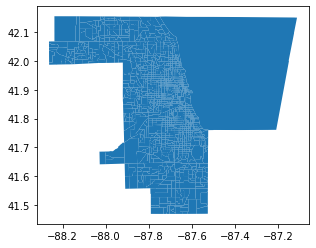

In [138]:
census_tract10_gdf.plot()

<AxesSubplot:>

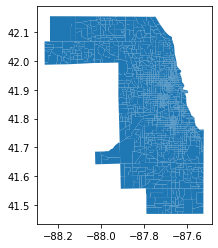

In [139]:
census_tract10_gdf.loc[
    (census_tract10_gdf["AWATER10"] != census_tract10_gdf["AWATER10"].max())
].plot()

In [140]:
census_tract10_gdf = census_tract10_gdf.loc[
    (census_tract10_gdf["AWATER10"] != census_tract10_gdf["AWATER10"].max())
].copy()
census_tract10_gdf = census_tract10_gdf.reset_index(drop=True)

In [141]:
census_tract10_gdf.head(2)

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10  NAME10    NAMELSAD10 MTFCC10  \
0        17        031    010100  17031010100     101  Census Tract   G5020   
1        17        031    010201  17031010201  102.01  Census Tract   G5020   

  FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
0          S   379751         0  +42.0212564  -087.6698316   
1          S   504464         0  +42.0160077  -087.6801484   

                                            geometry  
0  POLYGON ((-87.67720 42.02294, -87.67628 42.022...  
1  POLYGON ((-87.68465 42.01949, -87.68432 42.019...

In [142]:
tract10_gdf = census_tract10_gdf[["GEOID10", "TRACTCE10", "geometry"]].copy()

In [143]:
tract10_gdf.head(2)

GEOID10 TRACTCE10                                           geometry
0  17031010100    010100  POLYGON ((-87.67720 42.02294, -87.67628 42.022...
1  17031010201    010201  POLYGON ((-87.68465 42.01949, -87.68432 42.019...

In [144]:
cc_nbhd_gdf = cc_neighborhood_gdf[["nbhd", "town_nbhd", "township_n", "geometry"]].copy()

In [145]:
cc_nbhd_gdf.head(2)

nbhd town_nbhd township_n                                           geometry
0  060     29060   PALATINE  POLYGON ((-88.00465 42.09562, -88.00467 42.093...
1  120     32120       RICH  POLYGON ((-87.67426 41.49161, -87.67426 41.491...

In [146]:
cc_nbhd_gdf.shape

(846, 4)

In [147]:
len(intersecting_tracts)

5

In [148]:
# intersecting_tracts.columns

Index(['nbhd', 'town_nbhd', 'township_n', 'geometry', 'index_right', 'GEOID10',
       'TRACTCE10'],
      dtype='object')

In [149]:
# intersecting_tracts

nbhd town_nbhd   township_n  \
0  050     17050     EVANSTON   
1  112     17112     EVANSTON   
2  032     75032  ROGERS PARK   
3  033     75033  ROGERS PARK   
4  031     75031  ROGERS PARK   

                                            geometry  index_right  \
0  POLYGON ((-87.67724 42.05119, -87.67726 42.051...            0   
1  POLYGON ((-87.66743 42.02663, -87.66700 42.026...            0   
2  POLYGON ((-87.68465 42.01947, -87.68391 42.019...            0   
3  POLYGON ((-87.66545 42.02288, -87.66509 42.022...            0   
4  POLYGON ((-87.67684 41.99796, -87.68017 42.005...            0   

       GEOID10 TRACTCE10  
0  17031010100    010100  
1  17031010100    010100  
2  17031010100    010100  
3  17031010100    010100  
4  17031010100    010100

In [107]:
# nbhd_cols = ['nbhd', 'town_nbhd', 'township_n', 'GEOID10', 'TRACTCE10']

In [112]:
# intersecting_tracts

nbhd town_nbhd   township_n  \
0  050     17050     EVANSTON   
1  112     17112     EVANSTON   
2  032     75032  ROGERS PARK   
3  033     75033  ROGERS PARK   
4  031     75031  ROGERS PARK   

                                            geometry  index_right  \
0  POLYGON ((-87.67724 42.05119, -87.67726 42.051...            0   
1  POLYGON ((-87.66743 42.02663, -87.66700 42.026...            0   
2  POLYGON ((-87.68465 42.01947, -87.68391 42.019...            0   
3  POLYGON ((-87.66545 42.02288, -87.66509 42.022...            0   
4  POLYGON ((-87.67684 41.99796, -87.68017 42.005...            0   

       GEOID10 TRACTCE10  
0  17031010100    010100  
1  17031010100    010100  
2  17031010100    010100  
3  17031010100    010100  
4  17031010100    010100

In [125]:
tract_geom = tract10_gdf.loc[0:0]
# tract_geom.plot()
cc_nbhd_gdf_geoms = []
intersecting_tracts = cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects").copy()
intersecting_tracts = intersecting_tracts.reset_index(drop=True)

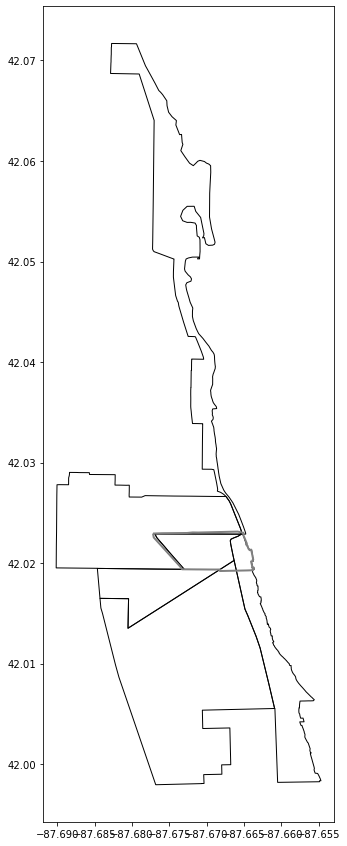

In [127]:
# fig, ax = plt.subplots(figsize=(15,15))

# ax = intersecting_tracts.plot(color="none", linewidth=1, edgecolor="black", ax=ax)
# ax = tract_geom.plot(color="none", linewidth=2, edgecolor="grey", ax=ax)

In [135]:
tract_geom = tract10_gdf.loc[0:0]
# tract_geom.plot()
cc_nbhd_gdf_geoms = []
intersecting_tracts = cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects").copy()
intersecting_tracts = intersecting_tracts.reset_index(drop=True)
for i in range(len(intersecting_tracts)):
    nbhd_geom = intersecting_tracts.loc[i:i].copy()
    tract_nbhd = tract_geom.overlay(nbhd_geom, how="intersection")
    cc_nbhd_gdf_geoms.append(tract_nbhd)
cc_nbhd_gdf_geoms_gdf = pd.concat(cc_nbhd_gdf_geoms)

In [136]:
# cc_nbhd_gdf_geoms_gdf = pd.concat(cc_nbhd_gdf_geoms)
cc_nbhd_gdf_geoms_gdf

GEOID10_1 TRACTCE10_1 nbhd town_nbhd   township_n  index_right  \
0  17031010100      010100  050     17050     EVANSTON            0   
0  17031010100      010100  112     17112     EVANSTON            0   
0  17031010100      010100  032     75032  ROGERS PARK            0   
0  17031010100      010100  033     75033  ROGERS PARK            0   
0  17031010100      010100  031     75031  ROGERS PARK            0   

     GEOID10_2 TRACTCE10_2                                           geometry  
0  17031010100      010100  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
0  17031010100      010100  POLYGON ((-87.67628 42.02297, -87.67597 42.022...  
0  17031010100      010100  MULTIPOLYGON (((-87.66824 42.01937, -87.66849 ...  
0  17031010100      010100  POLYGON ((-87.66511 42.02286, -87.66513 42.022...  
0  17031010100      010100  POLYGON ((-87.66604 42.01925, -87.66648 42.019...

In [121]:
cc_nbhd_gdf_geoms_gdf = cc_nbhd_gdf_geoms_gdf.reset_index(drop=True)

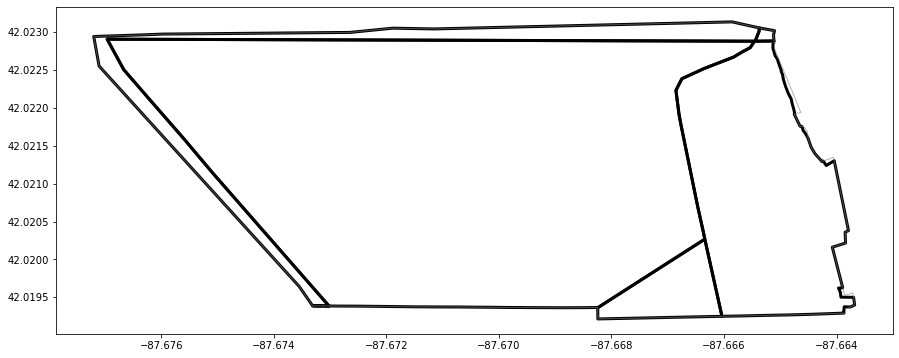

In [130]:
fig, ax = plt.subplots(figsize=(15,15))

ax = cc_nbhd_gdf_geoms_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = tract_geom.plot(color="none", linewidth=1, edgecolor="grey", alpha=0.6, ax=ax)

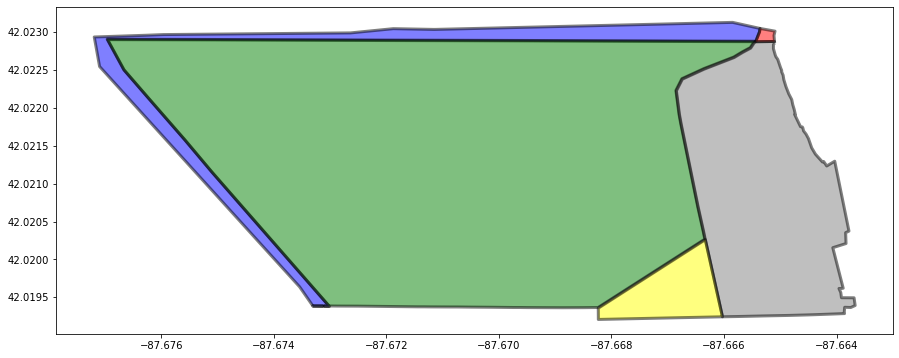

In [132]:
fig, ax = plt.subplots(figsize=(15,15))

ax = cc_nbhd_gdf_geoms_gdf.loc[1:1].plot(color="blue", alpha=0.5, linewidth=3, edgecolor="black", ax=ax)
ax = cc_nbhd_gdf_geoms_gdf.loc[2:2].plot(color="green", alpha=0.5, linewidth=3, edgecolor="black", ax=ax)
ax = cc_nbhd_gdf_geoms_gdf.loc[3:3].plot(color="grey", alpha=0.5, linewidth=3, edgecolor="black", ax=ax)
ax = cc_nbhd_gdf_geoms_gdf.loc[4:4].plot(color="yellow", alpha=0.5, linewidth=3, edgecolor="black", ax=ax)
ax = cc_nbhd_gdf_geoms_gdf.loc[0:0].plot(color="red", alpha=0.5, linewidth=3, edgecolor="black", ax=ax)
# ax = tract_geom.plot(color="none", linewidth=1, edgecolor="grey", alpha=0.6, ax=ax)

In [57]:
intersecting_tracts

nbhd town_nbhd   township_n  \
12   050     17050     EVANSTON   
49   112     17112     EVANSTON   
70   032     75032  ROGERS PARK   
111  033     75033  ROGERS PARK   
115  031     75031  ROGERS PARK   

                                              geometry  index_right  \
12   POLYGON ((-87.67724 42.05119, -87.67726 42.051...            0   
49   POLYGON ((-87.66743 42.02663, -87.66700 42.026...            0   
70   POLYGON ((-87.68465 42.01947, -87.68391 42.019...            0   
111  POLYGON ((-87.66545 42.02288, -87.66509 42.022...            0   
115  POLYGON ((-87.67684 41.99796, -87.68017 42.005...            0   

         GEOID10 TRACTCE10  
12   17031010100    010100  
49   17031010100    010100  
70   17031010100    010100  
111  17031010100    010100  
115  17031010100    010100

In [135]:
tract_geom = tract10_gdf.loc[0:0]
# tract_geom.plot()
cc_nbhd_gdf_geoms = []
intersecting_tracts = cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects").copy()
intersecting_tracts = intersecting_tracts.reset_index(drop=True)
for i in range(len(intersecting_tracts)):
    nbhd_geom = intersecting_tracts.loc[i:i].copy()
    tract_nbhd = tract_geom.overlay(nbhd_geom, how="intersection")
    cc_nbhd_gdf_geoms.append(tract_nbhd)
cc_nbhd_gdf_geoms_gdf = pd.concat(cc_nbhd_gdf_geoms)

In [150]:
all_split_tracts = []
for tract_i in range(len(census_tract10_gdf)):
    tract_geom = census_tract10_gdf.loc[tract_i:tract_i].copy()
    cc_nbhd_gdf_geoms = []
    intersecting_tracts = cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects").copy()
    intersecting_tracts = intersecting_tracts.reset_index(drop=True)
    for i in range(len(intersecting_tracts)):
        nbhd_geom = intersecting_tracts.loc[i:i].copy()
        tract_nbhd = tract_geom.overlay(nbhd_geom, how="intersection")
        cc_nbhd_gdf_geoms.append(tract_nbhd)
    cc_nbhd_gdf_geoms_gdf = pd.concat(cc_nbhd_gdf_geoms)
    all_split_tracts.append(cc_nbhd_gdf_geoms_gdf)

In [152]:
all_split_tracts[0]

STATEFP10_1 COUNTYFP10_1 TRACTCE10_1    GEOID10_1 NAME10_1  NAMELSAD10_1  \
0          17          031      010100  17031010100      101  Census Tract   
0          17          031      010100  17031010100      101  Census Tract   
0          17          031      010100  17031010100      101  Census Tract   
0          17          031      010100  17031010100      101  Census Tract   
0          17          031      010100  17031010100      101  Census Tract   

  MTFCC10_1 FUNCSTAT10_1  ALAND10_1  AWATER10_1 INTPTLAT10_1  INTPTLON10_1  \
0     G5020            S     379751           0  +42.0212564  -087.6698316   
0     G5020            S     379751           0  +42.0212564  -087.6698316   
0     G5020            S     379751           0  +42.0212564  -087.6698316   
0     G5020            S     379751           0  +42.0212564  -087.6698316   
0     G5020            S     379751           0  +42.0212564  -087.6698316   

  nbhd town_nbhd   township_n  index_right STATEFP10_2 COUNTYFP10_2  \
0  050     17050     EVANSTON            0          17          031   
0  112     17112     EVANSTON            0          17          031   
0  032     75032  ROGERS PARK            0          17          031   
0  033     75033  ROGERS PARK            0          17          031   
0  031     75031  ROGERS PARK            0          17          031   

  TRACTCE10_2    GEOID10_2 NAME10_2  NAMELSAD10_2 MTFCC10_2 FUNCSTAT10_2  \
0      010100  17031010100      101  Census Tract     G5020            S   
0      010100  17031010100      101  Census Tract     G5020            S   
0      010100  17031010100      101  Census Tract     G5020            S   
0      010100  17031010100      101  Census Tract     G5020            S   
0      010100  17031010100      101  Census Tract     G5020            S   

   ALAND10_2  AWATER10_2 INTPTLAT10_2  INTPTLON10_2  \
0     379751           0  +42.0212564  -087.6698316   
0     379751           0  +42.0212564  -087.6698316   
0     379751           0  +42.0212564  -087.6698316   
0     379751           0  +42.0212564  -087.6698316   
0     379751           0  +42.0212564  -087.6698316   

                                            geometry  
0  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
0  POLYGON ((-87.67628 42.02297, -87.67597 42.022...  
0  MULTIPOLYGON (((-87.66824 42.01937, -87.66849 ...  
0  POLYGON ((-87.66511 42.02286, -87.66513 42.022...  
0  POLYGON ((-87.66604 42.01925, -87.66648 42.019...

In [153]:
new_gdf = pd.concat(all_split_tracts)
new_gdf = new_gdf.reset_index(drop=True)

In [171]:
if "orig_new_gdf" not in globals().keys():
    print("not in")
    orig_new_gdf = new_gdf.copy()

In [154]:
new_gdf.shape

(5458, 29)

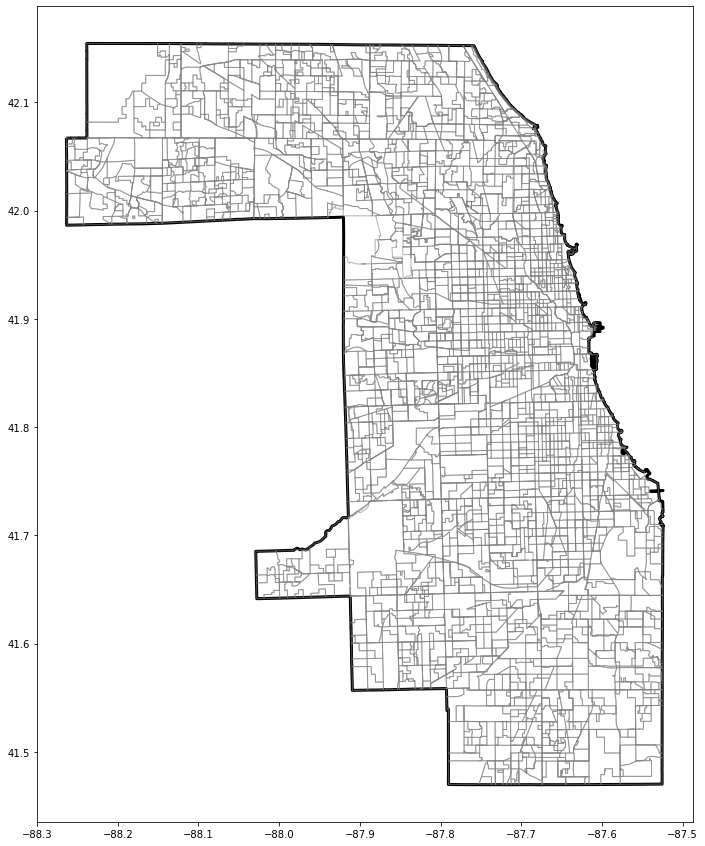

In [155]:
fig, ax = plt.subplots(figsize=(15,15))

# ax = cc_nbhd_gdf_geoms_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = cook_county_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = new_gdf.plot(color="none", linewidth=1, edgecolor="grey", alpha=0.6, ax=ax)

In [157]:
new_gdf.head(2)

STATEFP10_1 COUNTYFP10_1 TRACTCE10_1    GEOID10_1 NAME10_1  NAMELSAD10_1  \
0          17          031      010100  17031010100      101  Census Tract   
1          17          031      010100  17031010100      101  Census Tract   

  MTFCC10_1 FUNCSTAT10_1  ALAND10_1  AWATER10_1 INTPTLAT10_1  INTPTLON10_1  \
0     G5020            S     379751           0  +42.0212564  -087.6698316   
1     G5020            S     379751           0  +42.0212564  -087.6698316   

  nbhd town_nbhd township_n  index_right STATEFP10_2 COUNTYFP10_2 TRACTCE10_2  \
0  050     17050   EVANSTON            0          17          031      010100   
1  112     17112   EVANSTON            0          17          031      010100   

     GEOID10_2 NAME10_2  NAMELSAD10_2 MTFCC10_2 FUNCSTAT10_2  ALAND10_2  \
0  17031010100      101  Census Tract     G5020            S     379751   
1  17031010100      101  Census Tract     G5020            S     379751   

   AWATER10_2 INTPTLAT10_2  INTPTLON10_2  \
0           0  +42.0212564  -087.6698316   
1           0  +42.0212564  -087.6698316   

                                            geometry  
0  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
1  POLYGON ((-87.67628 42.02297, -87.67597 42.022...

In [164]:
new_gdf.loc[
    (new_gdf["TRACTCE10_1"] == new_gdf["TRACTCE10_2"]) & 
    (new_gdf["GEOID10_1"] == new_gdf["GEOID10_2"]) & 
    (new_gdf["NAME10_1"] == new_gdf["NAME10_2"]) & 
    (new_gdf["NAMELSAD10_1"] == new_gdf["NAMELSAD10_2"]) & 
    (new_gdf["MTFCC10_1"] == new_gdf["MTFCC10_2"]) & 
    (new_gdf["FUNCSTAT10_1"] == new_gdf["FUNCSTAT10_2"]) & 
    (new_gdf["ALAND10_1"] == new_gdf["ALAND10_2"]) & 
    (new_gdf["INTPTLAT10_1"] == new_gdf["INTPTLAT10_2"]) & 
    (new_gdf["INTPTLON10_1"] == new_gdf["INTPTLON10_2"]) & 
    (new_gdf["STATEFP10_1"] == new_gdf["STATEFP10_2"]) & 
    (new_gdf["COUNTYFP10_1"] == new_gdf["COUNTYFP10_2"])
].shape[0] == new_gdf.shape[0]

True

In [173]:
drop_cols = [col for col in new_gdf.columns if col.endswith("_2")]
new_gdf = new_gdf.drop(columns=drop_cols)

In [174]:
new_gdf.head(2)

STATEFP10_1 COUNTYFP10_1 TRACTCE10_1    GEOID10_1 NAME10_1  NAMELSAD10_1  \
0          17          031      010100  17031010100      101  Census Tract   
1          17          031      010100  17031010100      101  Census Tract   

  MTFCC10_1 FUNCSTAT10_1  ALAND10_1  AWATER10_1 INTPTLAT10_1  INTPTLON10_1  \
0     G5020            S     379751           0  +42.0212564  -087.6698316   
1     G5020            S     379751           0  +42.0212564  -087.6698316   

  nbhd town_nbhd township_n  index_right  \
0  050     17050   EVANSTON            0   
1  112     17112   EVANSTON            0   

                                            geometry  
0  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
1  POLYGON ((-87.67628 42.02297, -87.67597 42.022...

In [176]:
new_gdf.columns = [col.replace("_1", "") for col in new_gdf.columns]

In [177]:
new_gdf = new_gdf.drop(columns=["index_right"])

In [178]:
new_gdf.head(2)

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10    NAMELSAD10 MTFCC10  \
0        17        031    010100  17031010100    101  Census Tract   G5020   
1        17        031    010100  17031010100    101  Census Tract   G5020   

  FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10 nbhd town_nbhd  \
0          S   379751         0  +42.0212564  -087.6698316  050     17050   
1          S   379751         0  +42.0212564  -087.6698316  112     17112   

  township_n                                           geometry  
0   EVANSTON  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
1   EVANSTON  POLYGON ((-87.67628 42.02297, -87.67597 42.022...

In [179]:
new_gdf.shape

(5458, 16)

In [180]:
new_gdf["geometry"].nunique()

5458

In [181]:
cook_county_gdf = utils.get_cook_county_boundary_gdf()
cook_county_gdf = cook_county_gdf.to_crs(cc_neighborhood_gdf.crs)

In [14]:
# cc_neighborhood_gdf["neighborhood_representative_point"] = cc_neighborhood_gdf.geometry.representative_point()

In [13]:
cc_neighborhood_gdf = utils.get_clean_cc_residential_neighborhood_geodata()
cc_neighborhood_gdf = cc_neighborhood_gdf.drop_duplicates(ignore_index=True)
cc_neighborhood_gdf["township_n"] = cc_neighborhood_gdf["township_n"].str.upper()
cc_nbhd_gdf = cc_neighborhood_gdf[["nbhd", "town_nbhd", "township_n", "geometry"]].copy()

(846, 7)

In [140]:
census_tract10_gdf = utils.get_2010_cook_county_census_tract_gdf()
census_tract10_gdf = census_tract10_gdf.to_crs(cc_neighborhood_gdf.crs)
census_tract10_gdf = census_tract10_gdf.loc[
    (census_tract10_gdf["AWATER10"] != census_tract10_gdf["AWATER10"].max())
].copy()
census_tract10_gdf = census_tract10_gdf.reset_index(drop=True)

In [ ]:
all_split_tracts = []
for tract_i in range(len(census_tract10_gdf)):
    tract_geom = census_tract10_gdf.loc[tract_i:tract_i].copy()
    cc_nbhd_gdf_geoms = []
    intersecting_tracts = cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects").copy()
    intersecting_tracts = intersecting_tracts.reset_index(drop=True)
    for i in range(len(intersecting_tracts)):
        nbhd_geom = intersecting_tracts.loc[i:i].copy()
        tract_nbhd = tract_geom.overlay(nbhd_geom, how="intersection")
        cc_nbhd_gdf_geoms.append(tract_nbhd)
    cc_nbhd_gdf_geoms_gdf = pd.concat(cc_nbhd_gdf_geoms)
    all_split_tracts.append(cc_nbhd_gdf_geoms_gdf)

In [ ]:
new_gdf = pd.concat(all_split_tracts)
new_gdf = new_gdf.reset_index(drop=True)
new_gdf.loc[
    (new_gdf["TRACTCE10_1"] == new_gdf["TRACTCE10_2"]) & 
    (new_gdf["GEOID10_1"] == new_gdf["GEOID10_2"]) & 
    (new_gdf["NAME10_1"] == new_gdf["NAME10_2"]) & 
    (new_gdf["NAMELSAD10_1"] == new_gdf["NAMELSAD10_2"]) & 
    (new_gdf["MTFCC10_1"] == new_gdf["MTFCC10_2"]) & 
    (new_gdf["FUNCSTAT10_1"] == new_gdf["FUNCSTAT10_2"]) & 
    (new_gdf["ALAND10_1"] == new_gdf["ALAND10_2"]) & 
    (new_gdf["INTPTLAT10_1"] == new_gdf["INTPTLAT10_2"]) & 
    (new_gdf["INTPTLON10_1"] == new_gdf["INTPTLON10_2"]) & 
    (new_gdf["STATEFP10_1"] == new_gdf["STATEFP10_2"]) & 
    (new_gdf["COUNTYFP10_1"] == new_gdf["COUNTYFP10_2"])
].shape[0] == new_gdf.shape[0]
drop_cols = [col for col in new_gdf.columns if col.endswith("_2")]
new_gdf = new_gdf.drop(columns=drop_cols)
new_gdf.columns = [col.replace("_1", "") for col in new_gdf.columns]
new_gdf = new_gdf.drop(columns=["index_right", "ALAND10", "AWATER10", "NAMELSAD10", "FUNCSTAT10", "MTFCC10"])

In [187]:
new_gdf.head(2)

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10 MTFCC10   INTPTLAT10  \
0        17        031    010100  17031010100    101   G5020  +42.0212564   
1        17        031    010100  17031010100    101   G5020  +42.0212564   

     INTPTLON10 nbhd town_nbhd township_n  \
0  -087.6698316  050     17050   EVANSTON   
1  -087.6698316  112     17112   EVANSTON   

                                            geometry  
0  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
1  POLYGON ((-87.67628 42.02297, -87.67597 42.022...

In [194]:
cat_cols = [
    "STATEFP10", "COUNTYFP10", "TRACTCE10", "GEOID10",
    "NAME10", "nbhd", "town_nbhd", "township_n"
]
for cat_col in cat_cols:
    new_gdf[cat_col] = new_gdf[cat_col].astype("category")

In [195]:
new_gdf["INTPTLAT10"] = new_gdf["INTPTLAT10"].astype(float)
new_gdf["INTPTLON10"] = new_gdf["INTPTLON10"].astype(float)

In [ ]:
os.path.join("")

(846, 7)

In [ ]:
cc_neighborhood_gdf = utils.get_clean_cc_residential_neighborhood_geodata()
cc_neighborhood_gdf = cc_neighborhood_gdf.drop_duplicates(ignore_index=True)
cc_neighborhood_gdf["township_n"] = cc_neighborhood_gdf["township_n"].str.upper()
cc_nbhd_gdf = cc_neighborhood_gdf[["nbhd", "town_nbhd", "township_n", "geometry"]].copy()

census_tract10_gdf = utils.get_2010_cook_county_census_tract_gdf()
census_tract10_gdf = census_tract10_gdf.to_crs(cc_neighborhood_gdf.crs)
census_tract10_gdf = census_tract10_gdf.loc[
    (census_tract10_gdf["AWATER10"] != census_tract10_gdf["AWATER10"].max())
].copy()
census_tract10_gdf = census_tract10_gdf.reset_index(drop=True)

all_split_tracts = []
for tract_i in range(len(census_tract10_gdf)):
    tract_geom = census_tract10_gdf.loc[tract_i:tract_i].copy()
    cc_nbhd_gdf_geoms = []
    intersecting_tracts = cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects").copy()
    intersecting_tracts = intersecting_tracts.reset_index(drop=True)
    for i in range(len(intersecting_tracts)):
        nbhd_geom = intersecting_tracts.loc[i:i].copy()
        tract_nbhd = tract_geom.overlay(nbhd_geom, how="intersection")
        cc_nbhd_gdf_geoms.append(tract_nbhd)
    cc_nbhd_gdf_geoms_gdf = pd.concat(cc_nbhd_gdf_geoms)
    all_split_tracts.append(cc_nbhd_gdf_geoms_gdf)
    
new_gdf = pd.concat(all_split_tracts)
new_gdf = new_gdf.reset_index(drop=True)
new_gdf.loc[
    (new_gdf["TRACTCE10_1"] == new_gdf["TRACTCE10_2"]) & 
    (new_gdf["GEOID10_1"] == new_gdf["GEOID10_2"]) & 
    (new_gdf["NAME10_1"] == new_gdf["NAME10_2"]) & 
    (new_gdf["NAMELSAD10_1"] == new_gdf["NAMELSAD10_2"]) & 
    (new_gdf["MTFCC10_1"] == new_gdf["MTFCC10_2"]) & 
    (new_gdf["FUNCSTAT10_1"] == new_gdf["FUNCSTAT10_2"]) & 
    (new_gdf["ALAND10_1"] == new_gdf["ALAND10_2"]) & 
    (new_gdf["INTPTLAT10_1"] == new_gdf["INTPTLAT10_2"]) & 
    (new_gdf["INTPTLON10_1"] == new_gdf["INTPTLON10_2"]) & 
    (new_gdf["STATEFP10_1"] == new_gdf["STATEFP10_2"]) & 
    (new_gdf["COUNTYFP10_1"] == new_gdf["COUNTYFP10_2"])
].shape[0] == new_gdf.shape[0]
drop_cols = [col for col in new_gdf.columns if col.endswith("_2")]
new_gdf = new_gdf.drop(columns=drop_cols)
new_gdf.columns = [col.replace("_1", "") for col in new_gdf.columns]
new_gdf = new_gdf.drop(columns=["index_right", "ALAND10", "AWATER10", "NAMELSAD10", "FUNCSTAT10", "MTFCC10"])

cat_cols = [
    "STATEFP10", "COUNTYFP10", "TRACTCE10", "GEOID10",
    "NAME10", "nbhd", "town_nbhd", "township_n"
]
for cat_col in cat_cols:
    new_gdf[cat_col] = new_gdf[cat_col].astype("category")
    
new_gdf["INTPTLAT10"] = new_gdf["INTPTLAT10"].astype(float)
new_gdf["INTPTLON10"] = new_gdf["INTPTLON10"].astype(float)

In [197]:
def split_cc_census_tracts_by_neighborhood() -> gpd.GeoDataFrame:
    cc_neighborhood_gdf = utils.get_clean_cc_residential_neighborhood_geodata()
    cc_neighborhood_gdf = cc_neighborhood_gdf.drop_duplicates(ignore_index=True)
    cc_neighborhood_gdf["township_n"] = cc_neighborhood_gdf["township_n"].str.upper()
    cc_nbhd_gdf = cc_neighborhood_gdf[["nbhd", "town_nbhd", "township_n", "geometry"]].copy()
    
    census_tract10_gdf = utils.get_2010_cook_county_census_tract_gdf()
    census_tract10_gdf = census_tract10_gdf.to_crs(cc_neighborhood_gdf.crs)
    census_tract10_gdf = census_tract10_gdf.loc[
        (census_tract10_gdf["AWATER10"] != census_tract10_gdf["AWATER10"].max())
    ].copy()
    census_tract10_gdf = census_tract10_gdf.reset_index(drop=True)
    
    all_split_tracts = []
    for tract_i in range(len(census_tract10_gdf)):
        tract_geom = census_tract10_gdf.loc[tract_i:tract_i].copy()
        cc_nbhd_gdf_geoms = []
        intersecting_tracts = cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects").copy()
        intersecting_tracts = intersecting_tracts.reset_index(drop=True)
        for i in range(len(intersecting_tracts)):
            nbhd_geom = intersecting_tracts.loc[i:i].copy()
            tract_nbhd = tract_geom.overlay(nbhd_geom, how="intersection")
            cc_nbhd_gdf_geoms.append(tract_nbhd)
        cc_nbhd_gdf_geoms_gdf = pd.concat(cc_nbhd_gdf_geoms)
        all_split_tracts.append(cc_nbhd_gdf_geoms_gdf)
        
    new_gdf = pd.concat(all_split_tracts)
    new_gdf = new_gdf.reset_index(drop=True)
    assert new_gdf.loc[
        (new_gdf["TRACTCE10_1"] == new_gdf["TRACTCE10_2"]) & 
        (new_gdf["GEOID10_1"] == new_gdf["GEOID10_2"]) & 
        (new_gdf["NAME10_1"] == new_gdf["NAME10_2"]) & 
        (new_gdf["NAMELSAD10_1"] == new_gdf["NAMELSAD10_2"]) & 
        (new_gdf["MTFCC10_1"] == new_gdf["MTFCC10_2"]) & 
        (new_gdf["FUNCSTAT10_1"] == new_gdf["FUNCSTAT10_2"]) & 
        (new_gdf["ALAND10_1"] == new_gdf["ALAND10_2"]) & 
        (new_gdf["INTPTLAT10_1"] == new_gdf["INTPTLAT10_2"]) & 
        (new_gdf["INTPTLON10_1"] == new_gdf["INTPTLON10_2"]) & 
        (new_gdf["STATEFP10_1"] == new_gdf["STATEFP10_2"]) & 
        (new_gdf["COUNTYFP10_1"] == new_gdf["COUNTYFP10_2"])
    ].shape[0] == new_gdf.shape[0]
    drop_cols = [col for col in new_gdf.columns if col.endswith("_2")]
    new_gdf = new_gdf.drop(columns=drop_cols)
    new_gdf.columns = [col.replace("_1", "") for col in new_gdf.columns]
    new_gdf = new_gdf.drop(columns=["index_right", "ALAND10", "AWATER10", "NAMELSAD10", "FUNCSTAT10", "MTFCC10"])
    
    cat_cols = [
        "STATEFP10", "COUNTYFP10", "TRACTCE10", "GEOID10",
        "NAME10", "nbhd", "town_nbhd", "township_n"
    ]
    for cat_col in cat_cols:
        new_gdf[cat_col] = new_gdf[cat_col].astype("category")
        
    new_gdf["INTPTLAT10"] = new_gdf["INTPTLAT10"].astype(float)
    new_gdf["INTPTLON10"] = new_gdf["INTPTLON10"].astype(float)
    return new_gdf

In [199]:
file_dir = os.path.join(
    os.path.expanduser("~"),
    "projects",
    "cook_county_real_estate",
    "data_clean",
)
clean_file_path = os.path.join(
    file_dir, "cc_census_tracts_split_by_neighborhood_boundaries.parquet.gzip"
)
clean_file_path
new_gdf.to_parquet(clean_file_path, compression="gzip")

/tmp/ipykernel_111098/2759185481.py:11: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  new_gdf.to_parquet(clean_file_path, compression="gzip")


In [187]:
new_gdf.head(2)

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10 MTFCC10   INTPTLAT10  \
0        17        031    010100  17031010100    101   G5020  +42.0212564   
1        17        031    010100  17031010100    101   G5020  +42.0212564   

     INTPTLON10 nbhd town_nbhd township_n  \
0  -087.6698316  050     17050   EVANSTON   
1  -087.6698316  112     17112   EVANSTON   

                                            geometry  
0  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
1  POLYGON ((-87.67628 42.02297, -87.67597 42.022...

In [200]:
def get_cc_census_tracts_split_by_neighborhood_geodata(
    clean_file_path: Union[str, bool] = None,
    force_reclean: bool = False,
    force_repull: bool = False,
) -> gpd.GeoDataFrame:
    if clean_file_path is None:
        file_dir = os.path.join(
            os.path.expanduser("~"),
            "projects",
            "cook_county_real_estate",
            "data_clean",
        )
        clean_file_path = os.path.join(
            file_dir, "cc_census_tracts_split_by_neighborhood_boundaries.parquet.gzip"
        )
    if (
        os.path.isfile(clean_file_path)
        and not force_reclean
        and not force_repull
    ):
        gdf = gpd.read_parquet(clean_file_path)
        return gdf
    else:
        gdf = split_cc_census_tracts_by_neighborhood()
    gdf.to_parquet(clean_file_path, compression="gzip")
    return gdf

In [201]:
check_gdf = get_cc_census_tracts_split_by_neighborhood_geodata()

In [202]:
check_gdf.head(2)

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10  INTPTLAT10  INTPTLON10  \
0        17        031    010100  17031010100    101   42.021256  -87.669832   
1        17        031    010100  17031010100    101   42.021256  -87.669832   

  nbhd town_nbhd township_n                                           geometry  
0  050     17050   EVANSTON  POLYGON ((-87.66537 42.02305, -87.66531 42.023...  
1  112     17112   EVANSTON  POLYGON ((-87.67628 42.02297, -87.67597 42.022...

<AxesSubplot:>

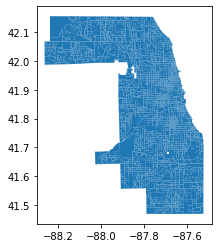

In [203]:
check_gdf.plot()

In [205]:
check_gdf["rep_point"] = check_gdf.geometry.representative_point()

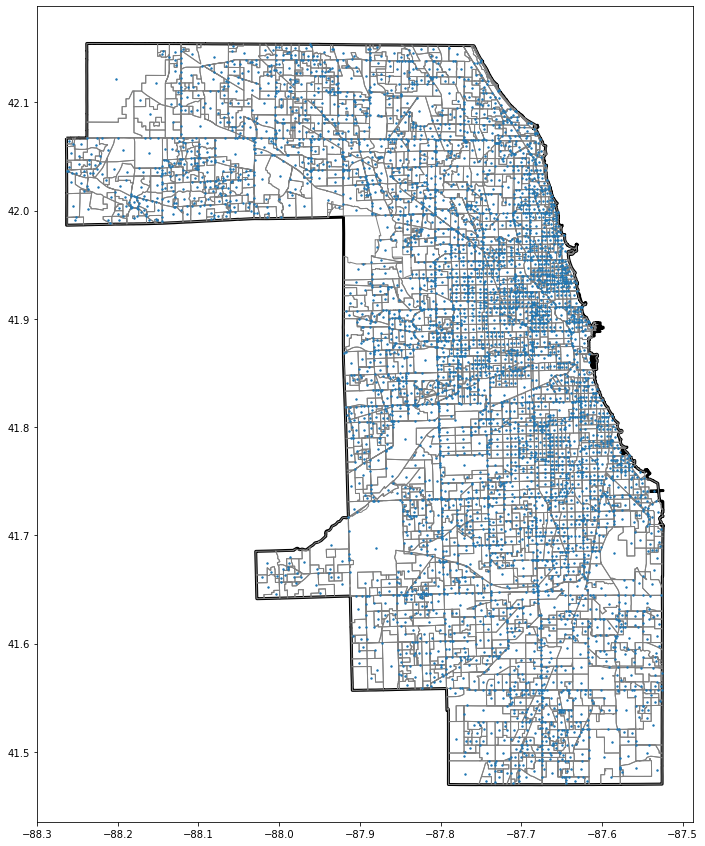

In [206]:
fig, ax = plt.subplots(figsize=(15,15))

ax = cook_county_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = check_gdf.plot(color="none", linewidth=1, edgecolor="grey", ax=ax)
ax = check_gdf["rep_point"].plot(markersize=2, ax=ax)

In [ ]:
check_gdf

In [196]:
new_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5458 entries, 0 to 5457
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   5458 non-null   category
 1   COUNTYFP10  5458 non-null   category
 2   TRACTCE10   5458 non-null   category
 3   GEOID10     5458 non-null   category
 4   NAME10      5458 non-null   category
 5   INTPTLAT10  5458 non-null   float64 
 6   INTPTLON10  5458 non-null   float64 
 7   nbhd        5458 non-null   category
 8   town_nbhd   5458 non-null   category
 9   township_n  5458 non-null   category
 10  geometry    5458 non-null   geometry
dtypes: category(8), float64(2), geometry(1)
memory usage: 371.2 KB


In [193]:
new_gdf.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'INTPTLAT10', 'INTPTLON10', 'nbhd', 'town_nbhd', 'township_n',
       'geometry'],
      dtype='object')

In [192]:
utils.get_df_column_details(new_gdf)

feature  unique_vals  pct_unique  null_vals  pct_null
0    STATEFP10            1      0.0183          0       0.0
1   COUNTYFP10            1      0.0183          0       0.0
2   township_n           38      0.6962          0       0.0
3         nbhd          196      3.5911          0       0.0
4    town_nbhd          845     15.4819          0       0.0
5    TRACTCE10         1318     24.1480          0       0.0
6      GEOID10         1318     24.1480          0       0.0
7       NAME10         1318     24.1480          0       0.0
8   INTPTLAT10         1318     24.1480          0       0.0
9   INTPTLON10         1318     24.1480          0       0.0
10    geometry         5458    100.0000          0       0.0

In [ ]:
def get_clean_cc_residential_neighborhood_geodata(
    clean_file_path: Union[str, bool] = None,
    raw_file_path: Union[str, bool] = None,
    force_reclean: bool = False,
    force_repull: bool = False,
) -> gpd.GeoDataFrame:
    if clean_file_path is None:
        file_dir = os.path.join(
            os.path.expanduser("~"),
            "projects",
            "cook_county_real_estate",
            "data_clean",
        )
        clean_file_path = os.path.join(
            file_dir, "cc_residential_neighborhood_boundaries.parquet.gzip"
        )
    if (
        os.path.isfile(clean_file_path)
        and not force_reclean
        and not force_repull
    ):
        gdf = gpd.read_parquet(clean_file_path)
        return gdf
    elif force_reclean and not force_repull:
        gdf = clean_cc_residential_neighborhood_geodata(
            raw_file_path=raw_file_path
        )
    else:
        gdf = clean_cc_residential_neighborhood_geodata(
            raw_file_path=raw_file_path, force_repull=force_repull
        )
    gdf.to_parquet(clean_file_path, compression="gzip")
    return gdf

In [51]:
cc_nbhd_gdf.sjoin(tract_geom, how="inner", predicate="intersects")

nbhd town_nbhd   township_n  \
12   050     17050     EVANSTON   
49   112     17112     EVANSTON   
70   032     75032  ROGERS PARK   
111  033     75033  ROGERS PARK   
115  031     75031  ROGERS PARK   

                                              geometry  index_right  \
12   POLYGON ((-87.67724 42.05119, -87.67726 42.051...            0   
49   POLYGON ((-87.66743 42.02663, -87.66700 42.026...            0   
70   POLYGON ((-87.68465 42.01947, -87.68391 42.019...            0   
111  POLYGON ((-87.66545 42.02288, -87.66509 42.022...            0   
115  POLYGON ((-87.67684 41.99796, -87.68017 42.005...            0   

         GEOID10 TRACTCE10  
12   17031010100    010100  
49   17031010100    010100  
70   17031010100    010100  
111  17031010100    010100  
115  17031010100    010100

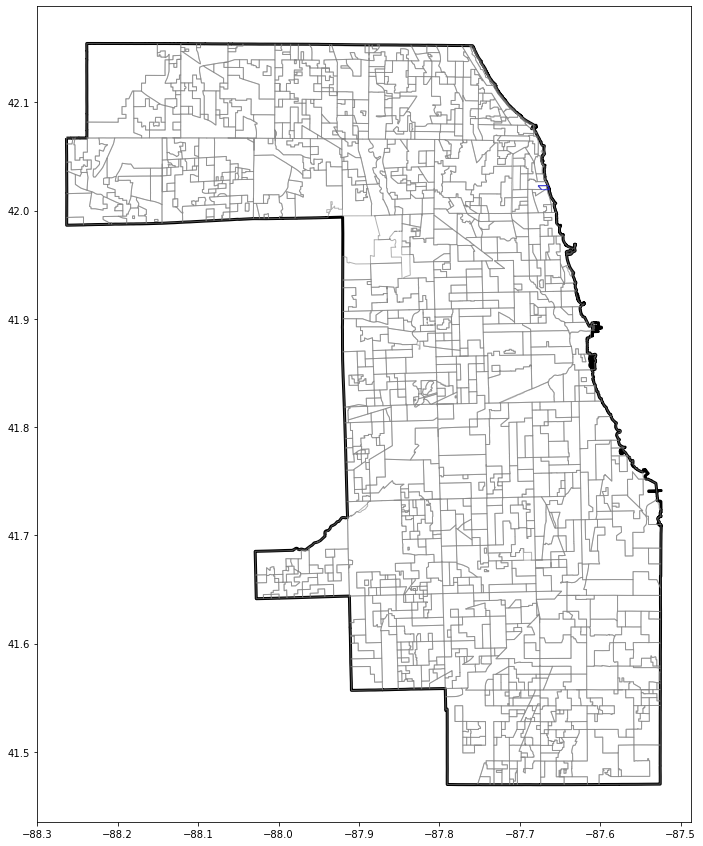

In [50]:
fig, ax = plt.subplots(figsize=(15,15))

ax = cook_county_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = cc_nbhd_gdf.plot(color="none", linewidth=1, edgecolor="grey", alpha=0.6, ax=ax)
ax = tract_geom.plot(color="none", linewidth=1, edgecolor="blue", alpha=0.6, ax=ax)

In [ ]:
# index_parts=False, keep_geom_type=False

In [38]:
# temp_gdf = cook_county_gdf.overlay(census_tract10_gdf, how="union").explode().reset_index(drop=True)

In [35]:
temp_gdf.shape

(1972, 17)

In [31]:
temp_gdf.head(2)

OBJECTID_1  AREA    SHAPE_Leng    SHAPE_Area STATEFP10 COUNTYFP10  \
0         1.0   0.0  1.022267e+06  2.670051e+10        17        031   
1         1.0   0.0  1.022267e+06  2.670051e+10        17        031   

  TRACTCE10      GEOID10  NAME10    NAMELSAD10 MTFCC10 FUNCSTAT10   ALAND10  \
0    010100  17031010100     101  Census Tract   G5020          S  379751.0   
1    010201  17031010201  102.01  Census Tract   G5020          S  504464.0   

   AWATER10   INTPTLAT10    INTPTLON10  \
0       0.0  +42.0212564  -087.6698316   
1       0.0  +42.0160077  -087.6801484   

                                            geometry  
0  POLYGON ((-87.66512 42.02295, -87.66514 42.022...  
1  POLYGON ((-87.68432 42.01948, -87.68390 42.019...

<AxesSubplot:>

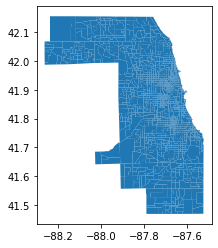

In [27]:
temp_gdf.explode(index_parts=False).plot()

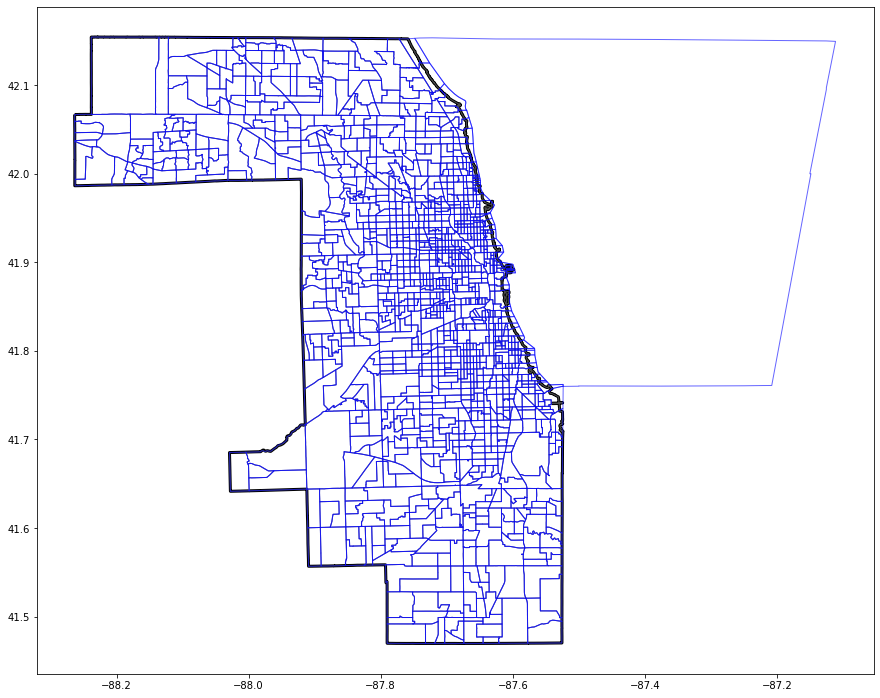

In [23]:
fig, ax = plt.subplots(figsize=(15,15))

ax = cook_county_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = temp_gdf.plot(color="none", linewidth=1, edgecolor="grey", alpha=0.6, ax=ax)
ax = census_tract10_gdf.plot(color="none", linewidth=1, edgecolor="blue", alpha=0.6, ax=ax)


In [19]:
census_tract10_gdf.shape

(1319, 13)

In [20]:
census_tract10_gdf["COUNTYFP10"].value_counts(dropna=False)

031    1319
Name: COUNTYFP10, dtype: int64

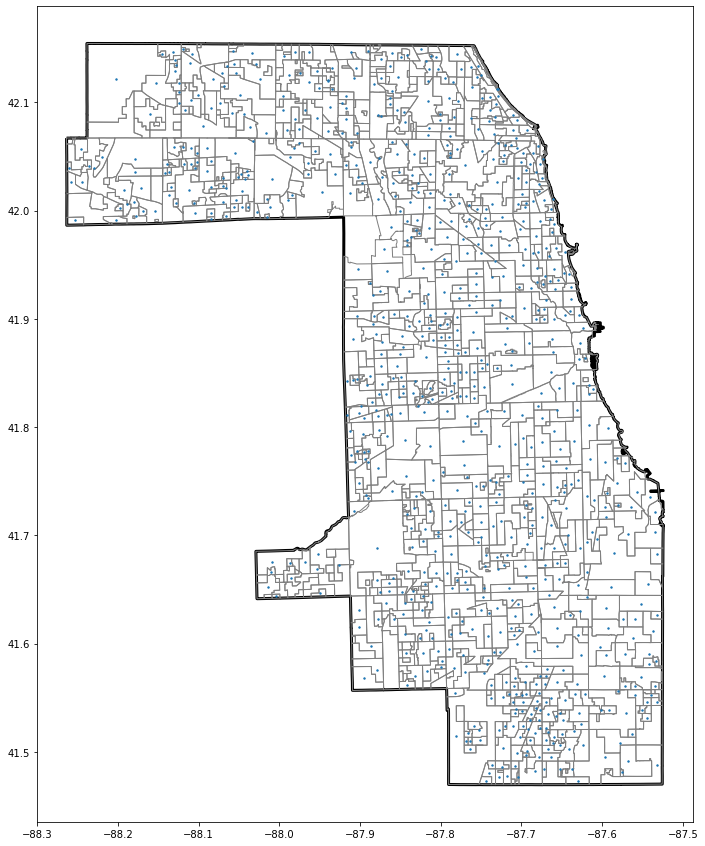

In [24]:
fig, ax = plt.subplots(figsize=(15,15))

ax = cook_county_gdf.plot(color="none", linewidth=3, edgecolor="black", ax=ax)
ax = cc_neighborhood_gdf.plot(color="none", linewidth=1, edgecolor="grey", ax=ax)
ax = cc_neighborhood_gdf["neighborhood_representative_point"].plot(markersize=2, ax=ax)

In [8]:
def get_cook_county_boundary_gdf(
    raw_file_path: Union[str, None] = None, force_repull: bool = False
) -> gpd.GeoDataFrame:
    # Not sure how durable the url 
    # 'https://hub-cookcountyil.opendata.arcgis.com/datasets/ea127f9e96b74677892722069c984198_1/explore'
    # is, but I can deal with that if/when I have to.
    gdf = utils.get_gdf_of_data_portal_data(
        file_name="cook_county_boundary_from_opendata.parquet.gzip",
        url="https://opendata.arcgis.com/api/v3/datasets/ea127f9e96b74677892722069c984198_1/downloads/data?format=shp&spatialRefId=3435",
        raw_file_path=raw_file_path,
        force_repull=force_repull,
    )
    return gdf

In [11]:
cook_county_gdf.crs

<Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

EPSG 3435 is a good coordinate reference system to use if you want to calculate accurate distances/areas in eastern Illinois. As the numbers on the x and y axes in the map of the Cook Country boundary show, this projection is not in degrees, rather it's in feet from the `Longitude == 0` and `Latitude == 0` lines (respectively).

However, for applications where producing maps for the web is more important, EPSG 4326 (for example, the `Latitude` and `Longitude` point coordinates for the property characteristics are in EPSG 4326, aka WSG 84).

<AxesSubplot:ylabel='Frequency'>

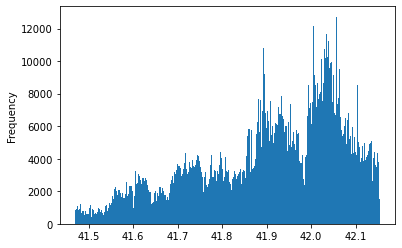

In [12]:
(cc_res_prop_char_df["Latitude"]).plot.hist(bins=500)

Ok, the bulk of properties in this Cook County data set appear to be further north and further east. That makes sense as Cook County's geometry is much wider on the north end, and high-density Chicago is on the east end.

<AxesSubplot:ylabel='Frequency'>

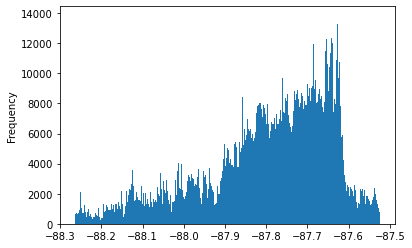

In [13]:
(cc_res_prop_char_df["Longitude"]).plot.hist(bins=500)

In [14]:
null_lat_mask = cc_res_prop_char_df["Latitude"].isnull()
null_long_mask = cc_res_prop_char_df["Longitude"].isnull()

In [15]:
print(f"Records with a null 'Latitude' value:  {null_lat_mask.sum()}")
print(f"Records with a null 'Longitude' value: {null_long_mask.sum()}")
print(f"Records with null 'Latitude' OR 'Longitude' values: {(null_lat_mask | null_long_mask).sum()}")

Records with a null 'Latitude' value:  4023
Records with a null 'Longitude' value: 4023
Records with null 'Latitude' OR 'Longitude' values: 4023


In [16]:
cc_res_prop_char_df.loc[
    (null_lat_mask | null_long_mask),
    "Property Address"
].isnull().sum()

3192

In [17]:
cc_res_prop_char_df.loc[
    (null_lat_mask | null_long_mask),
    "Property Address"
]

183228     4953  OAKTON ST
183241     5001  OAKTON ST
183358     4953  OAKTON ST
183371     4953  OAKTON ST
183384     4953  OAKTON ST
                ...       
1954515               <NA>
1964045               <NA>
1972922               <NA>
1972923               <NA>
1977008               <NA>
Name: Property Address, Length: 4023, dtype: string

In [18]:
cc_res_prop_char_no_latlong_df = cc_res_prop_char_df.loc[
    (null_lat_mask | null_long_mask)
].copy()
cc_res_prop_char_no_latlong_df = cc_res_prop_char_no_latlong_df.reset_index(drop=True)
cc_res_prop_char_no_latlong_df

PIN Property Class  Tax Year Neighborhood Code  \
0     10282010341140            299      2019               031   
1     10282010341077            299      2019               031   
2     10282010341030            299      2019               031   
3     10282010341134            299      2019               031   
4     10282010341013            299      2019               031   
...              ...            ...       ...               ...   
4018  31233020230000            204      2019               130   
4019  31363030360000            205      2019               120   
4020  32101040060000            295      2019               033   
4021  32101040070000            295      2019               033   
4022  32183050310000            203      2019               081   

      Land Square Feet Town Code  \
0                28443        24   
1                28443        24   
2                28443        24   
3                28443        24   
4                28443        24   
...                ...       ...   
4018              5191        32   
4019              8256        32   
4020              5894        12   
4021              5857        12   
4022             47300        12   

                                      Type of Residence  Apartments  \
0                                                   NaN        <NA>   
1                                                   NaN        <NA>   
2                                                   NaN        <NA>   
3                                                   NaN        <NA>   
4                                                   NaN        <NA>   
...                                                 ...         ...   
4018  1.5 story (one story w/ partial livable attic;...           0   
4019                                          two story           0   
4020                                          one story           0   
4021                                          one story           0   
4022                                          one story           0   

         Wall Material    Roof Material  Rooms  Bedrooms Basement  \
0                  NaN              NaN   <NA>      <NA>      NaN   
1                  NaN              NaN   <NA>      <NA>      NaN   
2                  NaN              NaN   <NA>      <NA>      NaN   
3                  NaN              NaN   <NA>      <NA>      NaN   
4                  NaN              NaN   <NA>      <NA>      NaN   
...                ...              ...    ...       ...      ...   
4018              Wood  Shingle/Asphalt      7         4     Full   
4019  Wood and Masonry  Shingle/Asphalt      8         4     Slab   
4020           Masonry  Shingle/Asphalt      6         2     Full   
4021           Masonry  Shingle/Asphalt      6         2     Full   
4022              Wood  Shingle/Asphalt      5         3     Full   

     Basement Finish Central Heating Other Heating  Central Air  Fireplaces  \
0                NaN             NaN           NaN         <NA>        <NA>   
1                NaN             NaN           NaN         <NA>        <NA>   
2                NaN             NaN           NaN         <NA>        <NA>   
3                NaN             NaN           NaN         <NA>        <NA>   
4                NaN             NaN           NaN         <NA>        <NA>   
...              ...             ...           ...          ...         ...   
4018      Unfinished        Warm air          none         True           1   
4019      Unfinished        Warm air          none         True           2   
4020      Unfinished        Warm air          none         True           1   
4021      Unfinished        Warm air          none         True           1   
4022      Unfinished        Warm air          none         True           1   

     Attic Type Attic Finish  Half Baths Design Plan Cathedral Ceiling  \
0           NaN     No Attic        <NA>         NaN               NaN   


In [22]:
outpath = os.path.join(
    os.path.expanduser("~"), 
    "projects",
    "postgis_geocoder", 
    "misc_data",
    "cook_county_residential_property_data_no_latlongs.parquet.gzip"
)
cc_res_prop_char_no_latlong_df.to_parquet(outpath, compression="gzip")

In [30]:
neighborhoods_gdf = utils.get_raw_cc_residential_neighborhood_geodata()

In [43]:
neighborhoods_gdf.head(2)

nbhd town_nbhd township_c township_n triad_code triad_name  \
0  060     29060         29   Palatine          2      North   
1  120     32120         32       Rich          3      South   

                                            geometry  
0  POLYGON ((-88.00465 42.09562, -88.00467 42.093...  
1  POLYGON ((-87.67426 41.49161, -87.67426 41.491...

In [31]:
neighborhoods_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

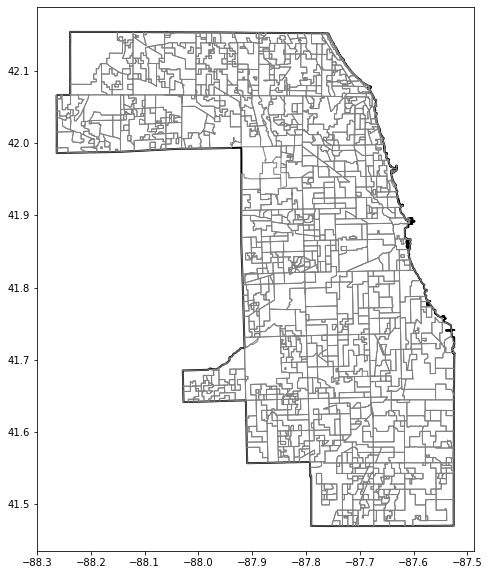

In [33]:
fig, base = plt.subplots(figsize=(10,10))

ax = cook_county_gdf.plot(color='none', edgecolor='black', linewidth=2, ax=base)
ax = neighborhoods_gdf.plot(color='none', edgecolor='grey', linewidth=1, ax=ax)

In [16]:
cc_res_prop_char_df["Latitude"] = cc_res_prop_char_df["Latitude"].astype("float")
cc_res_prop_char_df["Longitude"] = cc_res_prop_char_df["Longitude"].astype("float")
cc_res_prop_char_df['geometry'] = cc_res_prop_char_df.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
cc_res_prop_char_gdf = gpd.GeoDataFrame(cc_res_prop_char_df, crs='EPSG:4326')

In [17]:
cc_res_prop_char_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
cook_county_gdf = cook_county_gdf.to_crs(cc_res_prop_char_gdf.crs)

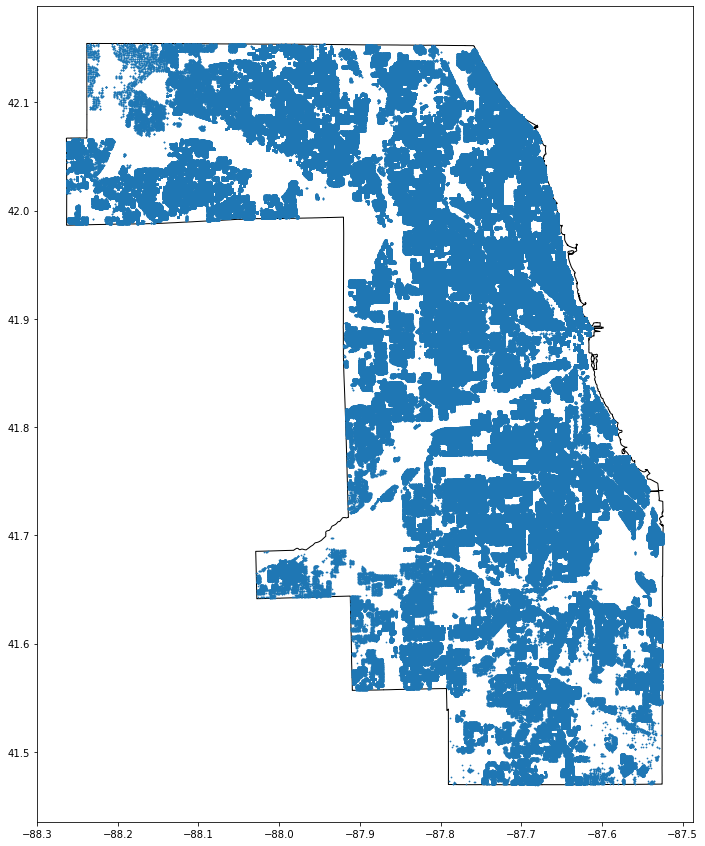

In [19]:
fig_width = 15
fig, base = plt.subplots(figsize=(fig_width, fig_width))
ax = cook_county_gdf.plot(color="none", ax=base)
ax = cc_res_prop_char_gdf.plot(markersize=0.5, ax=ax)

### O'Hare Noise
* Indicator for the property under O'Hare approach flight path, within 1/4 mile.

In [20]:
cc_res_prop_char_gdf["O'Hare Noise"].value_counts(dropna=False)

0      1955862
1        35223
NaN       4023
Name: O'Hare Noise, dtype: Int64

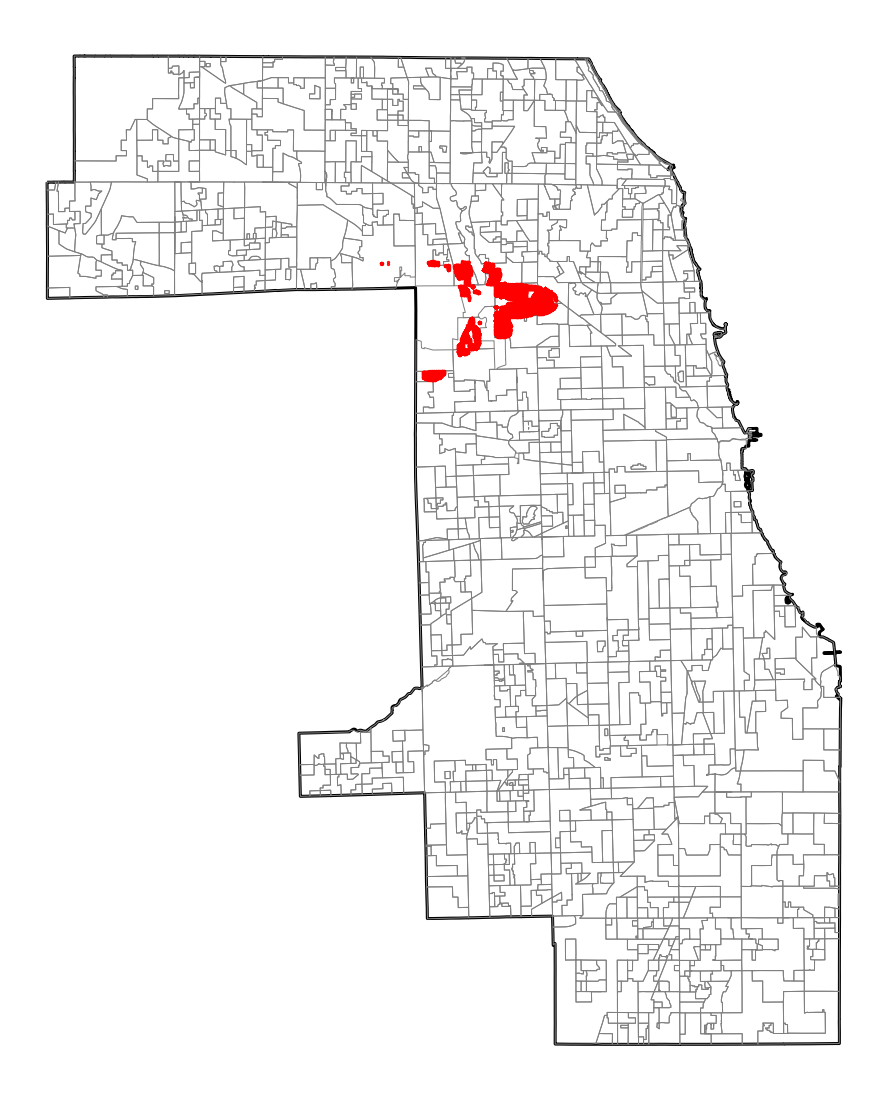

In [24]:
plot_gdf = cc_res_prop_char_gdf.loc[
    (cc_res_prop_char_gdf["O'Hare Noise"] == 1)
].copy()

fig, ax = plt.subplots(figsize=(20,20))
ax = cook_county_gdf.plot(color='none', edgecolor='black', linewidth=3, ax=ax)
ax = neighborhoods_gdf.plot(color='none', edgecolor='grey', linewidth=1, ax=ax)
ax = plot_gdf.plot(color='red', markersize=5, alpha=0.6, ax=ax)
ax = ax.axis('off')

In [25]:
plot_gdf = cc_res_prop_char_gdf.loc[
    (cc_res_prop_char_gdf["O'Hare Noise"].isnull())
].copy()

fig, ax = plt.subplots(figsize=(20,20))
ax = cook_county_gdf.plot(color='none', edgecolor='black', linewidth=3, ax=ax)
ax = neighborhoods_gdf.plot(color='none', edgecolor='grey', linewidth=1, ax=ax)
ax = plot_gdf.plot(color='red', markersize=5, alpha=0.6, ax=ax)
ax = ax.axis('off')
ax.set_title("Locations with a null `O'Hare Noise` value", fontsize=15)

/home/matt/miniconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/array.py:917: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/home/matt/miniconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/home/matt/miniconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/home/matt/miniconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer



### Floodplain
* Indicator for properties on a floodplain, defined as a FEMA Special Flood Hazard Area 

### Near Major Road
* Indicates whether the property is within 300 ft of a major road. 

These are geo-columns, like Latitude and Longitude, and I'll deal with those at the end.

### Age Squared
* Age Squared 

This feature seem

<AxesSubplot:ylabel='Frequency'>

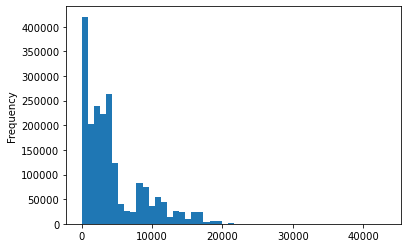

In [8]:
(cc_res_prop_char_df["Age"].pow(2)).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

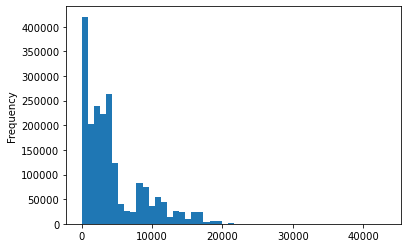

In [9]:
(cc_res_prop_char_df["Age Squared"]).plot.hist(bins=50)

Ok. As expected, `Age Squared` isn't bringing any new info. I'll make a note that it might be useful to recreate later in modeling, but for now, I'm dropping it as it's trivially easy to recreate from `Age`.

### Age Decade
* Age in decades 

In [12]:
cc_res_prop_char_df["Age Decade"].value_counts(dropna=False)

1.0     60807
6.2     43847
6.1     39770
6.3     39611
6.4     37510
        ...  
20.3        1
18.0        1
17.4        1
18.8        1
NaN         0
Name: Age Decade, Length: 189, dtype: Int64

Oh, wow. It's not even binning ages, it's just dividing by 10.

In [13]:
cc_res_prop_char_df["Age"].value_counts(dropna=False)

10     60807
62     43847
61     39770
63     39611
64     37510
       ...  
203        1
180        1
174        1
188        1
NaN        0
Name: Age, Length: 189, dtype: Int64

<AxesSubplot:ylabel='Frequency'>

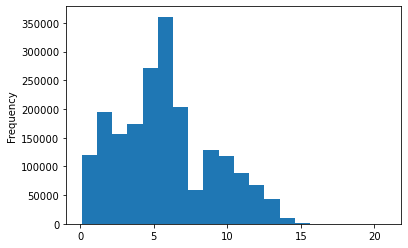

In [11]:
(cc_res_prop_char_df["Age Decade"]).plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

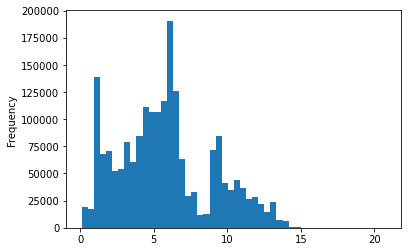

In [14]:
(cc_res_prop_char_df["Age Decade"]).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

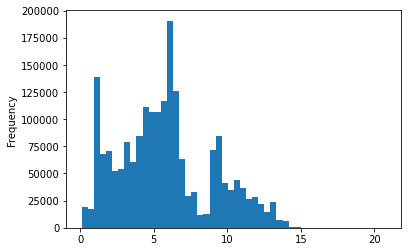

In [15]:
(cc_res_prop_char_df["Age"].div(10)).plot.hist(bins=50)

Ok. As expected, `Age Decade` also isn't bringing any new info. I'll make a note that it might be useful to recreate later in modeling, but for now, I'm dropping it as it's trivially easy to recreate from `Age`.

### Age Decade Squared
* Age in decades squared 

<AxesSubplot:ylabel='Frequency'>

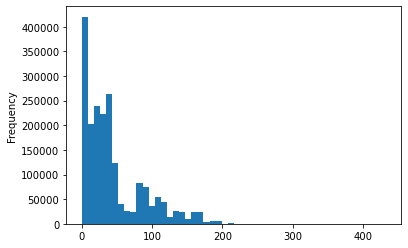

In [16]:
(cc_res_prop_char_df["Age Decade Squared"]).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

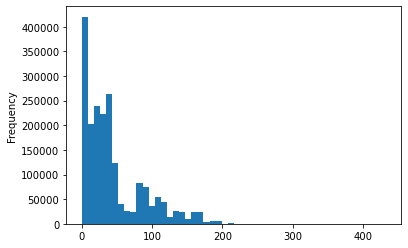

In [18]:
(cc_res_prop_char_df["Age Decade"].pow(2)).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

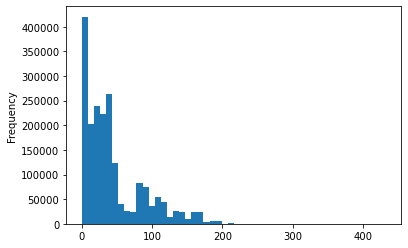

In [19]:
(cc_res_prop_char_df["Age"].div(10).pow(2)).plot.hist(bins=50)

`Age Decade Squared` is not bringing anything new. I'll note its possible modeling value like I did with the others, but I don't see a reason to lug it around until then.

### Lot Size Squared
* Lot Size Squared 

<AxesSubplot:ylabel='Frequency'>

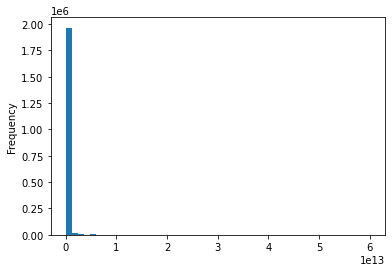

In [22]:
(cc_res_prop_char_df["Lot Size Squared"]).plot.hist(bins=50)

(0.0, 100000000000.0)

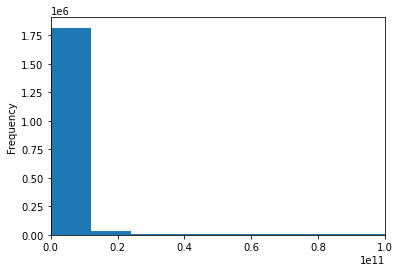

In [30]:
ax = (cc_res_prop_char_df["Lot Size Squared"]).plot.hist(bins=5000)
ax.set_xlim(0, 100000000000)

<AxesSubplot:ylabel='Frequency'>

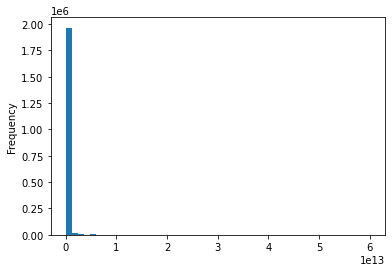

In [24]:
(cc_res_prop_char_df["Land Square Feet"].pow(2)).plot.hist(bins=50)

(0.0, 100000000000.0)

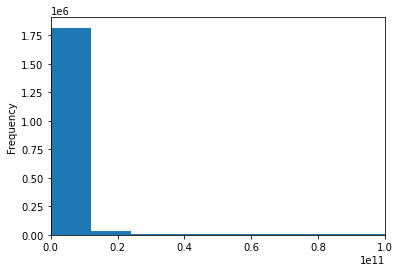

In [28]:
ax = (cc_res_prop_char_df["Land Square Feet"].pow(2)).plot.hist(bins=5000)
ax.set_xlim(0, 100000000000)

Ok, another redundant feature.

### Improvement Size Squared
* Building square feet, squared

<AxesSubplot:ylabel='Frequency'>

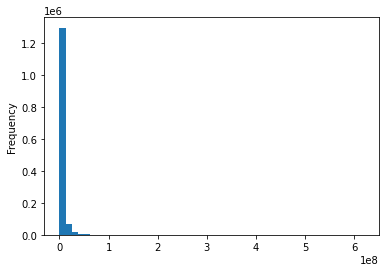

In [31]:
(cc_res_prop_char_df["Improvement Size Squared"]).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

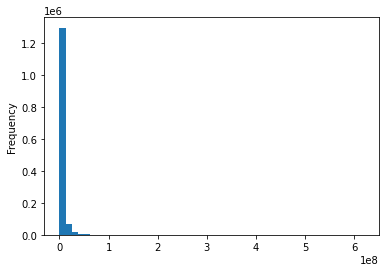

In [32]:
(cc_res_prop_char_df["Building Square Feet"].pow(2)).plot.hist(bins=50)

Yet another redundant feature.

### Location Factor
* Calculated from a geographically weighted regression. Captures the relationship between home value and geographic location. 

Hmmmmm. This seems like something worth spending the time to understand. It seems like a lot of harm or unfairness could get packed into this feature.

<AxesSubplot:ylabel='Frequency'>

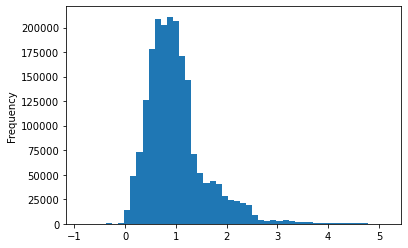

In [33]:
(cc_res_prop_char_df["Location Factor"]).plot.hist(bins=50)

### Garage indicator
* Indicates presence of a garage of any size. 

In [34]:
cc_res_prop_char_df["Garage indicator"].value_counts(dropna=False)

1      1177185
NaN     602017
0       215906
Name: Garage indicator, dtype: Int64

In [35]:
def clean_cc_residential_prop_chars_garage_indicator_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Indicates presence of a garage of any size."""
    df["Garage indicator"] = df["Garage indicator"].astype("boolean")
    return df

In [36]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_indicator_col(cc_res_prop_char_df)

In [37]:
cc_res_prop_char_df["Garage indicator"].value_counts(dropna=False)

True     1177185
NaN       602017
False     215906
Name: Garage indicator, dtype: Int64

### Residential share of building
* A sum of "percent of ownership" that only includes residential units within a condo building. 

<AxesSubplot:ylabel='Frequency'>

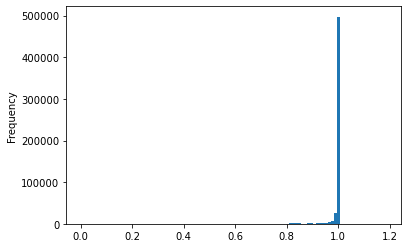

In [39]:
(cc_res_prop_char_df["Residential share of building"]).plot.hist(bins=100)

In [41]:
cc_res_prop_char_df["Residential share of building"].value_counts(dropna=False)

NaN          1433884
1.0           294354
0.9999          3838
1.0000002       3439
0.999998        2917
              ...   
0.0235             1
0.6494             1
0.0545758          1
0.335              1
0.4                1
Name: Residential share of building, Length: 1541, dtype: Int64

In [44]:
cc_res_prop_char_df.head(2)

PIN Property Class  Tax Year Neighborhood Code  Land Square Feet  \
0  1011000040000            212      2018               012             11055   
1  1011000050000            205      2018               012              6534   

  Town Code Type of Residence  Apartments Wall Material    Roof Material  \
0        10         two story           5          Wood   Tar and Gravel   
1        10         two story           0          Wood  Shingle/Asphalt   

   Rooms  Bedrooms Basement Basement Finish  Central Heating Other Heating  \
0      7         5  Partial      Unfinished         Warm air          none   
1      7         4     Full      Unfinished  Hot water steam          none   

   Central Air  Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
0        False           0       Full   Unfinished           1  Stock Plan   
1        False           1       Full   Unfinished           0  Stock Plan   

  Cathedral Ceiling Construction Quality Renovation     Site Desireability  \
0                No              Average        NaN  Not relevant to Value   
1                No              Average        NaN  Not relevant to Value   

  Garage 1 Size Garage 1 Material Garage 1 Attachment  \
0       1.5 car             Frame                  No   
1         2 car             Frame                  No   

                                   Garage 1 Area Garage 2 Size  \
0  No, garage area not included in building area          None   
1  No, garage area not included in building area          None   

           Garage 2 Material        Garage 2 Attachment  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

               Garage 2 Area  Porch  Building Square Feet Repair Condition  \
0  Car Port or Driveway Only      3                  1904          Average   
1  Car Port or Driveway Only      1                  1562          Average   

     Multi Code  Number of Commercial Units  \
0  One building                           1   
1  One building                           0   

   Prior Tax Year Market Value Estimate (Land)  \
0                                        52510   
1                                        31030   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           374930                      NaT   
1                                           173970                      NaT   

   Deed No.  Sale Price  Longitude   Latitude Census Tract  \
0      <NA>        <NA> -88.139621  42.153953       804201   
1      <NA>        <NA> -88.139379  42.153953       804201   

   Total Building Square Feet  Multi Property Indicator  \
0                        <NA>                     False   
1                        <NA>                     False   

           Property Address Modeling Group  Full Baths  Age  Use  \
0  213 W MAIN ST BARRINGTON             MF           5  135    2   
1  209 W MAIN ST BARRINGTON             SF           1  114    1   

   Number of Units  Percent Ownership Condo Class Factor  \
0             <NA>               <NA>                NaN   
1             <NA>               <NA>                NaN   

  Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
0                    Yes      False                                 NaN   
1                    NaN      False                                 NaN   

  Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
0       NaN             0           0                1            1   
1       NaN             0           0                1            1   

  Condo Strata  Age Squared  Age Decade  Age Decade Squared  Lot Size Squared  \
0          NaN        18225        13.5              182.25         122213025   
1          NaN        12996        11.4              129.96          42693156   

   Improvement Size Squared  Location Factor  Garage indicator  \
0                  

In [47]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Residential share of building"] > 1,
    ["PIN", "Property Address", "Number of Units", "Number of Commercial Units",
     "Percent Ownership", "Residential share of building", "Condo Strata"]
]

PIN           Property Address  Number of Units  \
642       3021000821248        40  PRAIRIE PARK DR              588   
746       3021000821236       100  PRAIRIE PARK DR              588   
1097      3021000821492       100  PRAIRIE PARK DR              588   
2277      3021000821389       100  PRAIRIE PARK DR              588   
2913      3021000821370       115  PRAIRIE PARK DR              588   
...                 ...                        ...              ...   
1992759  33072000121019  2817  GLENWOOD LANSING RD               32   
1992760  33072000121024  2807  GLENWOOD LANSING RD               32   
1992761  33072000121021  2809  GLENWOOD LANSING RD               32   
1992762  33072000121022  2809  GLENWOOD LANSING RD               32   
1992763  33072000121023  2809  GLENWOOD LANSING RD               32   

         Number of Commercial Units  Percent Ownership  \
642                            <NA>                0.0   
746                            <NA>                0.0   
1097                           <NA>                0.0   
2277                           <NA>                0.0   
2913                           <NA>                0.0   
...                             ...                ...   
1992759                        <NA>               0.03   
1992760                        <NA>               0.04   
1992761                        <NA>               0.04   
1992762                        <NA>               0.03   
1992763                        <NA>               0.03   

         Residential share of building Condo Strata  
642                            1.00002           10  
746                            1.00002           10  
1097                           1.00002           10  
2277                           1.00002           10  
2913                           1.00002           10  
...                                ...          ...  
1992759                           1.01            1  
1992760                           1.01            1  
1992761                           1.01            1  
1992762                           1.01            1  
1992763                           1.01            1  

[72261 rows x 7 columns]

In [50]:
cc_res_prop_char_df["Residential share of building"].max()

1.1862

In [55]:
cc_res_prop_char_df["Residential share of building"].notnull().sum()

561224

In [60]:
pct_w_impossible_values = round(
    100 * (cc_res_prop_char_df["Residential share of building"] > 1).sum() / 
    cc_res_prop_char_df["Residential share of building"].notnull().sum(),
    4
)
print(f"Percent of records (with non-null values) with an impossible ")
print(f"'Residential share of building' value: {pct_w_impossible_values}% ")

Percent of records (with non-null values) with an impossible 
'Residential share of building' value: 12.8756% 


In [64]:
threshold = 1.01
pct_w_impossible_values = round(
    100 * (cc_res_prop_char_df["Residential share of building"] > threshold).sum() / 
    cc_res_prop_char_df["Residential share of building"].notnull().sum(),
    4
)
print(f"Percent of records (with non-null values) with a 'Residential share")
print(f"of building' value above {threshold}: {pct_w_impossible_values}% ")

Percent of records (with non-null values) with a 'Residential share
of building' value above 1.01: 0.0656% 


In [62]:
threshold = 1.02
pct_w_impossible_values = round(
    100 * (cc_res_prop_char_df["Residential share of building"] > threshold).sum() / 
    cc_res_prop_char_df["Residential share of building"].notnull().sum(),
    4
)
print(f"Percent of records (with non-null values) with a 'Residential share")
print(f"of building' value above {threshold}: {pct_w_impossible_values}% ")

Percent of records (with non-null values) with a 'Residential share
of building' value above 1.02: 0.0369% 


Hmm. 100.002% implies a rounded percentages were summed. 118.62% implies an error. Still, a brief spotcheck shows the properties connected to these impossible `Residential share of building` values are all residential. Nearly 13% of all records with a non-null value for this feature have an impossible value, but most of those are likely just rounding errors, as less than 0.07% of all non-null records for this feature are above 101%. I don't know if any extra information is encoded in this feature, or if there's some definitional weirdness that makes these values legal, but I'm going to make the arbitrary choice of flattening values in the range [1.000 to 1.010] to 1.000, and values above 1.01 to 1.01.

In [54]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Residential share of building"] > 1.1,
    ["PIN", "Property Address", "Number of Units", "Number of Commercial Units",
     "Percent Ownership", "Residential share of building", "Condo Strata"]
]

PIN      Property Address  Number of Units  \
1078536  14293140501002  2555 N SOUTHPORT AVE                4   
1078537  14293140501004  2555 N SOUTHPORT AVE                4   
1078538  14293140501003  2555 N SOUTHPORT AVE                4   
1078539  14293140501001  2555 N SOUTHPORT AVE                4   
1167963  16014040461002     2727 W HADDON AVE                3   
1167964  16014040461003     2727 W HADDON AVE                3   
1167965  16014040461001     2727 W HADDON AVE                3   

         Number of Commercial Units  Percent Ownership  \
1078536                        <NA>               0.24   
1078537                        <NA>               0.27   
1078538                        <NA>               0.25   
1078539                        <NA>               0.24   
1167963                        <NA>               0.25   
1167964                        <NA>               0.34   
1167965                        <NA>               0.41   

         Residential share of building Condo Strata  
1078536                         1.1211          NaN  
1078537                         1.1211          NaN  
1078538                         1.1211          NaN  
1078539                         1.1211          NaN  
1167963                         1.1862          NaN  
1167964                         1.1862          NaN  
1167965                         1.1862          NaN

<AxesSubplot:ylabel='Frequency'>

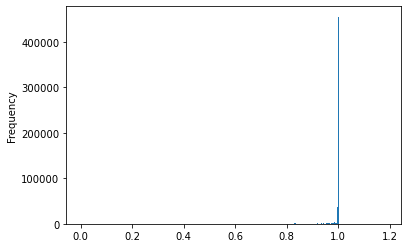

In [65]:
(cc_res_prop_char_df["Residential share of building"]).plot.hist(bins=500)

In [66]:
df = cc_res_prop_char_df

rounding_error_mask = (
    (df["Residential share of building"] > 1) & 
    (df["Residential share of building"] < 1.01)
)
bigger_error_mask = (df["Residential share of building"] >= 1.01)
df.loc[rounding_error_mask, "Residential share of building"] = 1
df.loc[bigger_error_mask, "Residential share of building"] = 1.01

In [71]:
def clean_cc_residential_prop_chars_residential_share_of_building_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    rounding_error_mask = (
        (df["Residential share of building"] > 1) & 
        (df["Residential share of building"] < 1.01)
    )
    bigger_error_mask = (df["Residential share of building"] >= 1.01)
    df.loc[rounding_error_mask, "Residential share of building"] = 1
    df.loc[bigger_error_mask, "Residential share of building"] = 1.01
    return df

In [72]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_residential_share_of_building_col(cc_res_prop_char_df)

<AxesSubplot:ylabel='Frequency'>

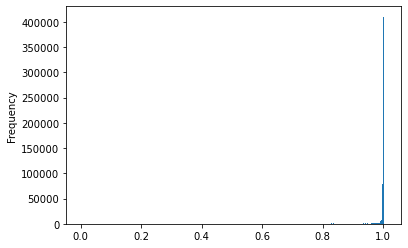

In [73]:
(cc_res_prop_char_df["Residential share of building"]).plot.hist(bins=500)

In [74]:
cc_res_prop_char_df["Residential share of building"].max()

1.01

### Pure Market Sale
* Indicator for pure market sale.

In [75]:
cc_res_prop_char_df["Pure Market Sale"].value_counts(dropna=False)

0      1908583
1        86525
NaN          0
Name: Pure Market Sale, dtype: Int64

In [85]:
def clean_cc_residential_prop_chars_pure_market_sale_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Indicator for pure market sale."""
    df["Pure Market Sale"] = df["Pure Market Sale"].astype("boolean")
    return df

In [77]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_pure_market_sale_col(cc_res_prop_char_df)

In [78]:
cc_res_prop_char_df["Pure Market Sale"].value_counts(dropna=False)

False    1908583
True       86525
NaN            0
Name: Pure Market Sale, dtype: Int64

### Pure Market Filter
* Indicator for pure market sale.

Hmmm. Is this different from `Pure Market Sale`?

In [79]:
cc_res_prop_char_df["Pure Market Filter"].value_counts(dropna=False)

0      1908583
1        86525
NaN          0
Name: Pure Market Filter, dtype: Int64

In [80]:
(cc_res_prop_char_df["Pure Market Filter"].astype("boolean") != cc_res_prop_char_df["Pure Market Sale"]).sum()

0

Ok, there are 0 records where these columns have different values. I'm going to drop the latter.

### Neigborhood Code (mapping)
* Unmodified neighborhood code that can be used for mapping. 

In [84]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

030    110964
010     92851
070     71885
050     71720
031     70803
        ...  
038        85
580        55
145        50
599         4
999         1
Name: Neighborhood Code, Length: 199, dtype: int64

In [82]:
cc_res_prop_char_df["Neigborhood Code (mapping)"].value_counts(dropna=False)

30     110964
10      92851
70      71885
50      71720
31      70803
        ...  
580        55
145        50
599         4
999         1
NaN         0
Name: Neigborhood Code (mapping), Length: 200, dtype: Int64

In [86]:
df = cc_res_prop_char_df.copy()

In [87]:
df = df.rename(columns={"Neigborhood Code (mapping)": "Neighborhood Code (mapping)"})

In [ ]:
cc_res_prop_char_df["Neigborhood Code (mapping)"]

In [89]:
df["Neighborhood Code (mapping)"] = df["Neighborhood Code (mapping)"].astype("string")
df["Neighborhood Code (mapping)"] = df["Neighborhood Code (mapping)"].str.zfill(3)
df["Neighborhood Code (mapping)"] = df["Neighborhood Code (mapping)"].astype("category")

In [91]:
df["Neighborhood Code (mapping)"].value_counts(dropna=False)

030    110964
010     92851
070     71885
050     71720
031     70803
        ...  
038        85
580        55
145        50
599         4
999         1
Name: Neighborhood Code (mapping), Length: 199, dtype: int64

In [92]:
df.loc[
    df["Neighborhood Code"] != df["Neighborhood Code (mapping)"]
]

Empty DataFrame
Columns: [PIN, Property Class, Tax Year, Neighborhood Code, Land Square Feet, Town Code, Type of Residence, Apartments, Wall Material, Roof Material, Rooms, Bedrooms, Basement, Basement Finish, Central Heating, Other Heating, Central Air, Fireplaces, Attic Type, Attic Finish, Half Baths, Design Plan, Cathedral Ceiling, Construction Quality, Renovation, Site Desireability, Garage 1 Size, Garage 1 Material, Garage 1 Attachment, Garage 1 Area, Garage 2 Size, Garage 2 Material, Garage 2 Attachment, Garage 2 Area, Porch, Building Square Feet, Repair Condition, Multi Code, Number of Commercial Units, Prior Tax Year Market Value Estimate (Land), Prior Tax Year Market Value Estimate (Building), Date of Most Recent Sale, Deed No., Sale Price, Longitude, Latitude, Census Tract, Total Building Square Feet, Multi Property Indicator, Property Address, Modeling Group, Full Baths, Age, Use, Number of Units, Percent Ownership, Condo Class Factor, Multi-Family Indicator, Large Lot, Condition, Desirability and Utility, Deed Type, O'Hare Noise, Floodplain, Near Major Road, Total Units, Condo Strata, Age Squared, Age Decade, Age Decade Squared, Lot Size Squared, Improvement Size Squared, Location Factor, Garage indicator, Residential share of building, Pure Market Sale, Pure Market Filter, Neighborhood Code (mapping), Square root of lot size, Square root of age, Square root of improvement size, Town and Neighborhood, Property Class Descr]
Index: []

In [94]:
df.loc[
    df["Neighborhood Code"] == df["Neighborhood Code (mapping)"]
].shape

(1995108, 82)

In [95]:
df.shape

(1995108, 82)

Ok, this column also doesn't add any new information, as (after light string formatting) it matches the `Neighborhood Code` feature for every record. Adding `Neigborhood Code (mapping)` to the drop list.

### Square root of lot size
* Square root of lot size.

<AxesSubplot:ylabel='Frequency'>

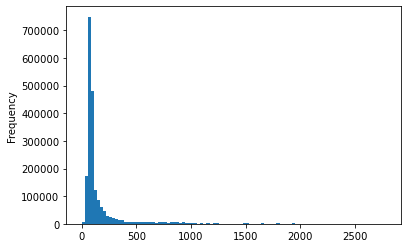

In [97]:
(cc_res_prop_char_df["Square root of lot size"]).plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

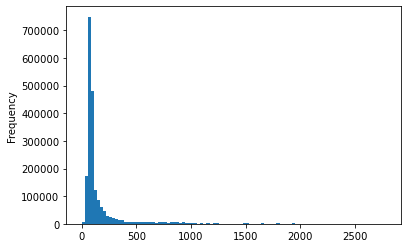

In [98]:
(cc_res_prop_char_df["Land Square Feet"].pow(0.5)).plot.hist(bins=100)

In [109]:
cc_res_prop_char_df["Land Square Feet"].pow(0.5).head(2)

0    105.14276
1    80.833162
Name: Land Square Feet, dtype: Float64

In [99]:
(cc_res_prop_char_df["Land Square Feet"].pow(0.5) != cc_res_prop_char_df["Square root of lot size"]).sum()

1490940

Ok, my calculated square-root-of-land-area values are not exactly equal to the provided `Square root of lot size` values, but it's possible that's just a floating point issue. Let's check the magnitude of the difference.

In [106]:
df = cc_res_prop_char_df[["Square root of lot size", "Land Square Feet"]].copy()
df["sqrt_Land Square Feet"] = df["Land Square Feet"].pow(0.5)
df["diff"] = df["Square root of lot size"] - df["sqrt_Land Square Feet"]

In [107]:
df.head(2)

Square root of lot size  Land Square Feet  sqrt_Land Square Feet  diff
0                105.14276             11055              105.14276   0.0
1                80.833162              6534              80.833162   0.0

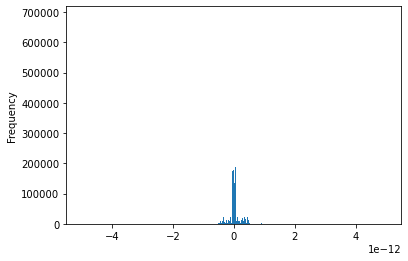

In [108]:
ax = (df["diff"]).plot.hist(bins=500)
# ax.set_xlim(0, 100000000000)

In [111]:
print(f"Magnitude of largest difference: {df['diff'].abs().max()}")

Magnitude of largest difference: 5.002220859751105e-12


That confirms it. The magnitude of the largest difference between my calculated values and the provided values is $5 \times 10^{-12}$ ft (or $0.000000000005$ ft).

Thus, the `Square root of lot size` feature is just another field calculated from `Lot Size` and I'll drop it for now.

### Square root of age
* Square root of age of improvement.

<AxesSubplot:ylabel='Frequency'>

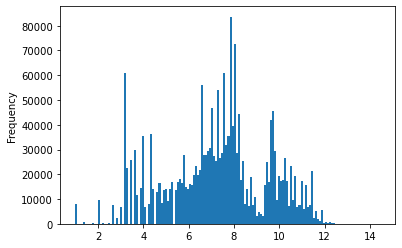

In [114]:
(cc_res_prop_char_df["Square root of age"]).plot.hist(bins=150)

<AxesSubplot:ylabel='Frequency'>

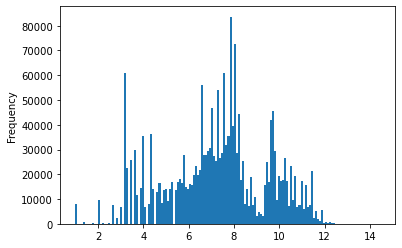

In [115]:
(cc_res_prop_char_df["Age"].pow(0.5)).plot.hist(bins=150)

In [116]:
df = cc_res_prop_char_df[["Square root of age", "Age"]].copy()
df["sqrt_Age"] = df["Age"].pow(0.5)
df["diff"] = df["Square root of age"] - df["sqrt_Age"]

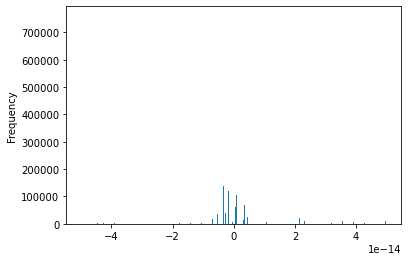

In [117]:
ax = (df["diff"]).plot.hist(bins=500)

As expected, `Square root of age` is also a calculated field that I can remake easily later if I think it would be useful in modeling.

### Square root of improvement size
* Square root of improvement size 

<AxesSubplot:ylabel='Frequency'>

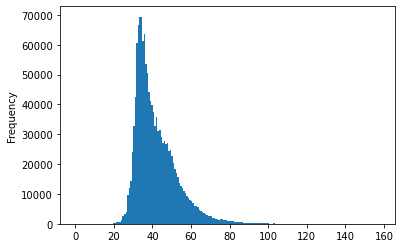

In [119]:
(cc_res_prop_char_df["Square root of improvement size"]).plot.hist(bins=200)

<AxesSubplot:ylabel='Frequency'>

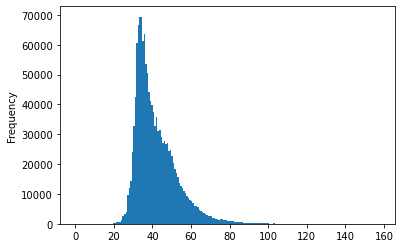

In [120]:
(cc_res_prop_char_df["Building Square Feet"].pow(0.5)).plot.hist(bins=200)

In [121]:
df = cc_res_prop_char_df[["Square root of improvement size", "Building Square Feet"]].copy()
df["sqrt_Building Square Feet"] = df["Building Square Feet"].pow(0.5)
df["diff"] = df["Square root of improvement size"] - df["sqrt_Building Square Feet"]

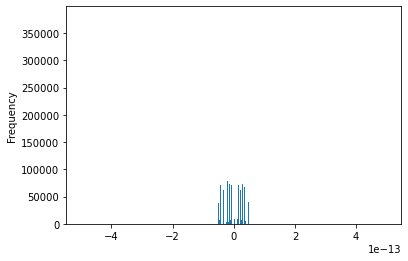

In [122]:
ax = (df["diff"]).plot.hist(bins=500)

As expected, `Square root of improvement size` is another calculated field that I can remake easily later if I think it would be useful in modeling.

### Town and Neighborhood
* Combination of town and neighborhood used to uniquely neighborhoods across townships. 

In [123]:
cc_res_prop_char_df.head(2)

PIN Property Class  Tax Year Neighborhood Code  Land Square Feet  \
0  1011000040000            212      2018               012             11055   
1  1011000050000            205      2018               012              6534   

  Town Code Type of Residence  Apartments Wall Material    Roof Material  \
0        10         two story           5          Wood   Tar and Gravel   
1        10         two story           0          Wood  Shingle/Asphalt   

   Rooms  Bedrooms Basement Basement Finish  Central Heating Other Heating  \
0      7         5  Partial      Unfinished         Warm air          none   
1      7         4     Full      Unfinished  Hot water steam          none   

   Central Air  Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
0        False           0       Full   Unfinished           1  Stock Plan   
1        False           1       Full   Unfinished           0  Stock Plan   

  Cathedral Ceiling Construction Quality Renovation     Site Desireability  \
0                No              Average        NaN  Not relevant to Value   
1                No              Average        NaN  Not relevant to Value   

  Garage 1 Size Garage 1 Material Garage 1 Attachment  \
0       1.5 car             Frame                  No   
1         2 car             Frame                  No   

                                   Garage 1 Area Garage 2 Size  \
0  No, garage area not included in building area          None   
1  No, garage area not included in building area          None   

           Garage 2 Material        Garage 2 Attachment  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

               Garage 2 Area  Porch  Building Square Feet Repair Condition  \
0  Car Port or Driveway Only      3                  1904          Average   
1  Car Port or Driveway Only      1                  1562          Average   

     Multi Code  Number of Commercial Units  \
0  One building                           1   
1  One building                           0   

   Prior Tax Year Market Value Estimate (Land)  \
0                                        52510   
1                                        31030   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           374930                      NaT   
1                                           173970                      NaT   

   Deed No.  Sale Price  Longitude   Latitude Census Tract  \
0      <NA>        <NA> -88.139621  42.153953       804201   
1      <NA>        <NA> -88.139379  42.153953       804201   

   Total Building Square Feet  Multi Property Indicator  \
0                        <NA>                     False   
1                        <NA>                     False   

           Property Address Modeling Group  Full Baths  Age  Use  \
0  213 W MAIN ST BARRINGTON             MF           5  135    2   
1  209 W MAIN ST BARRINGTON             SF           1  114    1   

   Number of Units  Percent Ownership Condo Class Factor  \
0             <NA>               <NA>                NaN   
1             <NA>               <NA>                NaN   

  Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
0                    Yes      False                                 NaN   
1                    NaN      False                                 NaN   

  Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
0       NaN             0           0                1            1   
1       NaN             0           0                1            1   

  Condo Strata  Age Squared  Age Decade  Age Decade Squared  Lot Size Squared  \
0          NaN        18225        13.5              182.25         122213025   
1          NaN        12996        11.4              129.96          42693156   

   Improvement Size Squared  Location Factor  Garage indicator  \
0                  

In [124]:
cc_res_prop_char_df["Town and Neighborhood"].value_counts(dropna=False)

7430     29972
2431     28771
7422     23049
2481     21500
77131    19069
         ...  
25310       26
3082        25
71599        4
34999        1
NaN          0
Name: Town and Neighborhood, Length: 853, dtype: Int64

In [126]:
df = cc_res_prop_char_df[["Town and Neighborhood", "Town Code", "Neighborhood Code"]].copy()

In [128]:
df.head(2)

Town and Neighborhood Town Code Neighborhood Code
0                   1012        10               012
1                   1012        10               012

In [131]:
df["Town and Neighborhood"] = df["Town Code"].astype("string") + df["Neighborhood Code"].astype("string")
df["Town and Neighborhood"] = df["Town and Neighborhood"].astype("category")

In [133]:
def clean_cc_residential_prop_chars_town_and_neighborhood_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Town and Neighborhood"] = df["Town Code"].astype("string") + df["Neighborhood Code"].astype("string")
    df["Town and Neighborhood"] = df["Town and Neighborhood"].astype("category")
    return df

In [134]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_town_and_neighborhood_col(cc_res_prop_char_df)

In [135]:
cc_res_prop_char_df["Town and Neighborhood"].value_counts(dropna=False)

74030    29972
24031    28771
74022    23049
24081    21500
77131    19069
         ...  
30100       37
25310       26
30082       25
71599        4
34999        1
Name: Town and Neighborhood, Length: 852, dtype: int64

In [6]:
cc_res_prop_char_df = utils.get_raw_cc_residential_property_characteristics_data()
# cc_res_prop_char_df = cc_res_prop_char_df.convert_dtypes()

In [7]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_property_class_col(
    df=cc_res_prop_char_df
)

* **PIN**
    * Unique Permanent Identification Number for each property. All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode

* **Tax Year**
    * Tax year of sale. Tax year referrs to the year in which taxes due. Taxes are billed a year in arrears. If a sale ocurred in calendar year 2018, it will be in tax year 2019.
    
No real issues in this feature.

In [8]:
cc_res_prop_char_df["Tax Year"].value_counts(dropna=False)

2019    1583785
2018     411323
NaN           0
Name: Tax Year, dtype: Int64

### **Neighborhood Code**
    * Neighborhood code as assigned by the Assessment office. An interactive map is available at https://maps.cookcountyil.gov/cookviewer/.

In [9]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

30     110964
10      92851
70      71885
50      71720
31      70803
        ...  
580        55
145        50
599         4
999         1
NaN         0
Name: Neighborhood Code, Length: 200, dtype: Int64

In [10]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_neighborhood_code_col(cc_res_prop_char_df)

In [11]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

030    110964
010     92851
070     71885
050     71720
031     70803
        ...  
038        85
580        55
145        50
599         4
999         1
Name: Neighborhood Code, Length: 199, dtype: int64

### **Land Square Feet**
    * Square feet of the land (not just the building) of the property. Note that land is divided into 'plots' and 'parcels' - this field applies to parcels, identified by PIN.

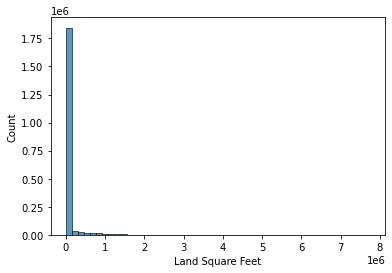

In [12]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Land Square Feet", bins=50)

(0.0, 100000.0)

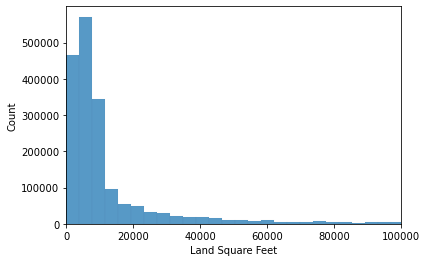

In [13]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Land Square Feet", bins=2000)
ax.set_xlim(0, 100000)

### Town Code
* Township code as assigned by the Assessment office. An interactive map is available at https://maps.cookcountyil.gov/cookviewer/.

In [14]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_town_code_col(cc_res_prop_char_df)

In [16]:
cc_res_prop_char_df["Town Code"].value_counts(dropna=False)

72    151861
71    139753
77    112670
38    111341
22     97889
73     92470
35     88665
70     82673
24     82146
29     80601
74     71093
25     65521
18     63240
76     60728
37     60075
16     58389
20     57156
39     57069
31     48072
17     44716
23     42817
13     40605
21     38040
28     37161
12     30131
32     26303
75     20300
30     20140
26     18204
27     17328
15     14529
11     14121
36     13164
10     12512
19      8006
34      5908
14      5439
33      4272
Name: Town Code, dtype: int64

### Type of Residence
* Type of residence - 1 = one story, 2 = two-story, 3 = three-story or higher, 4 = split level, 5 = 1.5 story, 6 = 1.6 story, 7 = 1.7 story , 8 = 1.8 story , 9 = 1.9 story (Note: residences with 1.5 - 1.9 stories are one story and have partial livable attics and are classified based on the square footage of the attic compared to the first floor of the house. So, 1.5 story houses have an attic that is 50% of the area of the first floor, 1.6 story houses are 60%, 1.7 are 70%, etc. However, what is recorded on the field card differs from what is in the database. All 1.5 - 1.9 story houses are coded as 5).

In [17]:
cc_res_prop_char_df["Type of Residence"].value_counts(dropna=False)

NaN    602055
2      552786
1      540166
4      130510
5      130080
3       39398
7          39
8          33
6          23
9          18
Name: Type of Residence, dtype: Int64

In [18]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_type_of_residence_col(cc_res_prop_char_df)

In [19]:
cc_res_prop_char_df["Type of Residence"].value_counts(dropna=False)

NaN                                                                            602055
two story                                                                      552786
one story                                                                      540166
split level                                                                    130510
1.5 story (one story w/ partial livable attic; 50% sq footage of 1st floor)    130080
three story or higher                                                           39398
1.7 story (one story w/ partial livable attic; 70% sq footage of 1st floor)        39
1.8 story (one story w/ partial livable attic; 80% sq footage of 1st floor)        33
1.6 story (one story w/ partial livable attic; 60% sq footage of 1st floor)        23
1.9 story (one story w/ partial livable attic; 90% sq footage of 1st floor)        18
Name: Type of Residence, dtype: int64

### Apartments
* Number of apartments in the building - 2 = Two, 3 = Three, 4 = Four, 5 = Five, 6 = Six, 0 = None

Hmm. It's not clear what -5 means. I've spotchecked a few of the -5 properties in Google Maps and it hasn't meant a consistent number of apartments. For the small sample I checked, it was mostly 0 or 1.

The 8s and 9 largely appear to be single family homes. I'm going to wipe out that spurious info. In this pull, it's 442 out of nearly 2 million records.

In [20]:
cc_res_prop_char_df["Apartments"].value_counts(dropna=False)

0      1225156
NaN     602017
2        98871
3        36626
4        15621
6        12984
5         3391
-5         436
8            5
9            1
Name: Apartments, dtype: Int64

In [21]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_apartments_col(cc_res_prop_char_df)

In [22]:
cc_res_prop_char_df["Apartments"].value_counts(dropna=False)

0      1225156
NaN     602459
2        98871
3        36626
4        15621
6        12984
5         3391
Name: Apartments, dtype: Int64

### Wall Material
* Exterior wall material - 1=Wood, 2=Masonry, 3=Wood&Masonry, 4=Stucco

In [23]:
cc_res_prop_char_df["Wall Material"].value_counts(dropna=False)

NaN    602055
2      571285
1      447881
3      352329
4       21558
Name: Wall Material, dtype: Int64

In [24]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_wall_material_col(cc_res_prop_char_df)

In [25]:
cc_res_prop_char_df["Wall Material"].value_counts(dropna=False)

NaN                 602055
Masonry             571285
Wood                447881
Wood and Masonry    352329
Stucco               21558
Name: Wall Material, dtype: int64

### Roof Material
* Roof construction material. 1 = Shingle/Asphalt, 2 = Tar & Gravel, 3 = Slate, 4 = Shake, 5 = Tile, 6 = Other

In [26]:
cc_res_prop_char_df["Roof Material"].value_counts(dropna=False)

1      1263767
NaN     602055
2        93705
4        14879
5         7996
6         6936
3         5770
Name: Roof Material, dtype: Int64

In [27]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_roof_material_col(cc_res_prop_char_df)

In [28]:
cc_res_prop_char_df["Roof Material"].value_counts(dropna=False)

Shingle/Asphalt    1263767
NaN                 602055
Tar and Gravel       93705
Shake                14879
Tile                  7996
Other                 6936
Slate                 5770
Name: Roof Material, dtype: int64

### Rooms
* 	
Number of rooms in the property (excluding baths). Not to be confused with bedrooms.

In [29]:
cc_res_prop_char_df["Rooms"].value_counts(dropna=False)

NaN    602055
6      355237
5      297086
7      220519
8      179319
4       94048
9       77791
10      54773
12      29025
11      19413
15       8885
3        8490
14       7537
18       7280
16       7090
13       5562
24       4264
20       3582
30       2557
17       1862
21       1620
22       1130
36        851
23        744
19        736
27        706
29        521
26        469
25        451
28        444
2         352
35        159
42        130
32        109
34         81
33         59
40         53
31         42
38         19
48         18
39          8
37          6
41          6
46          4
44          3
49          2
50          2
47          2
210         1
320         1
64          1
180         1
241         1
80          1
Name: Rooms, dtype: Int64

In [30]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Rooms"] > 100,
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Rooms"]
]

Latitude  Longitude      Property Address  Land Square Feet  Rooms
955791   41.927637  -87.71987   2540 N LAWNDALE AVE              3250    210
1178621  41.896902 -87.754779  900 N LEAMINGTON AVE              4677    320
1204136  41.871088 -87.716653        3626 W POLK ST              3100    180
1232917  41.846955  -87.69168      2631 W LUTHER ST              1800    241

Based on Google Maps, these properties with more than 100 rooms are just regular apartments (as implied by the square footage). Those room counts are not good.

In [31]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_rooms_col(cc_res_prop_char_df)

In [32]:
cc_res_prop_char_df["Rooms"].value_counts(dropna=False)

NaN    602059
6      355237
5      297086
7      220519
8      179319
4       94048
9       77791
10      54773
12      29025
11      19413
15       8885
3        8490
14       7537
18       7280
16       7090
13       5562
24       4264
20       3582
30       2557
17       1862
21       1620
22       1130
36        851
23        744
19        736
27        706
29        521
26        469
25        451
28        444
2         352
35        159
42        130
32        109
34         81
33         59
40         53
31         42
38         19
48         18
39          8
41          6
37          6
46          4
44          3
47          2
50          2
49          2
64          1
80          1
Name: Rooms, dtype: Int64

### Bedrooms
* 	Number of bedrooms in the property, defined based on building squarefoot and the judgement of the person in the field. 

In [33]:
cc_res_prop_char_df["Bedrooms"].value_counts(dropna=False)

3      634305
NaN    602055
4      388124
2      192795
5       79508
6       55409
8       12439
9        7454
12       6849
7        6263
1        3867
10       2423
11       1497
18       1213
15        296
14        214
16        140
13        115
24         52
20         42
19         16
17         14
21          5
22          4
23          3
34          2
66          1
90          1
30          1
25          1
Name: Bedrooms, dtype: Int64

In [34]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Bedrooms"] > 50,
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Bedrooms"]
]

Latitude  Longitude    Property Address  Land Square Feet  Bedrooms
951161   41.926468  -87.70149  2436 N RICHMOND ST              3150        66
1204136  41.871088 -87.716653      3626 W POLK ST              3100        90

Nope. No way those properties have more than 12 bedrooms.

In [35]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Bedrooms"] > 25) & (cc_res_prop_char_df["Bedrooms"] < 50),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Bedrooms"]
]

Latitude  Longitude      Property Address  Land Square Feet  \
706766   42.036066  -87.84204    8632 W STOLTING RD              9350   
990746   41.916455 -87.702841  1924 N HUMBOLDT BLVD              8750   
1548078  41.811489 -87.614668         444 E 46TH ST              6250   

         Bedrooms  
706766         34  
990746         34  
1548078        30

Some of those are plausible.

In [36]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_bedrooms_col(cc_res_prop_char_df)

In [37]:
cc_res_prop_char_df["Bedrooms"].value_counts(dropna=False)

3      634305
NaN    602057
4      388124
2      192795
5       79508
6       55409
8       12439
9        7454
12       6849
7        6263
1        3867
10       2423
11       1497
18       1213
15        296
14        214
16        140
13        115
24         52
20         42
19         16
17         14
21          5
22          4
23          3
34          2
30          1
25          1
Name: Bedrooms, dtype: Int64

### Basement
* Basement type - 1 = Full, 2 = Slab, 3 = Partial, 4 = Crawl 

In [38]:
cc_res_prop_char_df["Basement"].value_counts(dropna=False)

1      802554
NaN    602055
3      335929
2      173863
4       80707
Name: Basement, dtype: Int64

In [39]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_basement_col(cc_res_prop_char_df)

In [40]:
cc_res_prop_char_df["Basement"].value_counts(dropna=False)

Full       802554
NaN        602055
Partial    335929
Slab       173863
Crawl       80707
Name: Basement, dtype: int64

### Basement Finish
* Basement finish - 1 = Formal rec room; 2 = Apartment; 3 = Unfinished

In [41]:
cc_res_prop_char_df["Basement Finish"].value_counts(dropna=False)

3      943088
NaN    602058
1      425857
2       24105
Name: Basement Finish, dtype: Int64

In [42]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_basement_finish_col(cc_res_prop_char_df)

In [43]:
cc_res_prop_char_df["Basement Finish"].value_counts(dropna=False)

Unfinished         943088
NaN                602058
Formal rec room    425857
Apartment           24105
Name: Basement Finish, dtype: int64

### Central Heating
* Central heating type - 1 = Warm air, 2 = Hot water steam, 3 = Electric, 4 = Other

In [44]:
cc_res_prop_char_df["Central Heating"].value_counts(dropna=False)

1      1193596
NaN     602055
2       199457
Name: Central Heating, dtype: Int64

In [45]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_central_heating_col(cc_res_prop_char_df)

In [46]:
cc_res_prop_char_df["Central Heating"].value_counts(dropna=False)

Warm air           1193596
NaN                 602055
Hot water steam     199457
Name: Central Heating, dtype: int64

### Other Heating
* Other heating type - 1 = Floor furnace, 2 = Unit heater, 3 = Stove, 4 = Solar, 5 = none

In [47]:
cc_res_prop_char_df["Other Heating"].value_counts(dropna=False)

5      1350200
NaN     602017
2        42891
Name: Other Heating, dtype: Int64

In [50]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_other_heating_col(cc_res_prop_char_df)

In [51]:
cc_res_prop_char_df["Other Heating"].value_counts(dropna=False)

none           1350200
NaN             602017
Unit heater      42891
Name: Other Heating, dtype: int64

### Central Air
* Is central airconditioning present? - 1 = yes, 2 = no

In [52]:
cc_res_prop_char_df["Central Air"].value_counts(dropna=False)

1      723431
0      669622
NaN    602055
Name: Central Air, dtype: Int64

Hmm. 

In [54]:
neighborhoods_gdf.head(2)

nbhd town_nbhd township_c township_n triad_code triad_name  \
0  060     29060         29   Palatine          2      North   
1  120     32120         32       Rich          3      South   

                                            geometry  
0  POLYGON ((-88.00465 42.09562, -88.00467 42.093...  
1  POLYGON ((-87.67426 41.49161, -87.67426 41.491...

In [55]:
neighborhoods_gdf["township_n"].value_counts()

Rich             50
Lake             49
Bloom            43
Jefferson        42
Schaumburg       40
Bremen           39
Worth            36
Northfield       35
Thornton         34
Lyons            33
Proviso          33
Wheeling         31
Hyde Park        27
Orland           27
Maine            26
West Chicago     25
Palatine         24
Palos            23
New Trier        23
Lake View        22
Hanover          19
Evanston         18
Elk Grove        16
Niles            16
Leyden           12
Lemont           11
Barrington       11
Cicero           11
Oak Park         11
Stickney          9
South Chicago     9
Rogers Park       9
Berwyn            7
Riverside         6
North Chicago     5
Norwood Park      5
River Forest      5
Calumet           4
Name: township_n, dtype: int64

In [56]:
neighborhoods_gdf.loc[neighborhoods_gdf["township_n"] == "Evanston"]

nbhd town_nbhd township_c township_n triad_code triad_name  \
12   050     17050         17   Evanston          2      North   
49   112     17112         17   Evanston          2      North   
55   110     17110         17   Evanston          2      North   
87   120     17120         17   Evanston          2      North   
104  130     17130         17   Evanston          2      North   
117  011     17011         17   Evanston          2      North   
121  013     17013         17   Evanston          2      North   
193  210     17210         17   Evanston          2      North   
212  200     17200         17   Evanston          2      North   
661  060     17060         17   Evanston          2      North   
686  071     17071         17   Evanston          2      North   
712  080     17080         17   Evanston          2      North   
739  090     17090         17   Evanston          2      North   
740  140     17140         17   Evanston          2      North   
753  020     17020         17   Evanston          2      North   
806  043     17043         17   Evanston          2      North   
808  041     17041         17   Evanston          2      North   
811  042     17042         17   Evanston          2      North   

                                              geometry  
12   POLYGON ((-87.67724 42.05119, -87.67726 42.051...  
49   POLYGON ((-87.66743 42.02663, -87.66700 42.026...  
55   POLYGON ((-87.68995 42.03401, -87.68996 42.033...  
87   POLYGON ((-87.68819 42.06418, -87.68819 42.064...  
104  POLYGON ((-87.70829 42.04822, -87.70607 42.048...  
117  POLYGON ((-87.72019 42.05895, -87.72020 42.055...  
121  POLYGON ((-87.68819 42.06418, -87.68882 42.063...  
193  POLYGON ((-87.69453 42.04120, -87.69453 42.041...  
212  POLYGON ((-87.71294 42.06444, -87.71293 42.064...  
661  POLYGON ((-87.70821 42.05229, -87.70430 42.053...  
686  POLYGON ((-87.67985 42.03395, -87.67693 42.033...  
712  POLYGON ((-87.68234 42.04411, -87.68226 42.043...  
739  POLYGON ((-87.68834 42.05224, -87.68815 42.052...  
740  POLYGON ((-87.69930 42.03387, -87.69932 42.033...  
753  POLYGON ((-87.70652 42.06436, -87.70653 42.063...  
806  POLYGON ((-87.68195 42.04266, -87.68192 42.042...  
808  MULTIPOLYGON (((-87.69348 42.05834, -87.69315 ...  
811  POLYGON ((-87.67724 42.05207, -87.67986 42.052...

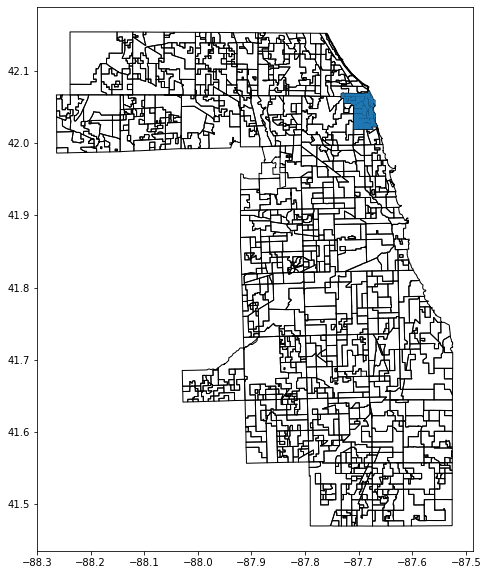

In [57]:
fig, ax = plt.subplots(figsize=(10,10))

ax = neighborhoods_gdf.plot(color="none", ax=ax)
ax = neighborhoods_gdf.loc[neighborhoods_gdf["township_n"] == "Evanston"].plot(ax=ax)

In [58]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "27"),
#     (cc_res_prop_char_df["Property Address"].str.contains("OAK PARK")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(4934, 5)

In [59]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "27"),
#     (cc_res_prop_char_df["Property Address"].str.contains("OAK PARK")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(6451, 5)

In [60]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(24, 5)

In [61]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(14, 5)

In [62]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
]

Latitude  Longitude                Property Address  \
371320  42.039786 -87.670791  1214  LAKE SHORE BLVD EVANSTON   
371321  42.039637 -87.670882  1212  LAKE SHORE BLVD EVANSTON   
371458  42.038932 -87.670953  1140  LAKE SHORE BLVD EVANSTON   
371459  42.038684 -87.670956  1136  LAKE SHORE BLVD EVANSTON   
371460  42.038448 -87.670959  1130  LAKE SHORE BLVD EVANSTON   
371461  42.038448 -87.670959  1130  LAKE SHORE BLVD EVANSTON   
371462  42.038201 -87.670963  1120  LAKE SHORE BLVD EVANSTON   
371464  42.037957 -87.670966  1114  LAKE SHORE BLVD EVANSTON   
371838   42.03729 -87.671115  1044  LAKE SHORE BLVD EVANSTON   
371842  42.036094 -87.671068  1012  LAKE SHORE BLVD EVANSTON   
371845  42.036908   -87.6711  1036  LAKE SHORE BLVD EVANSTON   
371846  42.036745 -87.671094  1030  LAKE SHORE BLVD EVANSTON   
795465  42.039786 -87.670791           1214  LAKE SHORE BLVD   
795466  42.039637 -87.670882           1212  LAKE SHORE BLVD   
795602  42.038932 -87.670953           1140  LAKE SHORE BLVD   
795603  42.038684 -87.670956           1136  LAKE SHORE BLVD   
795604  42.038448 -87.670959           1130  LAKE SHORE BLVD   
795605  42.038448 -87.670959           1130  LAKE SHORE BLVD   
795606  42.038201 -87.670963           1120  LAKE SHORE BLVD   
795608  42.037957 -87.670966           1114  LAKE SHORE BLVD   
795974   42.03729 -87.671115           1044  LAKE SHORE BLVD   
795978  42.036094 -87.671068           1012  LAKE SHORE BLVD   
795981  42.036908   -87.6711           1036  LAKE SHORE BLVD   
795982  42.036745 -87.671094           1030  LAKE SHORE BLVD   

        Land Square Feet  Central Air  
371320              8113            1  
371321             10415            1  
371458             17500            1  
371459             14175            1  
371460             15750            1  
371461             15750            1  
371462             15750            1  
371464             15313            1  
371838             10154            1  
371842             18300            1  
371845              9617            1  
371846              9900            1  
795465              8113            1  
795466             10415            1  
795602             17500            1  
795603             14175            1  
795604             15750            1  
795605             15750            1  
795606             15750            1  
795608             15313            1  
795974             10154            1  
795978             18300            1  
795981              9617            1  
795982              9900            1

In [63]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
]

Latitude  Longitude                Property Address  \
371463  42.038201 -87.670963  1120  LAKE SHORE BLVD EVANSTON   
371465  42.037957 -87.670966  1114  LAKE SHORE BLVD EVANSTON   
371839  42.037093 -87.671107  1040  LAKE SHORE BLVD EVANSTON   
371840   42.03637 -87.671079  1020  LAKE SHORE BLVD EVANSTON   
371841   42.03637 -87.671079  1020  LAKE SHORE BLVD EVANSTON   
371843  42.035819 -87.671057  1000  LAKE SHORE BLVD EVANSTON   
371847  42.036586 -87.671087  1024  LAKE SHORE BLVD EVANSTON   
795607  42.038201 -87.670963           1120  LAKE SHORE BLVD   
795609  42.037957 -87.670966           1114  LAKE SHORE BLVD   
795975  42.037093 -87.671107           1040  LAKE SHORE BLVD   
795976   42.03637 -87.671079           1020  LAKE SHORE BLVD   
795977   42.03637 -87.671079           1020  LAKE SHORE BLVD   
795979  42.035819 -87.671057           1000  LAKE SHORE BLVD   
795983  42.036586 -87.671087           1024  LAKE SHORE BLVD   

        Land Square Feet  Central Air  
371463             15750            0  
371465             15313            0  
371839             11775            0  
371840             17600            0  
371841             17600            0  
371843             19000            0  
371847              9352            0  
795607             15750            0  
795609             15313            0  
795975             11775            0  
795976             17600            0  
795977             17600            0  
795979             19000            0  
795983              9352            0

It's kind of hard to be certain as I wasn't able to make out external AC radiators, but based on a lot of inspection, wealthier looking streets tend to have values of **1**, so I'm going to assume **0** corresponds with a no here, despite the mapping provided on the data description page.

These Evenston properties on Lake Shore Blvd make me pretty confident.

In [161]:
def clean_cc_residential_prop_chars_central_air_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Central Air"] = df["Central Air"].astype("boolean")
    return df

In [64]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_central_air_col(cc_res_prop_char_df)

In [65]:
cc_res_prop_char_df["Central Air"].value_counts(dropna=False)

True     723431
False    669622
NaN      602055
Name: Central Air, dtype: Int64

### Fireplaces
* Number of fireplaces, counted as the number of flues one can see from the outside of the building.

In [66]:
cc_res_prop_char_df["Fireplaces"].value_counts(dropna=False)

1      916047
NaN    602017
2      320878
0      156166
Name: Fireplaces, dtype: Int64

In [67]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_fireplaces_col(cc_res_prop_char_df)

In [68]:
cc_res_prop_char_df["Fireplaces"].value_counts(dropna=False)

1      916047
NaN    602017
2      320878
0      156166
Name: Fireplaces, dtype: Int64

### Attic Type
* Type of attic - 1 = Full, 2 = partial, 3 = none

In [69]:
cc_res_prop_char_df["Attic Type"].value_counts(dropna=False)

3      961414
NaN    602055
1      242798
2      188841
Name: Attic Type, dtype: Int64

In [70]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_attic_type_col(cc_res_prop_char_df)

In [71]:
cc_res_prop_char_df["Attic Type"].value_counts(dropna=False)

None       961414
NaN        602055
Full       242798
Partial    188841
Name: Attic Type, dtype: int64

### Attic Finish
* Finish of attic - 1 = Living area, 2 = Apartment, 3 = unfinished

In [72]:
cc_res_prop_char_df["Attic Finish"].value_counts(dropna=False)

0      1230003
NaN     333393
3       259763
1       163961
2         7988
Name: Attic Finish, dtype: Int64

In [73]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Attic Finish"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(50)

Latitude  Longitude    Property Address  Land Square Feet  \
182873  42.061574 -87.699433    1904  LINCOLN ST               296   
183001  42.061573 -87.699393    1904  LINCOLN ST               296   
183014  42.061573 -87.699344    1904  LINCOLN ST               433   
183113  42.059336  -87.70305   2303  HARTREY AVE              6900   
183215  42.060469 -87.699161     1904  COLFAX ST             20000   
191321  42.049394 -87.685331     1720  MAPLE AVE             66060   
206843  42.050673 -87.682753       800  ELGIN RD             98880   
245832  42.050673 -87.682753      800  ELGIN AVE             98880   
300880  42.045862 -87.687177      1101  GROVE ST              9127   
300918  42.045862 -87.687177      1107  GROVE ST              9127   
303711  42.045329 -87.683833   1514  ELMWOOD AVE              9600   
304197  42.045329 -87.683833       900  GROVE ST              9600   
305142  42.033172 -87.673759     829  FOREST AVE             18000   
305191  42.033172 -87.673759     825  FOREST AVE             18000   
305216  42.032629 -87.672899   814  MICHIGAN AVE              9000   
305350  42.032629 -87.672899   816  MICHIGAN AVE              9000   
306071   42.03015 -87.676529     649  HINMAN AVE              8550   
306514  42.029074 -87.671885      124  KEENEY ST              7112   
306665  42.029074 -87.671885   615  MICHIGAN AVE              7112   
306766  42.029074 -87.671885   617  MICHIGAN AVE              7112   
312032  42.026255 -87.681122      710  OAKTON ST             23409   
315292  42.021078 -87.689599     141  ASBURY AVE             11518   
315318  42.021422 -87.684474      201  RIDGE AVE              7789   
315343  42.021422 -87.684474     931  BRUMMEL ST              7789   
316036  42.021445 -87.680083     637  BRUMMEL ST             13027   
316831  42.021445 -87.680083     203  CUSTER AVE             13027   
317006  42.021445 -87.680083     205  CUSTER AVE             13027   
317053  42.021445 -87.680083     201  CUSTER AVE             13027   
317889  42.021445 -87.680083     635  BRUMMEL ST             13027   
318557  42.022671 -87.678532     612  MULFORD ST             13125   
567396  42.068233  -87.72999  2747  CRAWFORD AVE              2850   
567397  42.068173 -87.729942  2747  CRAWFORD AVE              2850   
567398  42.068112 -87.729894   3465  CLIFFORD ST              2850   
567399  42.068052 -87.729846   3465  CLIFFORD ST              2850   
567404  42.068489  -87.72956    2742  BERNARD PL              8750   
567406  42.068235 -87.729519   3603  CLIFFORD ST              3816   
567407  42.069169 -87.729808   3612  GLENVIEW RD              5280   
567408  42.069185 -87.729661   3608  GLENVIEW RD              5760   
567409  42.069201 -87.729499   3604  GLENVIEW RD              7514   
567411  42.069341 -87.729212   3600  GLENVIEW RD              1616   
567413  42.068565 -87.730253  2759  CRAWFORD AVE              5700   
567414  42.068685 -87.719869   3034  ISABELLA ST              3000   
567415  42.068324 -87.730061  2753  CRAWFORD AVE              5700   
567416  42.068444 -87.730157  2757  CRAWFORD AVE              5700   
567417  42.068685 -87.730348  2765  CRAWFORD AVE              5700   
567418  42.069087 -87.730687   3700  GLENVIEW RD              6647   
567420  42.068816 -87.730452  2767  CRAWFORD AVE              6721   
567421  42.069035 -87.728748    2773  BERNARD PL              5280   
567424  42.068706 -87.728753    2761  BERNARD PL              5280   
567425  42.068596 -87.728755    2761  BERNARD PL              5280   

       Property Class  
182873            201  
183001            201  
183014            201  
183113            241  
183215            299  
191321            299  
206843            299  
245832            299  
300880            299  
300918            299  
303711            299  
304197            299  
305142            299  
305191            299  
305216            299  
305350            299  
306071            299  
306514

I think **0** means "no attic", so I'll go with that.

In [74]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_attic_finish_col(cc_res_prop_char_df)

In [75]:
cc_res_prop_char_df["Attic Finish"].value_counts(dropna=False)

No Attic       1230003
NaN             333393
Unfinished      259763
Living Area     163961
Apartment         7988
Name: Attic Finish, dtype: int64

### Half Baths
* Number of half baths, defined as bathrooms without a shower or bathtub. 

In [76]:
cc_res_prop_char_df["Half Baths"].value_counts(dropna=False)

0      731535
1      623460
NaN    602017
2       33459
3        3190
4         708
6         387
5         329
8          10
7          10
9           3
Name: Half Baths, dtype: Int64

In [77]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_half_baths_col(cc_res_prop_char_df)

In [78]:
cc_res_prop_char_df["Half Baths"].value_counts(dropna=False)

0      731535
1      623460
NaN    602017
2       33459
3        3190
4         708
6         387
5         329
8          10
7          10
9           3
Name: Half Baths, dtype: Int64

### Design Plan
* Plan of Design - 1 = architect, 2 = stock plan

In [79]:
cc_res_prop_char_df["Design Plan"].value_counts(dropna=False)

2      998139
NaN    602017
0      364620
1       30332
Name: Design Plan, dtype: Int64

In [80]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Design Plan"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(50)

Latitude  Longitude               Property Address  Land Square Feet  \
154614  42.068409 -87.731297   2757  MEADOWLARK LN EVANSTON              5579   
154620   42.06794 -87.730702    2750  CRAWFORD AVE EVANSTON              5610   
154624  42.068015 -87.731606   2743  PRINCETON AVE EVANSTON              5959   
154643  42.068023 -87.724332         3233  OTTO LN EVANSTON              3288   
154706  42.065698 -87.730395     3603  HILLSIDE RD EVANSTON              6580   
154708  42.065843 -87.730818     3611  HILLSIDE RD EVANSTON              6486   
154719  42.065247 -87.729609     3522  HILLSIDE RD EVANSTON              6696   
154721  42.065246   -87.7292     3516  HILLSIDE RD EVANSTON              5869   
154775  42.066625 -87.727252         3425  PARK PL EVANSTON              4600   
155409  42.068422 -87.720078    2745  LAWNDALE AVE EVANSTON             12150   
155410  42.068286 -87.720079    2741  LAWNDALE AVE EVANSTON             12150   
155480  42.067853 -87.716136        2727  HURD AVE EVANSTON              6576   
155503  42.068197 -87.714342       2835  THAYER ST EVANSTON              4536   
155508  42.068921 -87.715561  2760  LINCOLNWOOD DR EVANSTON              6576   
155523  42.068783 -87.713501       2755  REESE AVE EVANSTON              3960   
155525  42.068632 -87.713502       2753  REESE AVE EVANSTON              4400   
155530  42.068604 -87.712941       2748  EWING AVE EVANSTON              6600   
155532  42.068187 -87.713492       2817  THAYER ST EVANSTON              6912   
155540    42.0677 -87.714681       2902  THAYER ST EVANSTON              4500   
155553  42.067042  -87.71409         2829  PARK PL EVANSTON              6624   
155596  42.067011 -87.720286    2703  LAWNDALE AVE EVANSTON              5600   
155607  42.067145 -87.719133       3026  THAYER ST EVANSTON              4970   
155631  42.066176 -87.722041         3128  PARK PL EVANSTON              7100   
155711  42.065784 -87.715597     2919  HARTZELL ST EVANSTON              7323   
155723  42.066567 -87.714133         2830  PARK PL EVANSTON              4673   
155793  42.064781 -87.718904      3021  CENTRAL ST EVANSTON              3089   
155894  42.064722 -87.713168      2809  CENTRAL ST EVANSTON              6912   
155896  42.064997 -87.712974       2612  EWING AVE EVANSTON              4950   
157481   42.06471  -87.70693      2413  CENTRAL ST EVANSTON              7500   
157820  42.068463 -87.700157    2752  WOODBINE AVE EVANSTON             11520   
157846  42.068558 -87.697527    2759  BROADWAY AVE EVANSTON              7750   
157852  42.067821 -87.697543    2737  BROADWAY AVE EVANSTON              6200   
157855  42.068532 -87.696688     1720  ISABELLA ST EVANSTON              7040   
157905  42.066758  -87.69855    2704  BROADWAY AVE EVANSTON              8129   
157933  42.066763  -87.69521    2705  EASTWOOD AVE EVANSTON              7950   
157938  42.065264  -87.70179   2114  LIVINGSTON ST EVANSTON              5400   
157940  42.065362 -87.701457     2646  PRAIRIE AVE EVANSTON              7600   
157945  42.064693 -87.701209     2624  PRAIRIE AVE EVANSTON              2549   
157946  42.064667 -87.701179     2624  PRAIRIE AVE EVANSTON              2448   
157947  42.064644 -87.701153     2626  PRAIRIE AVE EVANSTON              2450   
157966  42.065363 -87.700499     2631  PRAIRIE AVE EVANSTON              4673   
158033  42.066164 -87.696554   1716  LIVINGSTON ST EVANSTON              9360   
158057   42.06553  -87.69492   1621  CHANCELLOR ST EVANSTON              4290   
158624  42.071412 -87.681933       819  ROSLYN TER EVANSTON             10560   
158950  42.066913 -87.689645      2712  ASBURY AVE EVANSTON              5625   
159057  42.066237 -87.689661      2656  ASBURY AVE EVANSTON              6250   
159062  42.065595 -87.689676      2636  ASBURY AVE EVANSTON              5313   
159117  42.070408 -87.682496     2895  SHERIDAN RD EVANSTON             20174   
159170  42.068467 -87.682227     2780  S

In [189]:
def clean_cc_residential_prop_chars_design_plan_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    design_plan_map = {
        0: "Unknown",
        1: "Architect",
        2: "Stock Plan"
    }
    if "Stock Plan" not in df["Design Plan"].unique():
        df["Design Plan"] = df["Design Plan"].map(design_plan_map)
    df["Design Plan"] = df["Design Plan"].astype("category")
    return df

In [81]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_design_plan_col(cc_res_prop_char_df)

In [82]:
cc_res_prop_char_df["Design Plan"].value_counts(dropna=False)

Stock Plan    998139
NaN           602017
Unknown       364620
Architect      30332
Name: Design Plan, dtype: int64

### Cathedral Ceiling
* Cathedral Ceiling - 1 = yes, 2 = No. (Note: the column name comes from a variable that is no longer used, but the column name was not changed to reflect Cathedral Ceiling)

In [83]:
cc_res_prop_char_df["Cathedral Ceiling"].value_counts(dropna=False)

0      724701
2      612327
NaN    602017
1       56063
Name: Cathedral Ceiling, dtype: Int64

In [87]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Cathedral Ceiling"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(30)

Latitude  Longitude               Property Address  Land Square Feet  \
154581  42.068233  -87.72999    2747  CRAWFORD AVE EVANSTON              2850   
154582  42.068173 -87.729942    2747  CRAWFORD AVE EVANSTON              2850   
154592  42.069169 -87.729808     3612  GLENVIEW RD EVANSTON              5280   
154593  42.069185 -87.729661     3608  GLENVIEW RD EVANSTON              5760   
154599  42.068324 -87.730061    2753  CRAWFORD AVE EVANSTON              5700   
154600  42.068444 -87.730157    2757  CRAWFORD AVE EVANSTON              5700   
154604  42.069035 -87.728748      2773  BERNARD PL EVANSTON              5280   
154605  42.068925 -87.728749      2767  BERNARD PL EVANSTON              5280   
154606  42.068816 -87.728751      2767  BERNARD PL EVANSTON              5280   
154613  42.068504 -87.728358     3433  CLIFFORD ST EVANSTON             12408   
154614  42.068409 -87.731297   2757  MEADOWLARK LN EVANSTON              5579   
154616   42.06799 -87.731165   2743  MEADOWLARK LN EVANSTON              6840   
154620   42.06794 -87.730702    2750  CRAWFORD AVE EVANSTON              5610   
154624  42.068015 -87.731606   2743  PRINCETON AVE EVANSTON              5959   
154625  42.067849 -87.731619   2737  PRINCETON AVE EVANSTON              6492   
154626  42.067688 -87.731622   2733  PRINCETON AVE EVANSTON              6549   
154633  42.067622 -87.730899       3621  THAYER ST EVANSTON              7842   
154636  42.067816  -87.73118   2737  MEADOWLARK LN EVANSTON              7857   
154637  42.067613 -87.731248       3625  THAYER ST EVANSTON              6858   
154638  42.067627 -87.730448       3605  THAYER ST EVANSTON              9025   
154640  42.066903 -87.732226   2710  PRINCETON AVE EVANSTON              8214   
154643  42.068023 -87.724332         3233  OTTO LN EVANSTON              3288   
154644  42.068183 -87.724162         3231  OTTO LN EVANSTON              4776   
154645  42.068173 -87.723938         3227  OTTO LN EVANSTON              6384   
154646   42.06816 -87.723728         3223  OTTO LN EVANSTON              6840   
154647  42.068157 -87.723518         3217  OTTO LN EVANSTON              6897   
154650  42.068151 -87.722877         3205  OTTO LN EVANSTON              7625   
154651  42.067832   -87.7244         3232  OTTO LN EVANSTON              9151   
154652  42.067646 -87.724644  2737  GROSS POINT RD EVANSTON              8678   
154655  42.067719 -87.723734         3220  OTTO LN EVANSTON              6840   

       Property Class  
154581            234  
154582            234  
154592            202  
154593            203  
154599            234  
154600            234  
154604            203  
154605            204  
154606            204  
154613            278  
154614            234  
154616            234  
154620            234  
154624            234  
154625            234  
154626            203  
154633            203  
154636            234  
154637            203  
154638            203  
154640            203  
154643            207  
154644            278  
154645            278  
154646            234  
154647            203  
154650            234  
154651            207  
154652            204  
154655            203

Ok, **1**s seem mostly (per small sample inspected) to be "Yes", and **2**s seem mostly (per small inspected sample) seem to be **No**, and **0**s seem like **Probably not**? I'll go with unknown.

In [88]:
def clean_cc_residential_prop_chars_cathedral_ceiling_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    attic_finish_map = {
        0: "Unknown",
        1: "Yes",
        2: "No"
    }
    if "Yes" not in df["Cathedral Ceiling"].unique():
        df["Cathedral Ceiling"] = df["Cathedral Ceiling"].map(attic_finish_map)
    df["Cathedral Ceiling"] = df["Cathedral Ceiling"].astype("category")
    return df

In [89]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_cathedral_ceiling_col(cc_res_prop_char_df)

In [90]:
cc_res_prop_char_df["Cathedral Ceiling"].value_counts(dropna=False)

Unknown    724701
No         612327
NaN        602017
Yes         56063
Name: Cathedral Ceiling, dtype: int64

### Construction Quality
* Construction quality - 1 = Deluxe, 2 = Average, 3 = Poor (There is one 4 in this dataset, but no 3. In general, this column is not useful for analytical purposes)

In [91]:
cc_res_prop_char_df["Construction Quality"].value_counts(dropna=False)

2      1373761
NaN     602055
1        18274
4         1017
3            1
Name: Construction Quality, dtype: Int64

In [92]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Construction Quality"] == 3),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(30)

Latitude  Longitude Property Address  Land Square Feet Property Class
516561  42.138573 -87.805517  1018  DUNDEE RD             52620            206

That property looks way too nice to have poor construction quality.

In [93]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Construction Quality"] == 4),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(30)

Latitude  Longitude                       Property Address  \
271    42.149432 -88.138671           205  COOLIDGE AVE BARRINGTON   
688    42.150036 -88.123265          311 S GLENDALE AVE BARRINGTON   
990    42.144465 -88.135593              803 S HOUGH ST BARRINGTON   
996    42.143006 -88.135602              845 S HOUGH ST BARRINGTON   
1079   42.141739 -88.132453             917 S GROVE AVE BARRINGTON   
1849   42.150979 -88.174323         9  BRINKER RD BARRINGTON HILLS   
2213   42.134483 -88.193083        339  SUTTON RD BARRINGTON HILLS   
3523   42.109571 -88.184897      14  CREEKSIDE LN BARRINGTON HILLS   
3549   42.096272  -88.18998         193  PENNY RD BARRINGTON HILLS   
10433  42.140321 -88.031553               486 E DUNDEE RD PALATINE   
12235  42.138846 -88.098982                 172  ELA RD BARRINGTON   
15979  42.133207 -88.038494           1112  OLD BRIDGE RD PALATINE   
23028  42.115158 -88.040295               126 E COLFAX ST PALATINE   
26260  42.123509 -88.063605              742 N QUENTIN RD PALATINE   
27749  42.117263 -88.114448             5191  CARRIANA CT PALATINE   
30545  42.104195  -88.10029               356  POTEET RD INVERNESS   
30824  42.099459 -88.098142         4190  DIXON DR HOFFMAN ESTATES   
31857  42.097765 -88.070099                1024  RAVEN LN PALATINE   
32460  42.109053 -88.052745                 43 S CEDAR ST PALATINE   
36503  42.099508 -88.005099                1550  OLIVE ST PALATINE   
39894  42.087484 -88.048006               1271 S SMITH ST PALATINE   
43522  42.076277 -88.040927  4633  TEONIA WOODS RD ROLLING MEADOWS   
46464  42.071604 -88.008834        3715  ORIOLE LN ROLLING MEADOWS   
48287  42.143626 -87.917878                   271  6TH ST WHEELING   
48400  42.144371 -87.911681               180 E STRONG ST WHEELING   
59994  42.127049 -87.976396      2810 N VISTA RD ARLINGTON HEIGHTS   
62516  42.128329 -87.948892     2925  JACKSON DR ARLINGTON HEIGHTS   
63792  42.135569 -87.934722                739  LINDA TER WHEELING   
67389  42.118513 -87.931709          1110  HONEYSUCKLE DR WHEELING   
71807  42.119152 -87.995009   2331  CHAMPLAIN ST ARLINGTON HEIGHTS   

       Land Square Feet Property Class  
271                7950            202  
688               17340            203  
990               10110            203  
996               10108            203  
1079              13875            203  
1849             258929            209  
2213             218044            202  
3523             310879            278  
3549             127413            202  
10433             37244            202  
12235             37919            203  
15979             11503            234  
23028             17028            205  
26260             15480            204  
27749              9705            278  
30545             36590            202  
30824              8505            203  
31857             12665            204  
32460             39770            203  
36503             13891            203  
39894             44105            278  
43522             11631            204  
46464              7863            203  
48287             13200            202  
48400              8400            202  
59994             41861            203  
62516             40293            205  
63792              6360            202  
67389              6825            203  
71807              8750            203

Places with `Construction Quality` == 4 look fine. I have no idea what causes these bad values.

In [94]:
def clean_cc_residential_prop_chars_construction_quality_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    construction_quality_map = {
        1: "Deluxe",
        2: "Average",
        3: "Unknown",
        4: "Unknown"
    }
    if "Deluxe" not in df["Construction Quality"].unique():
        df["Construction Quality"] = df["Construction Quality"].map(construction_quality_map)
    df["Construction Quality"] = df["Construction Quality"].astype("category")
    return df

In [95]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_construction_quality_col(cc_res_prop_char_df)

In [96]:
cc_res_prop_char_df["Construction Quality"].value_counts(dropna=False)

Average    1373761
NaN         602055
Deluxe       18274
Unknown       1018
Name: Construction Quality, dtype: int64

### Renovation
* Construction renovation - 1 = yes, 2= no

In [98]:
cc_res_prop_char_df["Renovation"].value_counts(dropna=False)

NaN    1992944
yes       2041
no         123
Name: Renovation, dtype: int64

In [97]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_renovation_col(cc_res_prop_char_df)

In [99]:
cc_res_prop_char_df["Renovation"].value_counts(dropna=False)

NaN    1992944
yes       2041
no         123
Name: Renovation, dtype: int64

### Site Desireability
* Site desireability - 1 = Beneficial to Value, 2 = Not relevant to Value, 3 = Detracts from Value. This field lack sufficient variation to be useful for modeling.

In [100]:
cc_res_prop_char_df["Site Desireability"].value_counts(dropna=False)

2      1383432
NaN     602055
1         7369
3         2252
Name: Site Desireability, dtype: Int64

In [101]:
def clean_cc_residential_prop_chars_site_desireability_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    site_desireability_map = {
        1: "Beneficial to Value",
        2: "Not relevant to Value",
        3: "Detracts from Value"
    }
    if "Not relevant to Value" not in df["Site Desireability"].unique():
        df["Site Desireability"] = df["Site Desireability"].map(
            site_desireability_map
        )
    df["Site Desireability"] = df["Site Desireability"].astype("category")
    return df

In [102]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_site_desireability_col(cc_res_prop_char_df)

In [103]:
cc_res_prop_char_df["Site Desireability"].value_counts(dropna=False)

Not relevant to Value    1383432
NaN                       602055
Beneficial to Value         7369
Detracts from Value         2252
Name: Site Desireability, dtype: int64

### Garage 1 Size
* Garage 1 size - 1 = 1 car, 2 = 1.5 car, 3 = 2 car, 4 = 2.5 cars, 5 = 3 cars, 6 = 3.5 cars, 7 = none, 8 = 4 cars

In [105]:
cc_res_prop_char_df["Garage 1 Size"].value_counts(dropna=False)

3      772368
NaN    602017
0      215906
1      201022
2       76534
4       64362
5       49220
7        7395
6        4984
10        971
11        171
12         87
9          43
15         12
13          9
16          4
14          3
Name: Garage 1 Size, dtype: Int64

In [107]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Size"] >= 9) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

Latitude  Longitude                 Property Address  \
154598  42.068565 -87.730253      2759  CRAWFORD AVE EVANSTON   
154866  42.065738 -87.722866       3201  HARTZELL ST EVANSTON   
154902  42.065242 -87.725381       3256  HARTZELL ST EVANSTON   
154932  42.064859 -87.725158        3253  CENTRAL ST EVANSTON   
155393   42.06858 -87.721215      2746  LAWNDALE AVE EVANSTON   
155597  42.066901 -87.720287      2667  LAWNDALE AVE EVANSTON   
155598  42.066791 -87.720288      2663  LAWNDALE AVE EVANSTON   
155616  42.066713 -87.719276           3031  PARK PL EVANSTON   
155624  42.067204 -87.718137        2708  CENTRAL ST EVANSTON   
155703   42.06607 -87.716157          2645  HURD AVE EVANSTON   
155778  42.065141 -87.718484       3014  HARTZELL ST EVANSTON   
155840  42.065015 -87.715604    2614  LINCOLNWOOD DR EVANSTON   
157055  42.068662 -87.709312       2602  ISABELLA ST EVANSTON   
157080   42.06818 -87.708032         2501  THAYER ST EVANSTON   
157107  42.068166 -87.706691         2407  THAYER ST EVANSTON   
157130   42.06834 -87.703666       2759  PRAIRIE AVE EVANSTON   
157150  42.067601 -87.711616         2716  THAYER ST EVANSTON   
157306  42.065799 -87.707647       2425  HARTZELL ST EVANSTON   
157363  42.065232 -87.712016       2732  HARTZELL ST EVANSTON   
157466  42.065175 -87.706922       2408  HARTZELL ST EVANSTON   
157880  42.066794 -87.702041       2703  PRAIRIE AVE EVANSTON   
159172  42.068078 -87.682443         2751  RIDGE AVE EVANSTON   
318552  42.063155 -87.722277       2518  RIDGEWAY ST EVANSTON   
318609  42.063732 -87.720133      2533  LAWNDALE AVE EVANSTON   
318650   42.06289 -87.718735         2509  MARCY AVE EVANSTON   
318667   42.06389 -87.717399  2537  CENTRAL PARK AVE EVANSTON   
318710  42.063935 -87.712628         2537  EWING AVE EVANSTON   
318715  42.063576 -87.712716       2741  HARRISON ST EVANSTON   
318784  42.063581 -87.710129       2615  HARRISON ST EVANSTON   
318859  42.062478  -87.70895        2517  LINCOLN ST EVANSTON   

        Land Square Feet Property Class  Garage 1 Size  
154598              5700            234              9  
154866              5108            205             10  
154902              6250            204             11  
154932              3000            295             10  
155393             12150            206             10  
155597              5600            205             10  
155598              5600            205             10  
155616              5680            203             10  
155624              3750            202             10  
155703              6850            206             11  
155778              6250            203             10  
155840              6850            205             10  
157055              7500            205             10  
157080              7500            205             10  
157107              6000            203             10  
157130              9800            278             10  
157150              7500            208             10  
157306              7500            206             12  
157363              7500            205             10  
157466              7500            206             10  
157880              7300            203             10  
159172             11520            206             10  
318552              6200            205              9  
318609              5800            205             10  
318650             12063            206             10  
318667              8700            205             10  
318710              5100            211             10  
318715              8650            206             10  
318784              8250            205             10  
318859             14220            206             10

Nope. I spot checked ~10 and they're all small houses with regular garages. 

In [108]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Size"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

Latitude  Longitude               Property Address  Land Square Feet  \
154581  42.068233  -87.72999    2747  CRAWFORD AVE EVANSTON              2850   
154582  42.068173 -87.729942    2747  CRAWFORD AVE EVANSTON              2850   
154583  42.068112 -87.729894     3465  CLIFFORD ST EVANSTON              2850   
154584  42.068052 -87.729846     3465  CLIFFORD ST EVANSTON              2850   
154599  42.068324 -87.730061    2753  CRAWFORD AVE EVANSTON              5700   
154602  42.068954 -87.730562    2771  CRAWFORD AVE EVANSTON              6606   
154613  42.068504 -87.728358     3433  CLIFFORD ST EVANSTON             12408   
154616   42.06799 -87.731165   2743  MEADOWLARK LN EVANSTON              6840   
154618  42.068247 -87.730862    2760  CRAWFORD AVE EVANSTON              6408   
154619  42.068084 -87.730758    2754  CRAWFORD AVE EVANSTON              5985   
154626  42.067688 -87.731622   2733  PRINCETON AVE EVANSTON              6549   
154628  42.068887 -87.731317    2778  CRAWFORD AVE EVANSTON              3681   
154629   42.06875  -87.73127    2776  CRAWFORD AVE EVANSTON              2210   
154630   42.06868 -87.731247    2774  CRAWFORD AVE EVANSTON              2569   
154631  42.068598 -87.731139    2772  CRAWFORD AVE EVANSTON              5673   
154632  42.067792 -87.730599    2744  CRAWFORD AVE EVANSTON              8054   
154633  42.067622 -87.730899       3621  THAYER ST EVANSTON              7842   
154636  42.067816  -87.73118   2737  MEADOWLARK LN EVANSTON              7857   
154641  42.068535 -87.723709  2767  GROSS POINT RD EVANSTON             10656   
154642  42.068392 -87.723849  2761  GROSS POINT RD EVANSTON              8884   
154653  42.067682 -87.724207         3228  OTTO LN EVANSTON              8305   
154658  42.067712 -87.723104         3208  OTTO LN EVANSTON              6897   
154675    42.0671 -87.730532       3612  THAYER ST EVANSTON              6448   
154682  42.066092 -87.732237   2638  PRINCETON AVE EVANSTON              8214   
154689  42.066528 -87.731635   2701  PRINCETON AVE EVANSTON              6993   
154691  42.066183  -87.73164   2639  PRINCETON AVE EVANSTON              6993   
154692   42.06601 -87.731642   2635  PRINCETON AVE EVANSTON              6993   
154697  42.066286 -87.731244     2668  HILLSIDE LN EVANSTON              9979   
154698  42.066164 -87.731084     2664  HILLSIDE LN EVANSTON              8795   
154699  42.066215 -87.730785     2658  HILLSIDE LN EVANSTON              7918   

       Property Class  Garage 1 Size  
154581            234              0  
154582            234              0  
154583            234              0  
154584            234              0  
154599            234              0  
154602            234              0  
154613            278              0  
154616            234              0  
154618            234              0  
154619            234              0  
154626            203              0  
154628            295              0  
154629            295              0  
154630            295              0  
154631            295              0  
154632            234              0  
154633            203              0  
154636            234              0  
154641            205              0  
154642            203              0  
154653            234              0  
154658            204              0  
154675            203              0  
154682            278              0  
154689            203              0  
154691            203              0  
154692            203              0  
154697            203              0  
154698            234              0  
154699            234              0

**0**s appear to indicate **no garage** or **car port**.

In [ ]:
garage_size_map = {
    0: "Car Port or Driveway Only",
    1: "1 car",
    2: "1.5 car",
    3: "2 car",
    4: "2.5 cars",
    5: "3 cars",
    6: "3.5 cars",
    7: "None",
    8: "4 cars"
}

In [111]:
def get_garage_size_map() -> Dict:
    garage_size_map = {
        0: "Car Port or Driveway Only",
        1: "1 car",
        2: "1.5 car",
        3: "2 car",
        4: "2.5 cars",
        5: "3 cars",
        6: "3.5 cars",
        7: "None",
        8: "4 cars",
        9: "Unknown"
    }
    return garage_size_map

In [114]:
def clean_cc_residential_prop_chars_garage_1_size_col(
    df: pd.DataFrame, 
) -> pd.DataFrame:
    garage_size_map = get_garage_size_map()
    bad_garage_size_value_mask = (df["Garage 1 Size"] >= 9) 
    df.loc[bad_garage_size_value_mask, "Garage 1 Size"] = 9
    if "1 car" not in df["Garage 1 Size"].unique():
        df["Garage 1 Size"] = df["Garage 1 Size"].map(garage_size_map)
    df["Garage 1 Size"] = df["Garage 1 Size"].astype("category")
    return df

In [115]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_1_size_col(cc_res_prop_char_df)

In [116]:
cc_res_prop_char_df["Garage 1 Size"].value_counts(dropna=False)

2 car                        772368
NaN                          602017
Car Port or Driveway Only    215906
1 car                        201022
1.5 car                       76534
2.5 cars                      64362
3 cars                        49220
None                           7395
3.5 cars                       4984
Unknown                        1300
Name: Garage 1 Size, dtype: int64

### Garage 2 Size
* Garage 1 size - 1 = 1 car, 2 = 1.5 car, 3 = 2 car, 4 = 2.5 cars, 5 = 3 cars, 6 = 3.5 cars, 7 = none, 8 = 4 cars

In [125]:
cc_res_prop_char_df["Garage 2 Size"].value_counts(dropna=False)

7      1392257
NaN     602017
3          353
1          309
2           74
4           51
6           27
5           20
Name: Garage 2 Size, dtype: Int64

In [127]:
def clean_cc_residential_prop_chars_garage_size_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_size_map = get_garage_size_map()
    bad_garage_size_value_mask = df[f"Garage {garage_num} Size"] >= 9
    df.loc[bad_garage_size_value_mask, f"Garage {garage_num} Size"] = 9
    if "1 car" not in df[f"Garage {garage_num} Size"].unique():
        df[f"Garage {garage_num} Size"] = df[f"Garage {garage_num} Size"].map(garage_size_map)
    df[f"Garage {garage_num} Size"] = df[f"Garage {garage_num} Size"].astype("category")
    return df

In [128]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_size_col(cc_res_prop_char_df, "2")

In [129]:
cc_res_prop_char_df["Garage 2 Size"].value_counts(dropna=False)

None        1392257
NaN          602017
2 car           353
1 car           309
1.5 car          74
2.5 cars         51
3.5 cars         27
3 cars           20
Name: Garage 2 Size, dtype: int64

### Garage 1 Material
* Garage 1 construction - 1 = Frame, 2 = Masonry, 3= Frame/Masonry, 4 = Stucco

In [117]:
cc_res_prop_char_df["Garage 1 Material"].value_counts(dropna=False)

1      790068
NaN    602016
2      299082
0      215893
3       83681
4        4368
Name: Garage 1 Material, dtype: Int64

In [120]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Material"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

Latitude  Longitude               Property Address  Land Square Feet  \
154581  42.068233  -87.72999    2747  CRAWFORD AVE EVANSTON              2850   
154582  42.068173 -87.729942    2747  CRAWFORD AVE EVANSTON              2850   
154583  42.068112 -87.729894     3465  CLIFFORD ST EVANSTON              2850   
154584  42.068052 -87.729846     3465  CLIFFORD ST EVANSTON              2850   
154599  42.068324 -87.730061    2753  CRAWFORD AVE EVANSTON              5700   
154602  42.068954 -87.730562    2771  CRAWFORD AVE EVANSTON              6606   
154613  42.068504 -87.728358     3433  CLIFFORD ST EVANSTON             12408   
154616   42.06799 -87.731165   2743  MEADOWLARK LN EVANSTON              6840   
154618  42.068247 -87.730862    2760  CRAWFORD AVE EVANSTON              6408   
154619  42.068084 -87.730758    2754  CRAWFORD AVE EVANSTON              5985   
154626  42.067688 -87.731622   2733  PRINCETON AVE EVANSTON              6549   
154628  42.068887 -87.731317    2778  CRAWFORD AVE EVANSTON              3681   
154629   42.06875  -87.73127    2776  CRAWFORD AVE EVANSTON              2210   
154630   42.06868 -87.731247    2774  CRAWFORD AVE EVANSTON              2569   
154631  42.068598 -87.731139    2772  CRAWFORD AVE EVANSTON              5673   
154632  42.067792 -87.730599    2744  CRAWFORD AVE EVANSTON              8054   
154633  42.067622 -87.730899       3621  THAYER ST EVANSTON              7842   
154636  42.067816  -87.73118   2737  MEADOWLARK LN EVANSTON              7857   
154641  42.068535 -87.723709  2767  GROSS POINT RD EVANSTON             10656   
154642  42.068392 -87.723849  2761  GROSS POINT RD EVANSTON              8884   
154653  42.067682 -87.724207         3228  OTTO LN EVANSTON              8305   
154658  42.067712 -87.723104         3208  OTTO LN EVANSTON              6897   
154675    42.0671 -87.730532       3612  THAYER ST EVANSTON              6448   
154682  42.066092 -87.732237   2638  PRINCETON AVE EVANSTON              8214   
154689  42.066528 -87.731635   2701  PRINCETON AVE EVANSTON              6993   
154691  42.066183  -87.73164   2639  PRINCETON AVE EVANSTON              6993   
154692   42.06601 -87.731642   2635  PRINCETON AVE EVANSTON              6993   
154697  42.066286 -87.731244     2668  HILLSIDE LN EVANSTON              9979   
154698  42.066164 -87.731084     2664  HILLSIDE LN EVANSTON              8795   
154699  42.066215 -87.730785     2658  HILLSIDE LN EVANSTON              7918   

       Property Class              Garage 1 Size  
154581            234  Car Port or Driveway Only  
154582            234  Car Port or Driveway Only  
154583            234  Car Port or Driveway Only  
154584            234  Car Port or Driveway Only  
154599            234  Car Port or Driveway Only  
154602            234  Car Port or Driveway Only  
154613            278  Car Port or Driveway Only  
154616            234  Car Port or Driveway Only  
154618            234  Car Port or Driveway Only  
154619            234  Car Port or Driveway Only  
154626            203  Car Port or Driveway Only  
154628            295  Car Port or Driveway Only  
154629            295  Car Port or Driveway Only  
154630            295  Car Port or Driveway Only  
154631            295  Car Port or Driveway Only  
154632            234  Car Port or Driveway Only  
154633            203  Car Port or Driveway Only  
154636            234  Car Port or Driveway Only  
154641            205  Car Port or Driveway Only  
154642            203  Car Port or Driveway Only  
154653            234  Car Port or Driveway Only  
154658            204  Car Port or Driveway Only  
154675            203  Car Port or Driveway Only  
154682            278  Car Port or Driveway Only  
154689            203  Car Port or Driveway Only  
154691            203  Car Port or Driveway Only  
154692            203  Car Port or Driveway Only  
154697            203  Car Port or Driveway Only  
154698            

In [121]:
def get_garage_material_map() -> Dict:
    garage_material_map = {
        0: "Car Port or Driveway Only",
        1: "Frame",
        2: "Masonry",
        3: "Frame/Masonry",
        4: "Stucco"
    }
    return garage_material_map

In [130]:
def clean_cc_residential_prop_chars_garage_material_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_material_map = get_garage_material_map()
    if "Frame" not in df[f"Garage {garage_num} Material"].unique():
        df[f"Garage {garage_num} Material"] = df[f"Garage {garage_num} Material"].map(garage_material_map)
    df[f"Garage {garage_num} Material"] = df[f"Garage {garage_num} Material"].astype("category")
    return df

In [123]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_material_col(cc_res_prop_char_df, "1")

In [124]:
cc_res_prop_char_df["Garage 1 Material"].value_counts(dropna=False)

Frame                        790068
NaN                          602016
Masonry                      299082
Car Port or Driveway Only    215893
Frame/Masonry                 83681
Stucco                         4368
Name: Garage 1 Material, dtype: int64

### Garage 2 Material
* Garage 2 construction - 1 = Frame, 2 = Masonry, 3= Frame/Masonry, 4 = Stucco

In [131]:
cc_res_prop_char_df["Garage 2 Material"].value_counts(dropna=False)

0      1392257
NaN     602017
1          616
2          203
3            9
4            6
Name: Garage 2 Material, dtype: Int64

In [132]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_material_col(cc_res_prop_char_df, "2")

In [133]:
cc_res_prop_char_df["Garage 2 Material"].value_counts(dropna=False)

Car Port or Driveway Only    1392257
NaN                           602017
Frame                            616
Masonry                          203
Frame/Masonry                      9
Stucco                             6
Name: Garage 2 Material, dtype: int64

### Garage 1 Attachment
* Is Garage 1 attached? 1 = Yes, 2 = No

In [134]:
cc_res_prop_char_df["Garage 1 Attachment"].value_counts(dropna=False)

2      683649
NaN    602016
1      493549
0      215894
Name: Garage 1 Attachment, dtype: Int64

In [135]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Attachment"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

Latitude  Longitude               Property Address  Land Square Feet  \
154581  42.068233  -87.72999    2747  CRAWFORD AVE EVANSTON              2850   
154582  42.068173 -87.729942    2747  CRAWFORD AVE EVANSTON              2850   
154583  42.068112 -87.729894     3465  CLIFFORD ST EVANSTON              2850   
154584  42.068052 -87.729846     3465  CLIFFORD ST EVANSTON              2850   
154599  42.068324 -87.730061    2753  CRAWFORD AVE EVANSTON              5700   
154602  42.068954 -87.730562    2771  CRAWFORD AVE EVANSTON              6606   
154613  42.068504 -87.728358     3433  CLIFFORD ST EVANSTON             12408   
154616   42.06799 -87.731165   2743  MEADOWLARK LN EVANSTON              6840   
154618  42.068247 -87.730862    2760  CRAWFORD AVE EVANSTON              6408   
154619  42.068084 -87.730758    2754  CRAWFORD AVE EVANSTON              5985   
154626  42.067688 -87.731622   2733  PRINCETON AVE EVANSTON              6549   
154628  42.068887 -87.731317    2778  CRAWFORD AVE EVANSTON              3681   
154629   42.06875  -87.73127    2776  CRAWFORD AVE EVANSTON              2210   
154630   42.06868 -87.731247    2774  CRAWFORD AVE EVANSTON              2569   
154631  42.068598 -87.731139    2772  CRAWFORD AVE EVANSTON              5673   
154632  42.067792 -87.730599    2744  CRAWFORD AVE EVANSTON              8054   
154633  42.067622 -87.730899       3621  THAYER ST EVANSTON              7842   
154636  42.067816  -87.73118   2737  MEADOWLARK LN EVANSTON              7857   
154641  42.068535 -87.723709  2767  GROSS POINT RD EVANSTON             10656   
154642  42.068392 -87.723849  2761  GROSS POINT RD EVANSTON              8884   
154653  42.067682 -87.724207         3228  OTTO LN EVANSTON              8305   
154658  42.067712 -87.723104         3208  OTTO LN EVANSTON              6897   
154675    42.0671 -87.730532       3612  THAYER ST EVANSTON              6448   
154682  42.066092 -87.732237   2638  PRINCETON AVE EVANSTON              8214   
154689  42.066528 -87.731635   2701  PRINCETON AVE EVANSTON              6993   
154691  42.066183  -87.73164   2639  PRINCETON AVE EVANSTON              6993   
154692   42.06601 -87.731642   2635  PRINCETON AVE EVANSTON              6993   
154697  42.066286 -87.731244     2668  HILLSIDE LN EVANSTON              9979   
154698  42.066164 -87.731084     2664  HILLSIDE LN EVANSTON              8795   
154699  42.066215 -87.730785     2658  HILLSIDE LN EVANSTON              7918   

       Property Class              Garage 1 Size  
154581            234  Car Port or Driveway Only  
154582            234  Car Port or Driveway Only  
154583            234  Car Port or Driveway Only  
154584            234  Car Port or Driveway Only  
154599            234  Car Port or Driveway Only  
154602            234  Car Port or Driveway Only  
154613            278  Car Port or Driveway Only  
154616            234  Car Port or Driveway Only  
154618            234  Car Port or Driveway Only  
154619            234  Car Port or Driveway Only  
154626            203  Car Port or Driveway Only  
154628            295  Car Port or Driveway Only  
154629            295  Car Port or Driveway Only  
154630            295  Car Port or Driveway Only  
154631            295  Car Port or Driveway Only  
154632            234  Car Port or Driveway Only  
154633            203  Car Port or Driveway Only  
154636            234  Car Port or Driveway Only  
154641            205  Car Port or Driveway Only  
154642            203  Car Port or Driveway Only  
154653            234  Car Port or Driveway Only  
154658            204  Car Port or Driveway Only  
154675            203  Car Port or Driveway Only  
154682            278  Car Port or Driveway Only  
154689            203  Car Port or Driveway Only  
154691            203  Car Port or Driveway Only  
154692            203  Car Port or Driveway Only  
154697            203  Car Port or Driveway Only  
154698            

In [136]:
def get_garage_attachment_map() -> Dict:
    garage_attached_map = {
        0: "Car Port or Driveway Only",
        1: "Yes", 
        2: "No"
    }
    return garage_attached_map

In [137]:
def clean_cc_residential_prop_chars_garage_attachment_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_attached_map = get_garage_attachment_map()
    if "Frame" not in df[f"Garage {garage_num} Attachment"].unique():
        df[f"Garage {garage_num} Attachment"] = df[
            f"Garage {garage_num} Attachment"
        ].map(garage_attached_map)
    df[f"Garage {garage_num} Attachment"] = df[
        f"Garage {garage_num} Attachment"
    ].astype("category")
    return df

In [138]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_attachment_col(cc_res_prop_char_df, "1")

In [139]:
cc_res_prop_char_df["Garage 1 Attachment"].value_counts(dropna=False)

No                           683649
NaN                          602016
Yes                          493549
Car Port or Driveway Only    215894
Name: Garage 1 Attachment, dtype: int64

### Garage 2 Attachment

In [140]:
cc_res_prop_char_df["Garage 2 Attachment"].value_counts(dropna=False)

0      1392257
NaN     602017
2          608
1          226
Name: Garage 2 Attachment, dtype: Int64

In [141]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_attachment_col(cc_res_prop_char_df, "2")

In [142]:
cc_res_prop_char_df["Garage 2 Attachment"].value_counts(dropna=False)

Car Port or Driveway Only    1392257
NaN                           602017
No                               608
Yes                              226
Name: Garage 2 Attachment, dtype: int64

### Garage 1 Area
* Is Garage 1 physically including within the building area? 1 = Yes, 2 = No. If yes, the garage area is subtracted from the building square feet calculation by the field agent. 

In [144]:
cc_res_prop_char_df["Garage 1 Area"].value_counts(dropna=False)

2      1037746
NaN     602016
0       215898
1       139448
Name: Garage 1 Area, dtype: Int64

In [145]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Garage 1 Area"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Garage 1 Size"]
].drop_duplicates().head(30)

Latitude  Longitude               Property Address  Land Square Feet  \
154581  42.068233  -87.72999    2747  CRAWFORD AVE EVANSTON              2850   
154582  42.068173 -87.729942    2747  CRAWFORD AVE EVANSTON              2850   
154583  42.068112 -87.729894     3465  CLIFFORD ST EVANSTON              2850   
154584  42.068052 -87.729846     3465  CLIFFORD ST EVANSTON              2850   
154599  42.068324 -87.730061    2753  CRAWFORD AVE EVANSTON              5700   
154602  42.068954 -87.730562    2771  CRAWFORD AVE EVANSTON              6606   
154613  42.068504 -87.728358     3433  CLIFFORD ST EVANSTON             12408   
154616   42.06799 -87.731165   2743  MEADOWLARK LN EVANSTON              6840   
154618  42.068247 -87.730862    2760  CRAWFORD AVE EVANSTON              6408   
154619  42.068084 -87.730758    2754  CRAWFORD AVE EVANSTON              5985   
154626  42.067688 -87.731622   2733  PRINCETON AVE EVANSTON              6549   
154628  42.068887 -87.731317    2778  CRAWFORD AVE EVANSTON              3681   
154629   42.06875  -87.73127    2776  CRAWFORD AVE EVANSTON              2210   
154630   42.06868 -87.731247    2774  CRAWFORD AVE EVANSTON              2569   
154631  42.068598 -87.731139    2772  CRAWFORD AVE EVANSTON              5673   
154632  42.067792 -87.730599    2744  CRAWFORD AVE EVANSTON              8054   
154633  42.067622 -87.730899       3621  THAYER ST EVANSTON              7842   
154636  42.067816  -87.73118   2737  MEADOWLARK LN EVANSTON              7857   
154641  42.068535 -87.723709  2767  GROSS POINT RD EVANSTON             10656   
154642  42.068392 -87.723849  2761  GROSS POINT RD EVANSTON              8884   
154653  42.067682 -87.724207         3228  OTTO LN EVANSTON              8305   
154658  42.067712 -87.723104         3208  OTTO LN EVANSTON              6897   
154675    42.0671 -87.730532       3612  THAYER ST EVANSTON              6448   
154682  42.066092 -87.732237   2638  PRINCETON AVE EVANSTON              8214   
154689  42.066528 -87.731635   2701  PRINCETON AVE EVANSTON              6993   
154691  42.066183  -87.73164   2639  PRINCETON AVE EVANSTON              6993   
154692   42.06601 -87.731642   2635  PRINCETON AVE EVANSTON              6993   
154697  42.066286 -87.731244     2668  HILLSIDE LN EVANSTON              9979   
154698  42.066164 -87.731084     2664  HILLSIDE LN EVANSTON              8795   
154699  42.066215 -87.730785     2658  HILLSIDE LN EVANSTON              7918   

       Property Class              Garage 1 Size  
154581            234  Car Port or Driveway Only  
154582            234  Car Port or Driveway Only  
154583            234  Car Port or Driveway Only  
154584            234  Car Port or Driveway Only  
154599            234  Car Port or Driveway Only  
154602            234  Car Port or Driveway Only  
154613            278  Car Port or Driveway Only  
154616            234  Car Port or Driveway Only  
154618            234  Car Port or Driveway Only  
154619            234  Car Port or Driveway Only  
154626            203  Car Port or Driveway Only  
154628            295  Car Port or Driveway Only  
154629            295  Car Port or Driveway Only  
154630            295  Car Port or Driveway Only  
154631            295  Car Port or Driveway Only  
154632            234  Car Port or Driveway Only  
154633            203  Car Port or Driveway Only  
154636            234  Car Port or Driveway Only  
154641            205  Car Port or Driveway Only  
154642            203  Car Port or Driveway Only  
154653            234  Car Port or Driveway Only  
154658            204  Car Port or Driveway Only  
154675            203  Car Port or Driveway Only  
154682            278  Car Port or Driveway Only  
154689            203  Car Port or Driveway Only  
154691            203  Car Port or Driveway Only  
154692            203  Car Port or Driveway Only  
154697            203  Car Port or Driveway Only  
154698            

In [147]:
def get_garage_area_map() -> Dict:
    garage_area_map = {
        0: "Car Port or Driveway Only",
        1: "Yes, garage area included in building area", 
        2: "No, garage area not included in building area"
    }
    return garage_area_map

In [148]:
def clean_cc_residential_prop_chars_garage_area_col(
    df: pd.DataFrame, garage_num: str = "1"
) -> pd.DataFrame:
    garage_area_map = get_garage_area_map()
    if "Frame" not in df[f"Garage {garage_num} Area"].unique():
        df[f"Garage {garage_num} Area"] = df[
            f"Garage {garage_num} Area"
        ].map(garage_area_map)
    df[f"Garage {garage_num} Area"] = df[
        f"Garage {garage_num} Area"
    ].astype("category")
    return df

In [149]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_area_col(cc_res_prop_char_df, "1")

In [150]:
cc_res_prop_char_df["Garage 1 Area"].value_counts(dropna=False)

No, garage area not included in building area    1037746
NaN                                               602016
Car Port or Driveway Only                         215898
Yes, garage area included in building area        139448
Name: Garage 1 Area, dtype: int64

### Garage 2 Area
* Is Garage 2 physically including within the building area? 1 = Yes, 2 = No. If yes, the garage area is subtracted from the building square feet calculation by the field agent. 

In [151]:
cc_res_prop_char_df["Garage 2 Area"].value_counts(dropna=False)

0      1391403
NaN     602017
4          855
2          607
1          226
Name: Garage 2 Area, dtype: Int64

In [152]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_garage_area_col(cc_res_prop_char_df, "2")

In [153]:
cc_res_prop_char_df["Garage 2 Area"].value_counts(dropna=False)

Car Port or Driveway Only                        1391403
NaN                                               602872
No, garage area not included in building area        607
Yes, garage area included in building area           226
Name: Garage 2 Area, dtype: int64

### Porch
* Enclosed porch - 1 = Frame, 2 = Masonry, 3 = None 

In [154]:
cc_res_prop_char_df["Porch"].value_counts(dropna=False)

3      1767801
1       209401
2        17906
NaN          0
Name: Porch, dtype: Int64

In [ ]:
porch_map = {
    1: "Frame",
    2: "Masonry",
    3: "None"
}

In [155]:
def clean_cc_residential_prop_chars_porch_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    porch_map = {
        1: "Frame",
        2: "Masonry",
        3: "None"
    }
    if "None" not in df["Porch"].unique():
        df["Porch"] = df["Porch"].map(
            porch_map
        )
    df["Porch"] = df["Porch"].astype("category")
    return df

In [157]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_porch_col(cc_res_prop_char_df)

In [158]:
cc_res_prop_char_df["Porch"].value_counts(dropna=False)

None       1767801
Frame       209401
Masonry      17906
Name: Porch, dtype: int64

### Other Improvements
* Other improvements - if not 0, they contain a code. The definitions of these codes are maintained by the field workers. Unfortunately, the way this data is entered makes it impossible to distinguish between a 1 & 2 and a 12, making this field mostly useless.

In [159]:
cc_res_prop_char_df["Other Improvements"].value_counts(dropna=False)

0        1341530
NaN       602017
76           748
192          629
64           572
          ...   
24087          1
1559           1
1453           1
1556           1
51625          1
Name: Other Improvements, Length: 1936, dtype: Int64

Whelp, considering the note from the data documentation, I don't think this column will be useful.

### Building Square Feet
* Building square feet, as measured from the exterior of the property

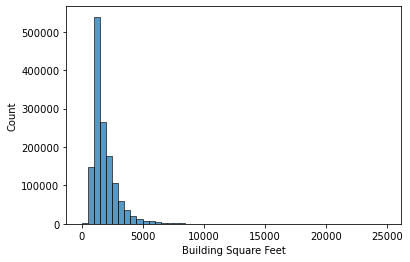

In [160]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Building Square Feet", bins=50)

(0.0, 10000.0)

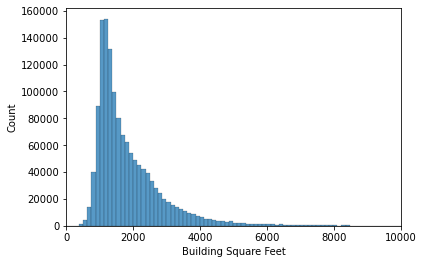

In [162]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Building Square Feet", bins=200)
ax.set_xlim(0, 10000)

(0.0, 4000.0)

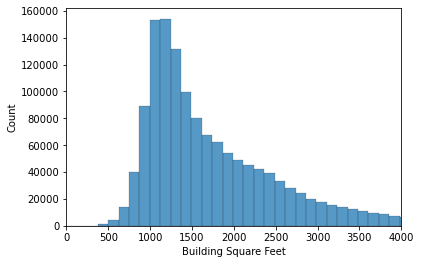

In [164]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Building Square Feet", bins=200)
ax.set_xlim(0, 4000)

In [165]:
cc_res_prop_char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995108 entries, 0 to 1995107
Data columns (total 83 columns):
 #   Column                                           Dtype   
---  ------                                           -----   
 0   PIN                                              Int64   
 1   Property Class                                   category
 2   Tax Year                                         Int64   
 3   Neighborhood Code                                category
 4   Land Square Feet                                 Int64   
 5   Town Code                                        category
 6   Type of Residence                                category
 7   Apartments                                       Int8    
 8   Wall Material                                    category
 9   Roof Material                                    category
 10  Rooms                                            Int8    
 11  Bedrooms                                         Int8    
 12  

### Repair Condition
* State of Repair - 1 = Above average, 2 = Average, 3 = Below average

In [166]:
cc_res_prop_char_df["Repair Condition"].value_counts(dropna=False)

2      1370862
NaN     602055
1        14926
3         7265
Name: Repair Condition, dtype: Int64

In [168]:
def clean_cc_residential_prop_chars_repair_condition_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    state_of_repair_map = {
        1: "Above average",
        2: "Average",
        3: "Below average"
    }
    if "Average" not in df["Repair Condition"].unique():
        df["Repair Condition"] = df["Repair Condition"].map(
            state_of_repair_map
        )
    df["Repair Condition"] = df["Repair Condition"].astype("category")
    return df

In [169]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_repair_condition_col(cc_res_prop_char_df)

In [170]:
cc_res_prop_char_df["Repair Condition"].value_counts(dropna=False)

Average          1370862
NaN               602055
Above average      14926
Below average       7265
Name: Repair Condition, dtype: int64

### Multi Code
* Variable that indicates that more one building exists on the PIN. 2 = one building, 3 = two buildings, etc… through 7 = 6 buildings. 

In [173]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Multi Code"] > 10),
    ["PIN", "Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class", "Multi Code"]
].drop_duplicates().head(30)

PIN   Latitude  Longitude          Property Address  \
126047  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126048  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126049  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126050  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126051  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126052  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126062  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126063  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126064  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126065  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126066  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
126067  4274160230000  42.081715 -87.817912  2501  INDIGO LN GLENVIEW   
160716  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160721  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160722  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160723  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160724  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160726  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160727  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160728  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160729  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160730  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160731  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160732  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160733  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160734  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160735  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160736  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160737  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   
160738  6062000700000  42.065403 -88.244758   1368  BRADLEY CIR ELGIN   

        Land Square Feet Property Class  Multi Code  
126047            192668            204          17  
126048            192668            204          18  
126049            192668            204          19  
126050            192668            204          20  
126051            192668            204          21  
126052            192668            204          22  
126062            192668            204          11  
126063            192668            204          12  
126064            192668            204          13  
126065            192668            204          14  
126066            192668            204          15  
126067            192668            204          16  
160716            195190            295          47  
160721            195190            295          11  
160722            195190            295          12  
160723            195190            295          13  
160724            195190            295          14  
160726            195190            295          35  
160727            195190            295          36  
160728            195190            295          37  
160729            195190            295          38  
160730            195190            295          39  
160731            195190            295          40  
160732            195190            295          41  
160733            195190            295          42  
160734            195190            295          43  
160735            195190            295          44  
160736            195190            295          45  
160737            195190            295          46  
160738            195190            295          15

For units with high `Multi Code` values, it looks kind of like they're mainly subdivisions and apartment blocks that were incorrectly entered, with some centralized address used and `Multi Code` to identify buildings. This is kind of irritating as it will impact these properties, but on the other hand, it's not that many. 

In [176]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Multi Code"] == 7),
    ["PIN", "Latitude", "Longitude", "Property Address", 
     "Land Square Feet", "Property Class", "Multi Code"]
].drop_duplicates().head(30)

PIN   Latitude  Longitude               Property Address  \
126058   4274160230000  42.081715 -87.817912       2501  INDIGO LN GLENVIEW   
126203   4274280020000  42.079813 -87.816821       2501  INDIGO LN GLENVIEW   
126214   4274280040000  42.082009 -87.815081       2301  INDIGO LN GLENVIEW   
126437   4282020180000  42.093996  -87.83252        2164  CORAL LN GLENVIEW   
126443   4282020190000  42.093998 -87.832901    2169  DAUNTLESS DR GLENVIEW   
126637   4282070400000  42.090971 -87.832551     1993  DANTLESS DR GLENVIEW   
126680   4282080040000  42.092492 -87.832518    2101  DAUNTLESS DR GLENVIEW   
126686   4282080050000  42.093017 -87.832496    2125  DAUNTLESS DR GLENVIEW   
126690   4282080060000  42.093643  -87.83125      2176  SHERMER RD GLENVIEW   
126702   4282080090000  42.092487 -87.832016      2102  SHERMER RD GLENVIEW   
134149   4351240090000   42.07974 -87.806932  1340  GREENWILLOW LN GLENVIEW   
160464   6062000640000  42.063138 -88.245484        0  TOASTMASTER DR ELGIN   
160717   6062000700000  42.065403 -88.244758        1368  BRADLEY CIR ELGIN   
160768   6062000770000  42.065001 -88.244824       77  TOASTMASTER DR ELGIN   
160906   6062000790000  42.065666 -88.247615          1202  MEAGAN CT ELGIN   
323194  10134130120000  42.044508 -87.698489         1811  LAKE ST EVANSTON   
539129   4274160230000  42.081715 -87.817911                2501  INDIGO LN   
539282   4274280020000  42.079813  -87.81682                2501  INDIGO LN   
539291   4274280040000  42.082009  -87.81508                2301  INDIGO LN   
547227   4351240090000   42.07974 -87.806932           1340  GREENWILLOW LN   
573504   6062000640000  42.063138 -88.245484              1202  BRADLEY CIR   
573508   6062000700000  42.065403 -88.244758              1368  BRADLEY CIR   
573554   6062000770000  42.065001 -88.244824             77  TOASTMASTER DR   
573662   6062000790000  42.065666 -88.247615                1202  MEAGAN CT   
695549   9171070020000  42.048716 -87.901968             800  NORTHWEST HWY   
695556   9171070030000  42.048942 -87.901777           65  NICHOLAS DR EAST   
695562   9171070040000  42.049165 -87.901591             800  NORTHWEST HWY   
695564   9171070090000  42.048805 -87.902639             800  NORTHWEST HWY   
701598   9202000490000  42.037853 -87.890117     844  LEXINGTON CIRCLE WEST   
738409  10134130120000  42.044508 -87.698489                  1811  LAKE ST   

        Land Square Feet Property Class  Multi Code  
126058            192668            204           7  
126203            101028            295           7  
126214            103124            295           7  
126437              9129            295           7  
126443              9129            295           7  
126637             16456            295           7  
126680             16250            295           7  
126686             16132            295           7  
126690             17492            295           7  
126702             16761            295           7  
134149             15696            295           7  
160464             90343            295           7  
160717            195190            295           7  
160768             26863            295           7  
160906            184887            295           7  
323194             13377            295           7  
539129            192668            204           7  
539282            101028            295           7  
539291            103124            295           7  
547227             15696            295           7  
573504             90343            295           7  
573508            195190            295           7  
573554             26863            295           7  
573662            184887            295           7  
695549              7041            295           7  
695556              7041            295           7  
695562              7041            295           7  
695564              8120            295           7  
701

In [171]:
cc_res_prop_char_df["Multi Code"].value_counts(dropna=False)

2      1372913
NaN     602017
3        18803
4          717
5          230
6           98
7           63
8           32
9           25
10          21
11          13
12          11
13          10
14           8
21           7
17           7
16           7
15           7
18           7
19           7
20           7
22           6
36           4
34           4
35           4
37           4
38           4
39           4
40           4
41           4
42           4
43           4
27           4
24           4
23           4
32           4
31           4
30           4
33           4
28           4
25           4
29           4
26           4
46           2
45           2
44           2
47           2
Name: Multi Code, dtype: Int64

In [ ]:
number_of_buildings_map = {
    2: "One building",
    3: "Two buildings",
    4: "Three buildings",
    5: "Four buildings",
    6: "Five buildings",
    7: "Six buildings",
    8: "Bad Value Entered"
}

In [179]:
def clean_cc_residential_prop_chars_multi_code_col(
    df: pd.DataFrame
) -> pd.DataFrame:
    number_of_buildings_map = {
        2: "One building",
        3: "Two buildings",
        4: "Three buildings",
        5: "Four buildings",
        6: "Five buildings",
        7: "Six buildings",
        8: "Bad Value Entered"
    }
    bad_multi_code_value_mask = df["Multi Code"] >= 8
    df.loc[bad_multi_code_value_mask, "Multi Code"] = 9
    if "One building" not in df["Multi Code"].unique():
        df["Multi Code"] = df["Multi Code"].map(
            number_of_buildings_map
        )
    df["Multi Code"] = df["Multi Code"].astype("category")
    return df

In [180]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_multi_code_col(cc_res_prop_char_df)

In [181]:
cc_res_prop_char_df["Multi Code"].value_counts(dropna=False)

One building       1372913
NaN                 602284
Two buildings        18803
Three buildings        717
Four buildings         230
Five buildings          98
Six buildings           63
Name: Multi Code, dtype: int64

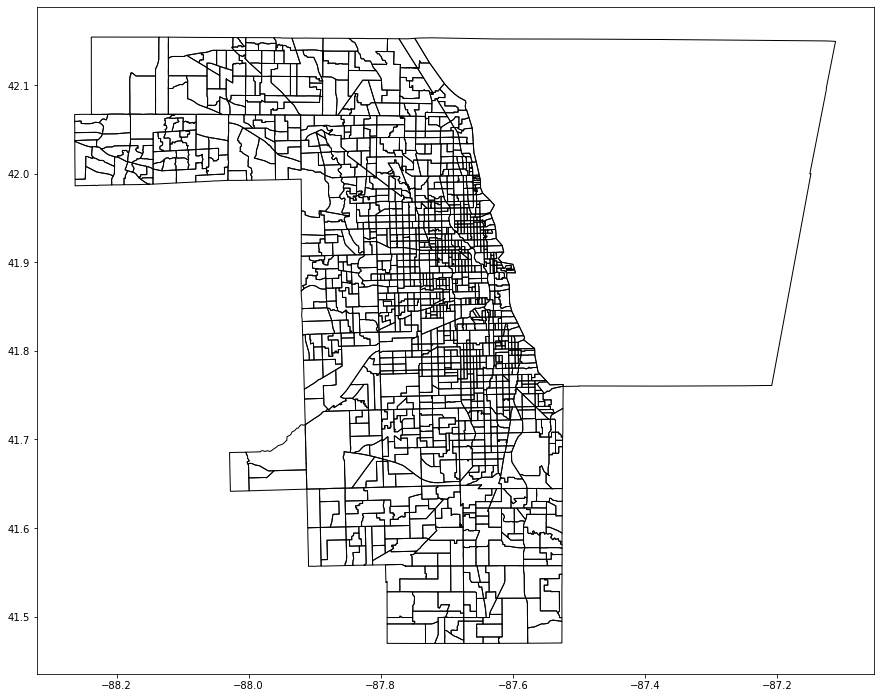

In [280]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cook_county_census_tract_2020_gdf.plot(color="none", ax=ax)

In [284]:
cook_county_census_tract_2010_gdf = get_2010_cook_county_census_tract_gdf()
cook_county_census_tract_2010_gdf.shape

(1319, 13)

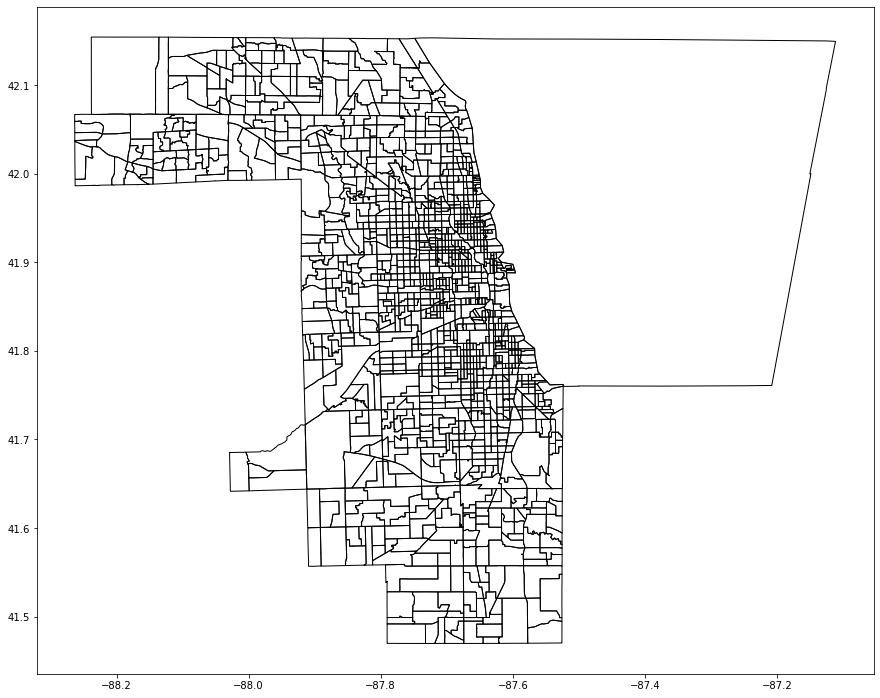

In [285]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cook_county_census_tract_2010_gdf.plot(color="none", ax=ax)

In [287]:
gdf.head(2)

PIN Property Class  Tax Year Neighborhood Code  Land Square Feet  \
0  1011000040000            212      2018               012             11055   
1  1011000050000            205      2018               012              6534   

  Town Code Type of Residence  Apartments Wall Material    Roof Material  \
0        10         two story           5          Wood   Tar and Gravel   
1        10         two story           0          Wood  Shingle/Asphalt   

   Rooms  Bedrooms Basement Basement Finish  Central Heating Other Heating  \
0      7         5  Partial      Unfinished         Warm air          none   
1      7         4     Full      Unfinished  Hot water steam          none   

   Central Air  Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
0        False           0       Full   Unfinished           1  Stock Plan   
1        False           1       Full   Unfinished           0  Stock Plan   

  Cathedral Ceiling Construction Quality Renovation     Site Desireability  \
0                No              Average        NaN  Not relevant to Value   
1                No              Average        NaN  Not relevant to Value   

  Garage 1 Size Garage 1 Material Garage 1 Attachment  \
0       1.5 car             Frame                  No   
1         2 car             Frame                  No   

                                   Garage 1 Area Garage 2 Size  \
0  No, garage area not included in building area          None   
1  No, garage area not included in building area          None   

           Garage 2 Material        Garage 2 Attachment  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

               Garage 2 Area  Porch  Other Improvements  Building Square Feet  \
0  Car Port or Driveway Only   None                 200                  1904   
1  Car Port or Driveway Only  Frame                   0                  1562   

  Repair Condition    Multi Code  Number of Commercial Units  \
0          Average  One building                           1   
1          Average  One building                           0   

   Prior Tax Year Market Value Estimate (Land)  \
0                                        52510   
1                                        31030   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           374930                      NaT   
1                                           173970                      NaT   

   Deed No.  Sale Price  Longitude   Latitude  Census Tract  \
0      <NA>        <NA> -88.139621  42.153953        804201   
1      <NA>        <NA> -88.139379  42.153953        804201   

   Total Building Square Feet  Multi Property Indicator  \
0                        <NA>                         0   
1                        <NA>                         0   

           Property Address Modeling Group  Full Baths  Age  Use  \
0  213 W MAIN ST BARRINGTON             MF           5  135    2   
1  209 W MAIN ST BARRINGTON             SF           1  114    1   

   Number of Units  Percent Ownership  Condo Class Factor  \
0             <NA>               <NA>                <NA>   
1             <NA>               <NA>                <NA>   

   Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
0                     212          0                                <NA>   
1                    <NA>          0                                <NA>   

  Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
0      <NA>             0           0                1            1   
1      <NA>             0           0                1            1   

   Condo Strata  Age Squared  Age Decade  Age Decade Squared  \
0          <NA>        18225        13.5              182.25   
1          <NA>        12996        11.4              129.96   

   Lot Size Squared  Improvement Size Squared  Location Factor  \
0

In [290]:
evanston_gdf = gdf.loc[(gdf["Town Code"] == "17")].copy()

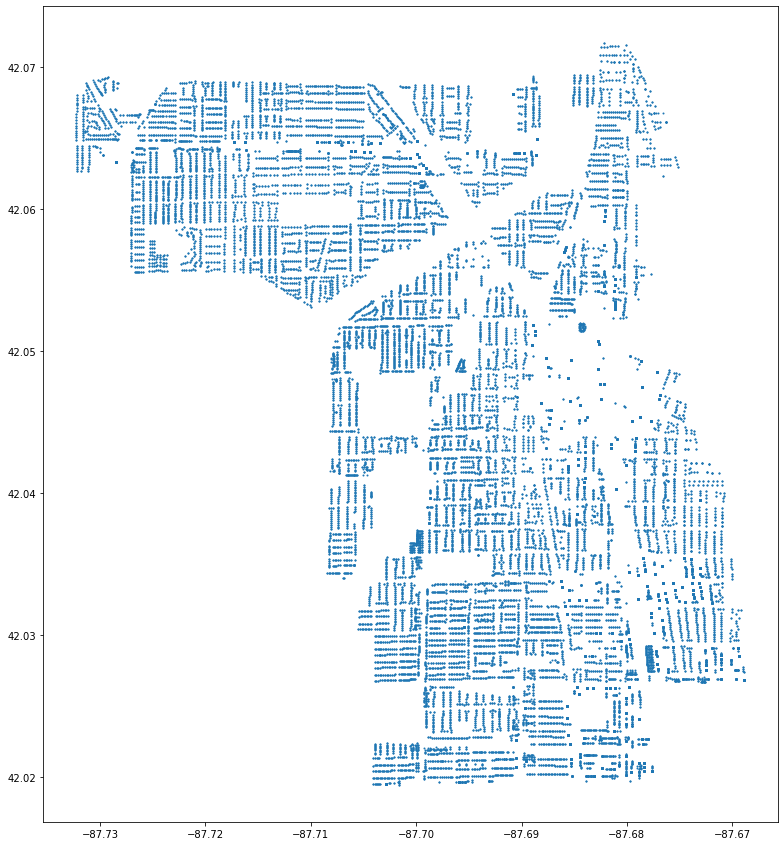

In [291]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = evanston_gdf.plot(markersize=1, ax=ax)

In [292]:
evanston_gdf.head(2)

PIN Property Class  Tax Year Neighborhood Code  \
154581  5333030140000            234      2018               011   
154582  5333030150000            234      2018               011   

        Land Square Feet Town Code Type of Residence  Apartments  \
154581              2850        17       split level           0   
154582              2850        17       split level           0   

       Wall Material    Roof Material  Rooms  Bedrooms Basement  \
154581       Masonry  Shingle/Asphalt      6         3  Partial   
154582       Masonry  Shingle/Asphalt      6         3  Partial   

        Basement Finish Central Heating Other Heating  Central Air  \
154581  Formal rec room        Warm air          none         True   
154582  Formal rec room        Warm air          none         True   

        Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
154581           0       None          NaN           0  Stock Plan   
154582           0       None          NaN           0  Stock Plan   

       Cathedral Ceiling Construction Quality Renovation  \
154581           Unknown              Average        NaN   
154582           Unknown              Average        NaN   

           Site Desireability              Garage 1 Size  \
154581  Not relevant to Value  Car Port or Driveway Only   
154582  Not relevant to Value  Car Port or Driveway Only   

                Garage 1 Material        Garage 1 Attachment  \
154581  Car Port or Driveway Only  Car Port or Driveway Only   
154582  Car Port or Driveway Only  Car Port or Driveway Only   

                    Garage 1 Area Garage 2 Size          Garage 2 Material  \
154581  Car Port or Driveway Only          None  Car Port or Driveway Only   
154582  Car Port or Driveway Only          None  Car Port or Driveway Only   

              Garage 2 Attachment              Garage 2 Area Porch  \
154581  Car Port or Driveway Only  Car Port or Driveway Only  None   
154582  Car Port or Driveway Only  Car Port or Driveway Only  None   

        Other Improvements  Building Square Feet Repair Condition  \
154581                   0                  1211          Average   
154582                   0                  1211          Average   

          Multi Code  Number of Commercial Units  \
154581  One building                           0   
154582  One building                           0   

        Prior Tax Year Market Value Estimate (Land)  \
154581                                        25650   
154582                                        25650   

        Prior Tax Year Market Value Estimate (Building)  \
154581                                           175630   
154582                                           175630   

       Date of Most Recent Sale  Deed No.  Sale Price  Longitude   Latitude  \
154581                      NaT      <NA>        <NA> -87.729990  42.068233   
154582                      NaT      <NA>        <NA> -87.729942  42.068173   

        Census Tract  Total Building Square Feet  Multi Property Indicator  \
154581        808900                        <NA>                         0   
154582        808900                        <NA>                         0   

                   Property Address Modeling Group  Full Baths  Age  Use  \
154581  2747  CRAWFORD AVE EVANSTON             SF           2   58    1   
154582  2747  CRAWFORD AVE EVANSTON             SF           2   58    1   

        Number of Units  Percent Ownership  Condo Class Factor  \
154581             <NA>               <NA>                <NA>   
154582             <NA>               <NA>                <NA>   

        Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
154581                    <NA>          0                                <NA>   
154582                    <NA>          0                                <NA>   

       Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
154581      <NA>             0           0           

In [286]:
cook_county_census_tract_2010_gdf.head(2)

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10  NAME10    NAMELSAD10 MTFCC10  \
0        17        031    010100  17031010100     101  Census Tract   G5020   
1        17        031    010201  17031010201  102.01  Census Tract   G5020   

  FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
0          S   379751         0  +42.0212564  -087.6698316   
1          S   504464         0  +42.0160077  -087.6801484   

                                            geometry  
0  POLYGON ((-87.67720 42.02294, -87.67628 42.022...  
1  POLYGON ((-87.68465 42.01948, -87.68432 42.019...

In [294]:
evanston_gdf["Census Tract"] = evanston_gdf["Census Tract"].astype("string")

In [295]:
merge_gdf = pd.merge(
    left=evanston_gdf,
    right=cook_county_census_tract_2010_gdf,
    how="outer",
    left_on="Census Tract",
    right_on="TRACTCE10"
    
)

In [296]:
merge_gdf.shape

(46017, 97)

In [299]:
merge_gdf.head(2)

PIN Property Class  Tax Year Neighborhood Code  Land Square Feet  \
0  5333030140000            234      2018               011              2850   
1  5333030150000            234      2018               011              2850   

  Town Code Type of Residence  Apartments Wall Material    Roof Material  \
0        17       split level           0       Masonry  Shingle/Asphalt   
1        17       split level           0       Masonry  Shingle/Asphalt   

   Rooms  Bedrooms Basement  Basement Finish Central Heating Other Heating  \
0      6         3  Partial  Formal rec room        Warm air          none   
1      6         3  Partial  Formal rec room        Warm air          none   

   Central Air  Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
0         True           0       None          NaN           0  Stock Plan   
1         True           0       None          NaN           0  Stock Plan   

  Cathedral Ceiling Construction Quality Renovation     Site Desireability  \
0           Unknown              Average        NaN  Not relevant to Value   
1           Unknown              Average        NaN  Not relevant to Value   

               Garage 1 Size          Garage 1 Material  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

         Garage 1 Attachment              Garage 1 Area Garage 2 Size  \
0  Car Port or Driveway Only  Car Port or Driveway Only          None   
1  Car Port or Driveway Only  Car Port or Driveway Only          None   

           Garage 2 Material        Garage 2 Attachment  \
0  Car Port or Driveway Only  Car Port or Driveway Only   
1  Car Port or Driveway Only  Car Port or Driveway Only   

               Garage 2 Area Porch  Other Improvements  Building Square Feet  \
0  Car Port or Driveway Only  None                   0                  1211   
1  Car Port or Driveway Only  None                   0                  1211   

  Repair Condition    Multi Code  Number of Commercial Units  \
0          Average  One building                           0   
1          Average  One building                           0   

   Prior Tax Year Market Value Estimate (Land)  \
0                                        25650   
1                                        25650   

   Prior Tax Year Market Value Estimate (Building) Date of Most Recent Sale  \
0                                           175630                      NaT   
1                                           175630                      NaT   

   Deed No.  Sale Price  Longitude   Latitude Census Tract  \
0      <NA>        <NA> -87.729990  42.068233       808900   
1      <NA>        <NA> -87.729942  42.068173       808900   

   Total Building Square Feet  Multi Property Indicator  \
0                        <NA>                         0   
1                        <NA>                         0   

              Property Address Modeling Group  Full Baths  Age  Use  \
0  2747  CRAWFORD AVE EVANSTON             SF           2   58    1   
1  2747  CRAWFORD AVE EVANSTON             SF           2   58    1   

   Number of Units  Percent Ownership  Condo Class Factor  \
0             <NA>               <NA>                <NA>   
1             <NA>               <NA>                <NA>   

   Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
0                    <NA>          0                                <NA>   
1                    <NA>          0                                <NA>   

  Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
0      <NA>             0           0                1            1   
1      <NA>             0           0                1            1   

   Condo Strata  Age Squared  Age Decade  Age Decade Squared  \
0          <NA>         3364         5.8               33.64   
1          <NA>         3364         5.8               33.64   

   Lot Size Squared  Improvement Size

In [302]:
cook_county_census_tract_2010_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [306]:
cook_county_census_tract_2010_gdf = cook_county_census_tract_2010_gdf.to_crs(evanston_gdf.crs)

In [312]:
sjoin_gdf = gpd.sjoin(evanston_gdf, cook_county_census_tract_2010_gdf, how="left", op="within")
sjoin_gdf.shape

(44716, 97)

In [313]:
# sjoin_gdf = gpd.sjoin(cook_county_census_tract_2010_gdf, evanston_gdf, how="left", op="within")
# sjoin_gdf.shape

<AxesSubplot:>

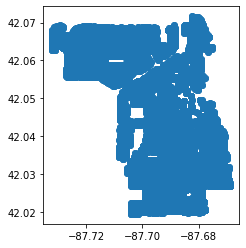

In [314]:
sjoin_gdf.plot()

In [315]:
sjoin_gdf.head(2)

PIN Property Class  Tax Year Neighborhood Code  \
154581  5333030140000            234      2018               011   
154582  5333030150000            234      2018               011   

        Land Square Feet Town Code Type of Residence  Apartments  \
154581              2850        17       split level           0   
154582              2850        17       split level           0   

       Wall Material    Roof Material  Rooms  Bedrooms Basement  \
154581       Masonry  Shingle/Asphalt      6         3  Partial   
154582       Masonry  Shingle/Asphalt      6         3  Partial   

        Basement Finish Central Heating Other Heating  Central Air  \
154581  Formal rec room        Warm air          none         True   
154582  Formal rec room        Warm air          none         True   

        Fireplaces Attic Type Attic Finish  Half Baths Design Plan  \
154581           0       None          NaN           0  Stock Plan   
154582           0       None          NaN           0  Stock Plan   

       Cathedral Ceiling Construction Quality Renovation  \
154581           Unknown              Average        NaN   
154582           Unknown              Average        NaN   

           Site Desireability              Garage 1 Size  \
154581  Not relevant to Value  Car Port or Driveway Only   
154582  Not relevant to Value  Car Port or Driveway Only   

                Garage 1 Material        Garage 1 Attachment  \
154581  Car Port or Driveway Only  Car Port or Driveway Only   
154582  Car Port or Driveway Only  Car Port or Driveway Only   

                    Garage 1 Area Garage 2 Size          Garage 2 Material  \
154581  Car Port or Driveway Only          None  Car Port or Driveway Only   
154582  Car Port or Driveway Only          None  Car Port or Driveway Only   

              Garage 2 Attachment              Garage 2 Area Porch  \
154581  Car Port or Driveway Only  Car Port or Driveway Only  None   
154582  Car Port or Driveway Only  Car Port or Driveway Only  None   

        Other Improvements  Building Square Feet Repair Condition  \
154581                   0                  1211          Average   
154582                   0                  1211          Average   

          Multi Code  Number of Commercial Units  \
154581  One building                           0   
154582  One building                           0   

        Prior Tax Year Market Value Estimate (Land)  \
154581                                        25650   
154582                                        25650   

        Prior Tax Year Market Value Estimate (Building)  \
154581                                           175630   
154582                                           175630   

       Date of Most Recent Sale  Deed No.  Sale Price  Longitude   Latitude  \
154581                      NaT      <NA>        <NA> -87.729990  42.068233   
154582                      NaT      <NA>        <NA> -87.729942  42.068173   

       Census Tract  Total Building Square Feet  Multi Property Indicator  \
154581       808900                        <NA>                         0   
154582       808900                        <NA>                         0   

                   Property Address Modeling Group  Full Baths  Age  Use  \
154581  2747  CRAWFORD AVE EVANSTON             SF           2   58    1   
154582  2747  CRAWFORD AVE EVANSTON             SF           2   58    1   

        Number of Units  Percent Ownership  Condo Class Factor  \
154581             <NA>               <NA>                <NA>   
154582             <NA>               <NA>                <NA>   

        Multi-Family Indicator  Large Lot Condition, Desirability and Utility  \
154581                    <NA>          0                                <NA>   
154582                    <NA>          0                                <NA>   

       Deed Type  O'Hare Noise  Floodplain  Near Major Road  Total Units  \
154581      <NA>             0           0              

In [317]:
ct_map = sjoin_gdf[["Census Tract", "TRACTCE10", "GEOID10", "NAME10"]].drop_duplicates()
ct_map.shape

(19, 4)

In [318]:
ct_map

Census Tract TRACTCE10      GEOID10   NAME10
154581       808900    808900  17031808900     8089
157814       808800    808800  17031808800     8088
182873       809100    809100  17031809100     8091
191321       809400    809400  17031809400     8094
300880       809500    809500  17031809500     8095
305142       810000    810000  17031810000     8100
312032       810200    810200  17031810200     8102
316847       809200    809200  17031809200     8092
317876       809000    809000  17031809000     8090
320862       808702    808702  17031808702  8087.02
321183       809600    809600  17031809600     8096
321253       809300    809300  17031809300     8093
345449       809700    809700  17031809700     8097
345953       810302    810302  17031810302  8103.02
346747       810301    810301  17031810301  8103.01
349695       809800    809800  17031809800     8098
370539       809900    809900  17031809900     8099
372377       810100    810100  17031810100     8101
572055         <NA>       NaN          NaN      NaN

In [320]:
cook_county_census_tract_2010_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   1319 non-null   object  
 1   COUNTYFP10  1319 non-null   object  
 2   TRACTCE10   1319 non-null   object  
 3   GEOID10     1319 non-null   object  
 4   NAME10      1319 non-null   object  
 5   NAMELSAD10  1319 non-null   object  
 6   MTFCC10     1319 non-null   object  
 7   FUNCSTAT10  1319 non-null   object  
 8   ALAND10     1319 non-null   int64   
 9   AWATER10    1319 non-null   int64   
 10  INTPTLAT10  1319 non-null   object  
 11  INTPTLON10  1319 non-null   object  
 12  geometry    1319 non-null   geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 134.1+ KB


In [319]:
cc_res_prop_char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995108 entries, 0 to 1995107
Data columns (total 84 columns):
 #   Column                                           Dtype         
---  ------                                           -----         
 0   PIN                                              Int64         
 1   Property Class                                   category      
 2   Tax Year                                         Int64         
 3   Neighborhood Code                                category      
 4   Land Square Feet                                 Int64         
 5   Town Code                                        category      
 6   Type of Residence                                category      
 7   Apartments                                       Int8          
 8   Wall Material                                    category      
 9   Roof Material                                    category      
 10  Rooms                                            Int8 

In [321]:
def clean_cc_residential_prop_chars_census_tract_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Census Tract"] = df["Census Tract"].astype("string")
    return df

### Total Building Square Feet
* This field applies to condominium properties (299) only. It is the sum of interior square feet of all units in the building.

In [322]:
cc_res_prop_char_df["Total Building Square Feet"].isnull().sum()

1977874

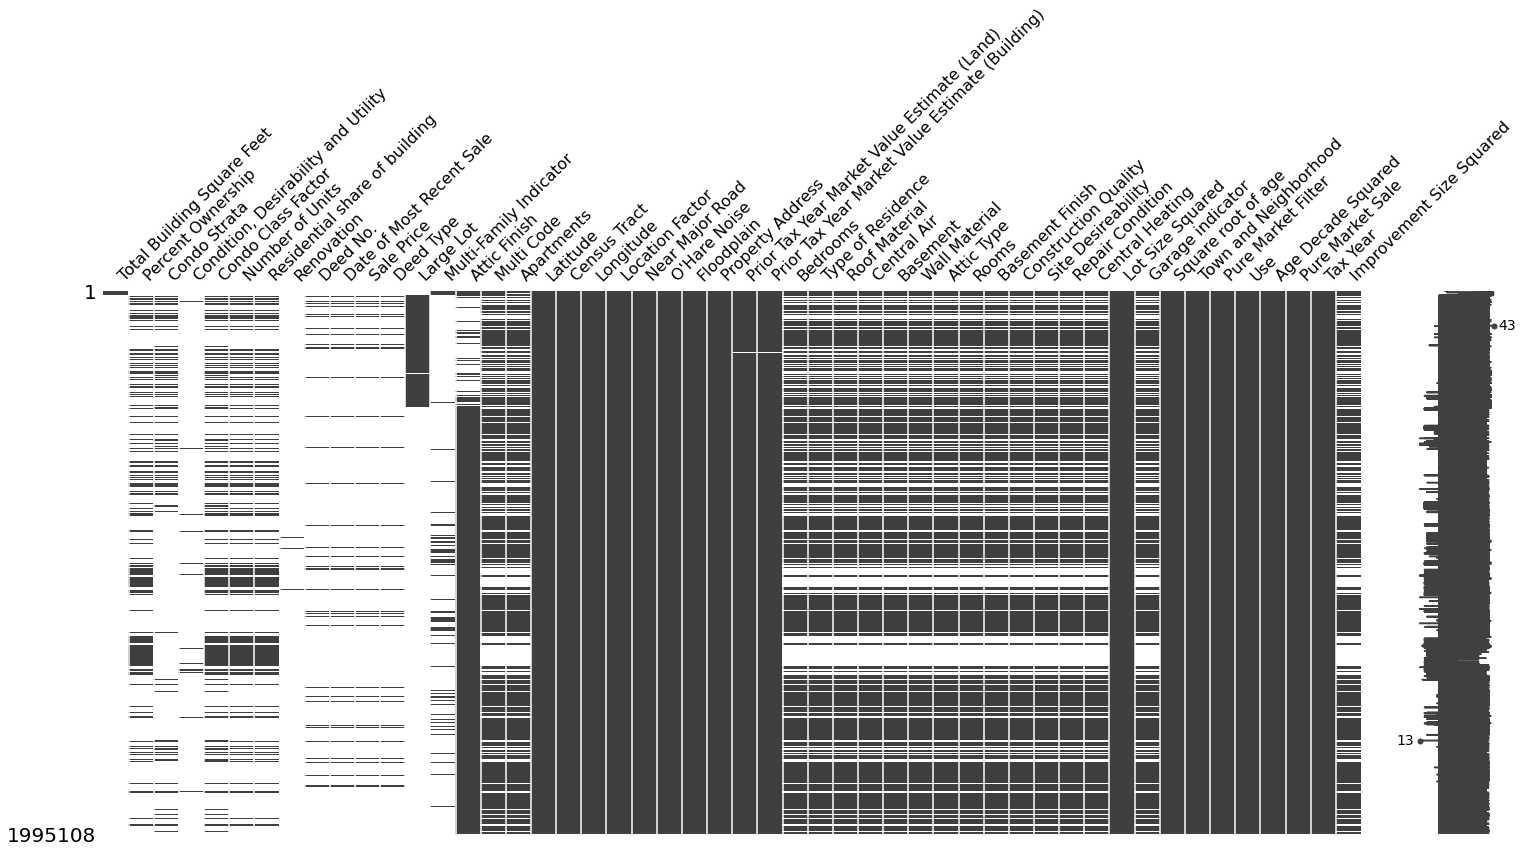

In [323]:
utils.plot_highly_missingness_correlated_cols(
    col="Total Building Square Feet", plot_df=cc_res_prop_char_df, i=0, positive_corr=False
)

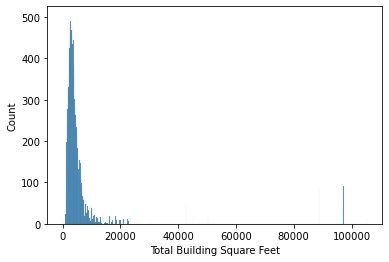

In [324]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Total Building Square Feet", 
    bins=1000
)
# ax.set_xlim(0, 1200000)

(0.0, 10000.0)

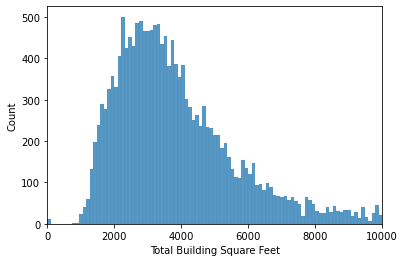

In [325]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Total Building Square Feet", 
    bins=1000
)
ax.set_xlim(0, 10000)

### Multi Property Indicator
* Indicator for a property with mutiple improvements on one PIN, e.g. a main house and a coach house. NOT to be confused with a property which was part of a multi-pin sale.

In [326]:
cc_res_prop_char_df["Multi Property Indicator"].value_counts(dropna=False)

0      1977874
1        17234
NaN          0
Name: Multi Property Indicator, dtype: Int64

In [329]:
def clean_cc_residential_prop_chars_multi_property_indicator_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Multi Property Indicator"] = df["Multi Property Indicator"].astype("boolean")
    return df

In [330]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_multi_property_indicator_col(cc_res_prop_char_df)

In [331]:
cc_res_prop_char_df["Multi Property Indicator"].value_counts(dropna=False)

False    1977874
True       17234
NaN            0
Name: Multi Property Indicator, dtype: Int64

### Property Address
* Property street address, not the address of the taxpayer.

### Modeling Group
* Modeling group, as defined by the property class. Properties with class 200, 201, 241, 299 is defined as "NCHARS", short for "no characteristics", which are condos and vacant land classes. Properties with class 202, 203, 204, 205, 206, 207, 208, 209, 210, 235, 278, and 295 are "SF", short for "single-family." Properties with class 211 and 212 are "MF", short for ""multi-family."

In [332]:
cc_res_prop_char_df["Modeling Group"].value_counts(dropna=False)

SF        1213855
NCHARS     571586
MF         179266
FIXED       30401
Name: Modeling Group, dtype: Int64

In [333]:
def clean_cc_residential_prop_chars_modeling_group_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Modeling group, as defined by the property class. Properties with
    class 200, 201, 241, 299 is defined as "NCHARS", short for "no 
    characteristics", which are condos and vacant land classes. Properties
    with class 202, 203, 204, 205, 206, 207, 208, 209, 210, 235, 278, and 295
    are "SF", short for "single-family." Properties with class 211 and 212 are
    "MF", short for ""multi-family."
    """
    df["Modeling Group"] = df["Modeling Group"].astype("category")
    return df

In [334]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_modeling_group_col(cc_res_prop_char_df)

In [335]:
cc_res_prop_char_df["Modeling Group"].value_counts(dropna=False)

SF        1213855
NCHARS     571586
MF         179266
FIXED       30401
Name: Modeling Group, dtype: int64

### Full Baths
* Number of full bathrooms, defined as having a bath or shower. If this value is missing, the default value is set to 1.

In [336]:
cc_res_prop_char_df["Full Baths"].value_counts(dropna=False)

1      807601
2      530544
NaN    485612
3      114682
4       32275
6       14694
5        8307
7         589
8         371
10        259
9          62
0          39
12         38
11         33
13          2
Name: Full Baths, dtype: Int64

In [337]:
def clean_cc_residential_prop_chars_full_baths_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Full Baths"] = df["Full Baths"].astype("Int8")
    return df

In [338]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_full_baths_col(cc_res_prop_char_df)

In [339]:
cc_res_prop_char_df["Full Baths"].value_counts(dropna=False)

1      807601
2      530544
NaN    485612
3      114682
4       32275
6       14694
5        8307
7         589
8         371
10        259
9          62
0          39
12         38
11         33
13          2
Name: Full Baths, dtype: Int64

### Age
* Age of the property. If missing, this defaults to 10. This field is a combination of original age and effective age where original age refers to the oldest component of the building and effective age is a relative judgement due to renovations or other improvements. For instance, if a property is completely demolished and built up again, the age resets to 1. But if portions of the original structure are kept, it may be more complicated to determine the age.

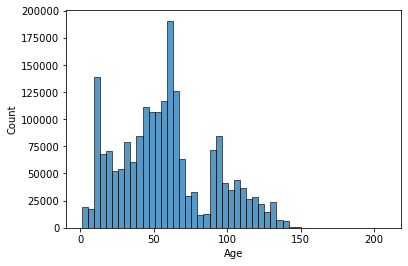

In [346]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Age", 
    bins=50
)
# ax.set_xlim(0, 10000)

In [351]:
def clean_cc_residential_prop_chars_age_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Age of the property. If missing, this defaults to 10. This field is a
    combination of original age and effective age where original age refers to
    the oldest component of the building and effective age is a relative
    judgement due to renovations or other improvements. For instance, if a
    property is completely demolished and built up again, the age resets to 1.
    But if portions of the original structure are kept, it may be more
    complicated to determine the age."""
    df["Age"] = df["Age"].astype("Int16")
    return df

In [354]:
2**16

65536

In [352]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_age_col(cc_res_prop_char_df)

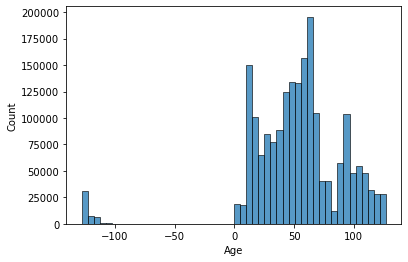

In [353]:
ax = sns.histplot(
    data=cc_res_prop_char_df, 
    x="Age", 
    bins=50
)
# ax.set_xlim(0, 10000)

### Use
* Use of property - 1 = single family, 2 = multi-family. If absent, default value is 1.

In [355]:
cc_res_prop_char_df["Use"].value_counts(dropna=False)

1      1818396
2       176712
NaN          0
Name: Use, dtype: Int64

In [ ]:
use_of_property_map = {
    1: "Single Family",
    2: "Multi Family"
}
# If absent, default value is 1.

In [ ]:
use_of_property_map = {
    1: "Single Family",
    2: "Multi Family"
}

In [358]:
def clean_cc_residential_prop_chars_use_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Use of property - 1 = single family, 2 = multi-family. If absent, 
    default value is 1."""
    use_of_property_map = {
        1: "Single Family",
        2: "Multi Family"
    }
    if "Single Family" not in df["Use"].unique():
        df["Use"] = df["Use"].map(use_of_property_map)
    df["Use"] = df["Use"].astype("category")
    return df

In [359]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_use_col(cc_res_prop_char_df)

In [360]:
cc_res_prop_char_df["Use"].value_counts(dropna=False)

Single Family    1818396
Multi Family      176712
Name: Use, dtype: int64

### Number of Units
* For condos, the number of units in a building

In [361]:
cc_res_prop_char_df["Number of Units"].value_counts(dropna=False)

NaN    1433886
6        15488
12       11676
3        10803
4         8572
        ...   
161        161
157        157
153        153
131        131
1           26
Name: Number of Units, Length: 464, dtype: Int64

In [362]:
cc_res_prop_char_df["Number of Units"].max()

1680

In [366]:
def clean_cc_residential_prop_chars_number_of_units_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """For condos, the number of units in a building"""
    df["Number of Units"] = df["Number of Units"].astype(
        "Int16"
    )
    return df

In [367]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_number_of_units_col(cc_res_prop_char_df)

In [368]:
cc_res_prop_char_df["Number of Units"].value_counts(dropna=False)

NaN    1433886
6        15488
12       11676
3        10803
4         8572
        ...   
161        161
157        157
153        153
131        131
1           26
Name: Number of Units, Length: 464, dtype: Int64

### Percent Ownership
* Percent of ownership of a condo building for a unit as defined by the condominium declaration. If missing, default is 1/n_units.

In [370]:
cc_res_prop_char_df["Percent Ownership"].value_counts(dropna=False)

NaN     1433884
0.0      219639
0.01     135264
0.02      51400
0.03      26819
         ...   
0.72          1
0.71          1
0.69          1
0.68          1
0.75          1
Name: Percent Ownership, Length: 78, dtype: Int64

### Condo Class Factor
* Factor variable for NCHARS modeling group. Divides properties into two: Properties with class 200, 201, and 241 are given condo class factor as 200. Properties with class 299 are given condo class factor as 299

In [371]:
cc_res_prop_char_df["Condo Class Factor"].value_counts(dropna=False)

NaN    1393121
299     561198
200      40789
Name: Condo Class Factor, dtype: Int64

In [372]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_condo_class_factor_col(cc_res_prop_char_df)

In [373]:
cc_res_prop_char_df["Condo Class Factor"].value_counts(dropna=False)

NaN                        1393121
residential_condominium     561198
residential_land             40789
Name: Condo Class Factor, dtype: int64

### Multi-Family Indicator
* Factor variable for MF modeling group. Properties with class 211 are given multi-family indicator as 211. Properties with class 212 are given multi-family indicator as 212.

In [374]:
cc_res_prop_char_df["Multi-Family Indicator"].value_counts(dropna=False)

NaN    1815842
211     164337
212      14929
Name: Multi-Family Indicator, dtype: Int64

In [376]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Property Class"] == 211),
    "Multi-Family Indicator"
].value_counts(dropna=False)

211    164337
NaN         0
Name: Multi-Family Indicator, dtype: Int64

In [377]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Property Class"] == 212),
    "Multi-Family Indicator"
].value_counts(dropna=False)

212    14929
NaN        0
Name: Multi-Family Indicator, dtype: Int64

In [378]:
def clean_cc_residential_prop_chars_multi_family_indicator_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """Factor variable for MF modeling group. Properties with class 211 are
    given multi-family indicator as 211. Properties with class 212 are given
    multi-family indicator as 212."""
    multi_family_map = {
        211: "Yes",
        212: "Yes",
    }
    if "Yes" not in df["Multi-Family Indicator"].unique():
        df["Multi-Family Indicator"] = df["Multi-Family Indicator"].map(
            multi_family_map
        )
    df["Multi-Family Indicator"] = df["Multi-Family Indicator"].astype("category")
    return df

In [379]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_multi_family_indicator_col(cc_res_prop_char_df)

In [380]:
cc_res_prop_char_df["Multi-Family Indicator"].value_counts(dropna=False)

NaN    1815842
Yes     179266
Name: Multi-Family Indicator, dtype: int64

### Large Lot
* Large lot factor variable, where 1 acre of land (land square feet > 43559) is defined as a large lot. 1 = large lot, 0 = not a large lot. 

In [381]:
cc_res_prop_char_df["Large Lot"].value_counts(dropna=False)

NaN    1583785
0       324290
1        87033
Name: Large Lot, dtype: Int64

In [382]:
def clean_cc_residential_prop_chars_large_lot_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Large Lot"] = df["Large Lot"].astype(
        "boolean"
    )
    return df

In [383]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_large_lot_col(cc_res_prop_char_df)

In [384]:
cc_res_prop_char_df["Large Lot"].value_counts(dropna=False)

NaN      1583785
False     324290
True       87033
Name: Large Lot, dtype: Int64

### Condition, Desirability and Utility
* about 20 different codes attached to the face sheet that denote a number of seemingly unrelated characteristics associated with a PIN, ranging from condition to types of subsidies. This field does not match across the SQL server/AS-400 for 2018. 

In [385]:
cc_res_prop_char_df["Condition, Desirability and Utility"].value_counts(dropna=False)

NaN    1934899
GR       27410
AV       22915
AR        4672
GD        4355
EX         449
AX         235
LR         132
MH          26
AA           7
VG           4
LM           2
SR           1
PX           1
Name: Condition, Desirability and Utility, dtype: Int64

I spent easily 30 minutes trying to google my way to a single example of a "face sheet" without success. I don't know if there's a different term, but their [FOIA request sheet](https://prodassets.cookcountyassessor.com/s3fs-public/page_comm/FOIARequestForm.pdf) just uses "FACE SHEET".

I guess I'll just treat these as categories and maybe drop the column later.

In [386]:
def clean_cc_residential_prop_chars_cdu_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    """About 20 different codes attached to the face sheet that denote a
    number of seemingly unrelated characteristics associated with a PIN,
    ranging from condition to types of subsidies. This field does not match
    across the SQL server/AS-400 for 2018."""
    df["Condition, Desirability and Utility"] = df["Condition, Desirability and Utility"].astype("category")
    return df

In [387]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_cdu_col(cc_res_prop_char_df)

In [388]:
cc_res_prop_char_df["Condition, Desirability and Utility"].value_counts(dropna=False)

NaN    1934899
GR       27410
AV       22915
AR        4672
GD        4355
EX         449
AX         235
LR         132
MH          26
AA           7
VG           4
LM           2
PX           1
SR           1
Name: Condition, Desirability and Utility, dtype: int64

### Deed Type
* literally nothing on the data documentation page.

Per this [International Association of Assessing Officers glossary](https://www.iaao.org/media/Pubs/IAAO_Glossary.pdf) linked to from the [Cook County Assessor's Office GitLab](https://gitlab.com/ccao-data-science---modeling/documentation/wiki_content/-/blob/master/Handbook/Glossary.md), these deed types could be 
* Deed,  Bargain  and  Sale
    * A  bargain  and  sale  deed  implicitly  or  explicitly asserts the grantor’s ownership of the property conveyed, but it makes no guarantees to defend the title. It provides the grant-ee more protection than a quitclaim deed but less than a special warranty deed. The words of conveyance “bargain and sale” dis-tinguish a bargain and sale deed.
* Deed, Trust
    * Broadly,  a  deed  by  which  title  to  property  is  transferred to a trustee to be held in trust. (2) Specifically, a deed by which title to property is transferred, conditionally or uncondition-ally, to a trustee to be held for the benefit of creditors or obligors of the grantor. (3) Loosely, the agreement made between an issu-er of bonds and the holders of such bonds that is deposited with the trustee, whether or not such agreement involves the transfer of property to the trustee. Also called “deed of trust.”
* Deed, Tax
    * A  deed  by  which  title  to  real  property,  sold  to  dis-charge delinquent taxes, is transferred by a tax collector or other authorized officer of the law to the purchaser at a tax sale.
* Deed, Quitclaim,
    * A deed in which the grantor conveys or relin-quishes all interests that he or she may have in a property, without warrant as to the extent or validity of such interests.
* Deed, Warranty
    * A  deed  containing  a  covenant  of  warranty  whereby the grantor of an estate of freehold guarantees that the ti-tle that he or she undertakes to transfer is free from defects and that the property is unencumbered except as stated, and whereby the grantor, for him- or herself and his or her heirs, undertakes to de-fend and protect the grantee against any loss that may be suffered by reason of the existence of any other title or interest in the prop-erty existing at the time the deed was executed and not excepted therein. Contrast deed, quitclaim.
* General Warranty Deed: 
    * The most common type of deed, a gen-eral  warranty  deed,  implicitly  promises  that  (1)  the  grantor  owns  the  property  and  may  convey  title,  (2)  there  are  no  hidden  liens  against the property, (3) no one else has better title to the property, (4)  the  grantor  will  obtain  and  deliver  any  documents  needed  to  make good the transfer, and (5) the grantor will be liable for dam-ages if future competing claims to the property prove valid.


Per [this IL study guide](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-1-br.pdf#page=254), deed types other than **Warranty deed** or **Trustee deed** confer less than full ownership (and shouldn't be included in "sales ratio" calculations, whatever those are).

Per [this IL real estate transfer declaration form](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-203.pdf), it looks like the deed types are
* Warranty 
* Quit Claim
* Executor
* Trustee
* Beneficial Interest
* Other ("For a deed-in-trust, limited warranty, special warranty, trust deed, or other deed types not listed on this form, select “Other” and write the deed type")

In [389]:
cc_res_prop_char_df["Deed Type"].value_counts(dropna=False)

NaN    1882731
W        65970
O        33784
T        12623
Name: Deed Type, dtype: Int64

In [391]:
def clean_cc_residential_prop_chars_deed_type_col(df: pd.DataFrame) -> pd.DataFrame:
    deed_type_map = {
        "W": "Warranty",
        "O": "Other",
        "T": "Trustee"
    }
    if "Warranty" not in df["Deed Type"].unique():        
        df["Deed Type"] = df["Deed Type"].map(deed_type_map)
    df["Deed Type"] = df["Deed Type"].astype("category")
    return df

In [392]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_deed_type_col(cc_res_prop_char_df)

In [393]:
cc_res_prop_char_df["Deed Type"].value_counts(dropna=False)

NaN         1882731
Warranty      65970
Other         33784
Trustee       12623
Name: Deed Type, dtype: int64